In [4]:
import pygot
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
from tqdm import tqdm
import pandas as pd
import scvelo as scv
import torch
from experimental import *
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
import mplscience
mplscience.set_style(reset_current=True)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('axes.spines', top=False, right=False)

plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 16  # 设置为适合的字体大小
%matplotlib inline

In [2]:
from TrajectoryNet import dataset
from TrajectoryNet.parse import parser
import torch
import numpy as np

from TrajectoryNet.train_misc import (
    set_cnf_options,
    add_spectral_norm,
    
    create_regularization_fns,
    
    build_model_tabular,
)

def TrajectoryNet_interface(adata_path, res_path, embedding_key, n_iter=1000, dim=10):
    try:
        import TrajectoryNet    
    except ImportError:
        raise ImportError(
                "Please install the TrajectoryNet algorithm: `https://github.com/KrishnaswamyLab/TrajectoryNet`."
            )
    command = "python -m TrajectoryNet.main \
        --dataset {} \
            --embedding_name \"{}\"  --max_dim {}  --top_k_reg 0.1 \
                --training_noise 0.0 --niter {} --vecint 0 --solver 'rk4' \
                --dims \"16-32-16\" \
                    --save {} ".format(adata_path, embedding_key, dim, n_iter, res_path, )
    os.system(command)
    
    model = TrajectoryNet_save_model(adata_path, res_path, embedding_key, dim)
    
    return model
    
def TrajectoryNet_save_model(adata_path, save, embedding_name, dim, device='cpu' ):
    
    args = parser.parse_args(['--dataset', adata_path, '--save', save,
                             '--embedding_name', embedding_name, '--dims', '16-32-16',
                              "--max_dim", str(dim), 
                              '--training_noise', '0.0',
                             '--solver', 'rk4'])
    
    data = dataset.SCData.factory(adata_path, args)

    args.timepoints = data.get_unique_times()

    # Use maximum timepoint to establish integration_times
    # as some timepoints may be left out for validation etc.
    args.int_tps = (np.arange(max(args.timepoints) + 1) + 1.0) * args.time_scale

    regularization_fns, regularization_coeffs = create_regularization_fns(args)
    model = build_model_tabular(args, data.get_shape()[0], regularization_fns).to(
        device
    )
    if args.use_growth:
        growth_model_path = data.get_growth_net_path()
        # growth_model_path = "/home/atong/TrajectoryNet/data/externel/growth_model_v2.ckpt"
        growth_model = torch.load(growth_model_path, map_location=device)
    if args.spectral_norm:
        add_spectral_norm(model)
    set_cnf_options(args, model)

    state_dict = torch.load(save + "/checkpt.pth", map_location=device)
    model.load_state_dict(state_dict["state_dict"])
    return model

# Synthetic

In [3]:
from experimental import *

datasets = ['LI', 'BF', 'LL', 'BFC', 'CY', 'TF']

days = [6, 6, 6, 6, 6, 6]

time_key = 'Day'
embedding_key = 'X_origin'
velocity_key = 'velocity_origin'
experiment_rep = 5


In [21]:
from pygot.tools.traj.model_training import ODEwrapperNoTime
from pygot.external import TIGONwrapper
for i in range(len(datasets)):
    adata, ref_network, pool = experiment('../pygot_data/01_velocity/simulation/inputs/Synthetic/dyn-' + datasets[i] + '_velo' , split_k=days[i])
    velo = pd.read_csv('../pygot_data/01_velocity/simulation/inputs/Synthetic/dyn-'+ datasets[i] + '_velo/VelocityData.csv', index_col=0)
    true_v = velo.to_numpy().T
    os.makedirs('./results/01.1_velocity/unified/'+datasets[i], exist_ok=True)
    for j in range(0, experiment_rep):
        #GOT         
        model, history = pygot.tl.traj.fit_velocity_model(
            adata, time_key, embedding_key, 
            v_centric_iter_n=500, x_centric_iter_n=1000,
        )
        
        torch.save(model.state_dict(), './results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'got.pth')
        
        #TrajectoryNet
        ts = np.sort(np.unique(adata.obs[time_key]))
        ts_map = dict(zip(ts, range(len(ts))))
        
        adata.obs["sample_labels"] = adata.obs[time_key].replace(ts_map)
        sc.write('./results/01.1_velocity/unified/'+datasets[i]+'/adata_trajectorynet.h5ad', adata)
        
        tj_model = ODEwrapperNoTime(TrajectoryNet_interface('./results/01.1_velocity/unified/'+datasets[i]+'/adata_trajectorynet.h5ad', 
                                                                         './results/01.1_velocity/unified/'+datasets[i]+'/TrajectoryNet_{}/'.format(j),
                                                                         embedding_key='origin', dim=adata.obsm['X_origin'].shape[1],
                                                                         n_iter=1500))
        torch.save(tj_model, './results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'trajectorynet.pkl')
        
        #TIGON
        tigon = pygot.external.TIGON_interface(adata, time_key, embedding_key, device,
                    niters=1500, lr=3e-3, num_samples=100, hidden_dim=16,
                    n_hiddens=2, activation='Tanh', max_patience=10)
        
        torch.save(tigon, './results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'tigon.pkl')
    
        
        
        #OT-CFM
        cfm_model, _ = pygot.external.OTCFM_interface(adata, time_key, embedding_key, device, iter_n=1500)
        torch.save(cfm_model.state_dict(), './results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'cfm.pth')

        
        #MIOFlow
        mioflow_model, traj = pygot.external.MIOFlow_interface(
            adata, embedding_key, time_key, exp_dir='/mnt/d/tmp', 
             hold_out=0, hold_one_out=False, use_density_loss=True)
    
        torch.save(mioflow_model.state_dict(), './results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'mioflow.pth')
            
        


loading saved shortest path profile
[Errno 2] No such file or directory: '/_0to1.pkl'
Error in loading shortest path file
calcu shortest path between 0 to 1


100%|█████████████████████████████████████████████████████████████████████████████| 489/489 [00:00<00:00, 1296.08it/s]


calcu shortest path between 1 to 2


100%|█████████████████████████████████████████████████████████████████████████████| 506/506 [00:00<00:00, 1170.21it/s]


calcu shortest path between 2 to 3


100%|█████████████████████████████████████████████████████████████████████████████| 502/502 [00:00<00:00, 1337.75it/s]


calcu shortest path between 3 to 4


100%|█████████████████████████████████████████████████████████████████████████████| 506/506 [00:00<00:00, 1339.00it/s]


calcu shortest path between 4 to 5


loss :11.5377  best :11.5377: 100%|███████████████████████████████████████████████| 1000/1000 [01:02<00:00, 15.93it/s]
/disk/xuruihong/miniconda3/envs/got/lib/python3.10/site-packages/TrajectoryNet/main.py
""" main.py

Learns ODE from scrna data

"""
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn.functional as F
import torch.optim as optim

from TrajectoryNet.lib.growth_net import GrowthNet
from TrajectoryNet.lib import utils
from TrajectoryNet.lib.visualize_flow import visualize_transform
from TrajectoryNet.lib.viz_scrna import (
    save_trajectory,
    trajectory_to_video,
    save_vectors,
)
from TrajectoryNet.lib.viz_scrna import save_trajectory_density


# from train_misc import standard_normal_logprob
from TrajectoryNet.train_misc import (
    set_cnf_options,
    count_nfe,
    count_parameters,
    count_total_time,
    add_spectral_norm,
    spectral_norm_power_iteration,
    create_regularization_fns,


True
Could not find entry in `obsm` for 'velocity_origin'.
Available keys are: ['X_origin'].
Assuming no velocity data.
Density Loss 0.2568361163139343
Density Loss 0.25573471188545227
Density Loss 0.2533070743083954
Density Loss 0.252593994140625
Density Loss 0.2500057518482208
Density Loss 0.24716876447200775
Density Loss 0.24737103283405304
Density Loss 0.24322836101055145
Density Loss 0.24168366193771362
Density Loss 0.23951591551303864
Density Loss 0.23977811634540558
Density Loss 0.23654843866825104
Density Loss 0.23648281395435333
Density Loss 0.23410546779632568
Density Loss 0.23163646459579468
Density Loss 0.234910249710083
Density Loss 0.23080112040042877
Density Loss 0.22856982052326202
Density Loss 0.22703085839748383
Density Loss 0.2246926873922348
Density Loss 0.2248721420764923
Density Loss 0.22383442521095276
Density Loss 0.22311551868915558
Density Loss 0.2198539525270462
Density Loss 0.2183750867843628
Density Loss 0.21768614649772644
Density Loss 0.21731938421726227


Iter 0250 | Time 1.1866(1.3164) | Loss 20.469282(20.569943) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0251 | Time 1.2168(1.3095) | Loss 20.457195(20.562050) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0252 | Time 1.3535(1.3125) | Loss 20.442320(20.553669) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0253 | Time 1.3645(1.3162) | Loss 20.444353(20.546017) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0254 | Time 1.6283(1.3380) | Loss 20.427275(20.537705) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0255 | Time 1.4940(1.3489) | Loss 20.433531(20.530413) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0256 | Time 1.4035(1.3528) | Loss 20.419378(20.522640) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0257 | Time 1.3837(1.3549) | Loss 20.418596(20.515357) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0258 | Time 1.2409(1.3469) | Loss 20.409649(20.507958) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0259 | Time 1.2686(1.3415) | Loss 20.419014(20.501

1.0783244371414185
Density Loss 1.0781807899475098
Density Loss 1.0798892974853516
Density Loss 1.079688310623169
Density Loss 1.087097406387329
Density Loss 1.0859851837158203
Density Loss 1.087060570716858
Density Loss 1.0887564420700073
Density Loss 1.0865333080291748
Density Loss 1.0895859003067017
Density Loss 1.089383602142334
Density Loss 1.089859962463379
Density Loss 1.0900497436523438
Density Loss 1.094186782836914
Density Loss 1.0909467935562134
Density Loss 1.095329999923706
Density Loss 1.0949065685272217
Density Loss 1.0974996089935303
Density Loss 1.100029706954956
Density Loss 1.1012765169143677
Density Loss 1.0994350910186768
Density Loss 1.100280523300171
Density Loss 1.1058714389801025
Density Loss 1.105392336845398
Density Loss 1.10312819480896
Density Loss 1.1061345338821411
Density Loss 1.1021548509597778
Density Loss 1.1040396690368652
Density Loss 1.1058999300003052
Density Loss 1.1082497835159302
Density Loss 1.108877182006836
Density Loss 1.110907793045044
Den

Iter 0505 | Time 1.5071(1.3573) | Loss 19.227097(19.272194) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0506 | Time 1.6217(1.3758) | Loss 19.209806(19.267827) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0507 | Time 1.2459(1.3667) | Loss 19.206097(19.263506) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0508 | Time 1.3553(1.3659) | Loss 19.195118(19.258719) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0509 | Time 1.2894(1.3605) | Loss 19.182743(19.253400) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0510 | Time 1.2774(1.3547) | Loss 19.191133(19.249042) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0511 | Time 1.4083(1.3585) | Loss 19.190485(19.244943) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0512 | Time 1.3686(1.3592) | Loss 19.179531(19.240364) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0513 | Time 1.5779(1.3745) | Loss 19.168261(19.235317) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0514 | Time 1.6074(1.3908) | Loss 19.172667(19.230

1.2993571758270264
Density Loss 1.3004889488220215
Density Loss 1.3001866340637207
Density Loss 1.3006919622421265
Density Loss 1.2987921237945557
Density Loss 1.304755687713623
Density Loss 1.30132257938385
Density Loss 1.3056206703186035
Density Loss 1.3043516874313354
Density Loss 1.3082622289657593
Density Loss 1.3077383041381836
Density Loss 1.3064767122268677
Density Loss 1.3098171949386597
Density Loss 1.3121657371520996
Density Loss 1.3109501600265503
Density Loss 1.3178118467330933
Density Loss 1.311242938041687
Density Loss 1.3147238492965698
Density Loss 1.3150047063827515
Density Loss 1.314358115196228
Density Loss 1.3170655965805054
Density Loss 1.319540023803711
Density Loss 1.3187137842178345
Density Loss 1.317411184310913
Density Loss 1.3214365243911743
Density Loss 1.324531078338623
Density Loss 1.3279179334640503
Density Loss 1.3256566524505615
Density Loss 1.325616478919983
Density Loss 1.3274493217468262
Density Loss 1.3259989023208618
Density Loss 1.333847045898437

Iter 0761 | Time 1.2184(1.2654) | Loss 17.510479(17.565903) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0762 | Time 1.2508(1.2644) | Loss 17.454641(17.558115) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0763 | Time 1.2249(1.2616) | Loss 17.493408(17.553585) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0764 | Time 1.3035(1.2645) | Loss 17.437777(17.545479) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0765 | Time 1.3462(1.2703) | Loss 17.451927(17.538930) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0766 | Time 1.1473(1.2617) | Loss 17.443964(17.532282) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0767 | Time 1.2780(1.2628) | Loss 17.443178(17.526045) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0768 | Time 1.3012(1.2655) | Loss 17.444952(17.520369) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0769 | Time 1.2503(1.2644) | Loss 17.441753(17.514866) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0770 | Time 1.2791(1.2654) | Loss 17.412685(17.507

Density Loss 1.5436503887176514
Density Loss 1.5446851253509521
Density Loss 1.5477699041366577
Density Loss 1.5422232151031494
Density Loss 1.5471725463867188
Density Loss 1.5333415269851685
Density Loss 1.5519992113113403
Density Loss 1.542412519454956
Density Loss 1.5370094776153564
Density Loss 1.53714919090271
Density Loss 1.5437263250350952
Density Loss 1.5349081754684448
Density Loss 1.5359265804290771
Density Loss 1.5326248407363892
Density Loss 1.5419048070907593
Density Loss 1.5281741619110107
Density Loss 1.535062313079834
Density Loss 1.5332249402999878
Density Loss 1.5343904495239258
Density Loss 1.5343440771102905
Density Loss 1.5335195064544678
Density Loss 1.5203585624694824
Density Loss 1.5234394073486328
Density Loss 1.5168501138687134
Density Loss 1.5343663692474365
Density Loss 1.5234776735305786
Density Loss 1.5232114791870117
Density Loss 1.5174463987350464
Density Loss 1.5270204544067383
Density Loss 1.51357901096344
Density Loss 1.519130825996399
Density Loss 1.

Iter 1015 | Time 1.1978(1.2699) | Loss 13.988485(14.202122) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1016 | Time 1.2052(1.2654) | Loss 13.978831(14.186491) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1017 | Time 1.2919(1.2672) | Loss 14.026737(14.175309) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1018 | Time 1.2117(1.2633) | Loss 14.018044(14.164300) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1019 | Time 1.2265(1.2607) | Loss 14.002812(14.152996) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1020 | Time 1.3655(1.2681) | Loss 14.000159(14.142297) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1021 | Time 1.2349(1.2658) | Loss 14.001411(14.132435) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1022 | Time 1.2172(1.2624) | Loss 13.958411(14.120254) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1023 | Time 1.2508(1.2616) | Loss 13.972403(14.109904) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1024 | Time 1.2733(1.2624) | Loss 13.921866(14.096

Density Loss 0.9653637409210205
Density Loss 0.9891983866691589
Density Loss 0.9865657687187195
Density Loss 0.9853166937828064
Density Loss 0.9879485964775085
Density Loss 0.9851437211036682
Density Loss 1.0020430088043213
Density Loss 0.9818136692047119
Density Loss 0.9661503434181213
Density Loss 0.9965795874595642
Density Loss 0.9608613848686218
Density Loss 0.9905851483345032
Density Loss 0.991804838180542
Density Loss 0.9777408838272095
Density Loss 0.9605247974395752
Density Loss 0.9692435264587402
Density Loss 0.9626330733299255
Density Loss 0.9574692845344543
Density Loss 0.9875771999359131
Density Loss 0.9831064343452454
Density Loss 0.9670966267585754
Density Loss 0.9747090339660645
Density Loss 0.9683495759963989
Density Loss 0.9510343670845032
Density Loss 0.9649264216423035
Density Loss 0.9679365754127502
Density Loss 0.9678964614868164
Density Loss 0.9539714455604553
Density Loss 0.9737443923950195
Density Loss 0.9410228133201599
Density Loss 0.9714466333389282
Density L

Iter 1269 | Time 1.2194(1.2707) | Loss 11.841574(11.931569) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1270 | Time 1.1826(1.2645) | Loss 11.806717(11.922829) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1271 | Time 1.2039(1.2603) | Loss 11.752873(11.910932) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1272 | Time 1.2397(1.2588) | Loss 11.750081(11.899672) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1273 | Time 1.3712(1.2667) | Loss 11.737367(11.888311) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1274 | Time 1.2409(1.2649) | Loss 11.719060(11.876463) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1275 | Time 1.2543(1.2641) | Loss 11.769684(11.868989) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1276 | Time 1.3040(1.2669) | Loss 11.819668(11.865536) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1277 | Time 1.2859(1.2683) | Loss 11.813852(11.861919) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1278 | Time 1.2284(1.2655) | Loss 11.737491(11.853

0.8277302384376526
Density Loss 0.8116152882575989
Density Loss 0.8143875002861023
Density Loss 0.8331181406974792
Density Loss 0.8310958743095398
Density Loss 0.8165055513381958
Density Loss 0.8512126803398132
Density Loss 0.8212400078773499
Density Loss 0.8323652148246765
Density Loss 0.8254555463790894
Density Loss 0.856842577457428
Density Loss 0.8349112868309021
Density Loss 0.826108992099762
Density Loss 0.8165749907493591
Density Loss 0.8099862337112427
Density Loss 0.8297417759895325
Density Loss 0.8230128884315491
Density Loss 0.8227224349975586
Density Loss 0.8100636601448059
Density Loss 0.8229211568832397
Density Loss 0.8080605864524841
Density Loss 0.8291930556297302
Density Loss 0.8518927693367004
Density Loss 0.8470553755760193
Density Loss 0.8347437381744385
Density Loss 0.8625603318214417
Density Loss 0.8459154367446899
Density Loss 0.8380667567253113
Density Loss 0.8531712889671326
Density Loss 0.8306239247322083
Density Loss 0.8346978425979614
Density Loss 0.84772849

loss :0.2495 best :0.2495: 100%|██████████████████████████████████████████████████| 1500/1500 [01:52<00:00, 13.28it/s]


Pretraining Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 18.35618


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 16.20581


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.18014


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.05365


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.59074


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.79713


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.26153


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.48873


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.89957


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.47295


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.1823


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.70568


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.60593


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.52463


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.462


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.18135


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.71888


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.32702


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 23.02369


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 112.81141


Epoch:   0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 216.32442


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 78295.68609


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 848.52243


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 757.21392


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 711.98416


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 366.46936


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 502.05928


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 332.86438


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 420.60967


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 301.76726


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 355.05249


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 280.57808


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 316.27267


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 265.07758


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 285.93772


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 247.01199


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 259.22015


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 235.47989


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 233.05664


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 223.27593


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 220.67902


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 213.54575


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 207.30219


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 205.63457


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 192.19543


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 197.67182


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 184.80959


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 190.28401


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 176.52356


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 182.63822


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 170.54892


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 176.35009


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 166.76495


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 171.87743


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 156.81962


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 166.31326


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 155.15464


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 160.5472


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 146.15656


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 158.14882


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 145.33413


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 153.23368


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 142.88672


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 150.0499


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 137.4559


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 146.35933


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 132.39804


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 142.67992


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 132.82028


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 139.39009


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 129.11206


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 137.55844


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 128.27735


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 133.88222


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 125.319


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 131.98508


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 121.62044


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 129.39975


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 121.14219


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 126.68224


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 117.6514


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 125.09892


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 115.83039


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 122.45759


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 113.692


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 120.42538


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 111.53981


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 119.08649


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 110.92736


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 116.82561


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 109.30054


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 115.45337


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 108.863


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 114.5628


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 106.73596


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 113.15671


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 105.61049


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 111.10293


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 102.66065


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 110.05625


Posttraining Epoch: 0it [00:00, ?it/s]

loading saved shortest path profile
[Errno 2] No such file or directory: '/_0to1.pkl'
Error in loading shortest path file
calcu shortest path between 0 to 1


100%|█████████████████████████████████████████████████████████████████████████████| 489/489 [00:00<00:00, 1295.93it/s]


calcu shortest path between 1 to 2


100%|█████████████████████████████████████████████████████████████████████████████| 506/506 [00:00<00:00, 1390.85it/s]


calcu shortest path between 2 to 3


100%|█████████████████████████████████████████████████████████████████████████████| 502/502 [00:00<00:00, 1392.94it/s]


calcu shortest path between 3 to 4


100%|█████████████████████████████████████████████████████████████████████████████| 506/506 [00:00<00:00, 1412.34it/s]


calcu shortest path between 4 to 5


loss :12.2386  best :12.2386: 100%|███████████████████████████████████████████████| 1000/1000 [01:03<00:00, 15.72it/s]
/disk/xuruihong/miniconda3/envs/got/lib/python3.10/site-packages/TrajectoryNet/main.py
""" main.py

Learns ODE from scrna data

"""
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn.functional as F
import torch.optim as optim

from TrajectoryNet.lib.growth_net import GrowthNet
from TrajectoryNet.lib import utils
from TrajectoryNet.lib.visualize_flow import visualize_transform
from TrajectoryNet.lib.viz_scrna import (
    save_trajectory,
    trajectory_to_video,
    save_vectors,
)
from TrajectoryNet.lib.viz_scrna import save_trajectory_density


# from train_misc import standard_normal_logprob
from TrajectoryNet.train_misc import (
    set_cnf_options,
    count_nfe,
    count_parameters,
    count_total_time,
    add_spectral_norm,
    spectral_norm_power_iteration,
    create_regularization_fns,


True
Could not find entry in `obsm` for 'velocity_origin'.
Available keys are: ['X_origin'].
Assuming no velocity data.
Density Loss 0.26698845624923706
Density Loss 0.26400813460350037
Density Loss 0.25929126143455505
Density Loss 0.25778916478157043
Density Loss 0.2548004388809204
Density Loss 0.2547183632850647
Density Loss 0.24859631061553955
Density Loss 0.24926698207855225
Density Loss 0.24342496693134308
Density Loss 0.24153085052967072
Density Loss 0.2397473305463791
Density Loss 0.23665687441825867
Density Loss 0.2327924221754074
Density Loss 0.23094542324543
Density Loss 0.2296362668275833
Density Loss 0.22626738250255585
Density Loss 0.22337524592876434
Density Loss 0.22100824117660522
Density Loss 0.2181328982114792
Density Loss 0.2146466076374054
Density Loss 0.21351437270641327
Density Loss 0.21231943368911743
Density Loss 0.2066066861152649
Density Loss 0.20478969812393188
Density Loss 0.20173309743404388
Density Loss 0.19990330934524536
Density Loss 0.19784583151340485


Iter 0250 | Time 1.3288(1.3532) | Loss 21.010798(21.125330) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0251 | Time 1.3688(1.3543) | Loss 20.987738(21.115698) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0252 | Time 1.3952(1.3572) | Loss 20.982761(21.106393) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0253 | Time 1.3648(1.3577) | Loss 20.968931(21.096771) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0254 | Time 1.3683(1.3584) | Loss 20.962011(21.087337) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0255 | Time 1.3416(1.3573) | Loss 20.971443(21.079225) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0256 | Time 1.3949(1.3599) | Loss 20.950254(21.070197) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0257 | Time 1.3791(1.3612) | Loss 20.935978(21.060802) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0258 | Time 1.3485(1.3604) | Loss 20.936993(21.052135) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0259 | Time 1.3796(1.3617) | Loss 20.937859(21.044

Density Loss 1.1858186721801758
Density Loss 1.1892046928405762
Density Loss 1.1871224641799927
Density Loss 1.1842291355133057
Density Loss 1.190207600593567
Density Loss 1.1914836168289185
Density Loss 1.1910150051116943
Density Loss 1.1909137964248657
Density Loss 1.1997607946395874
Density Loss 1.197168231010437
Density Loss 1.1983309984207153
Density Loss 1.1951388120651245
Density Loss 1.1969903707504272
Density Loss 1.2014753818511963
Density Loss 1.2029781341552734
Density Loss 1.1976513862609863
Density Loss 1.208046793937683
Density Loss 1.2006468772888184
Density Loss 1.2019011974334717
Density Loss 1.198204517364502
Density Loss 1.2051966190338135
Density Loss 1.2071921825408936
Density Loss 1.206547737121582
Density Loss 1.2008754014968872
Density Loss 1.2067087888717651
Density Loss 1.210869550704956
Density Loss 1.2034363746643066
Density Loss 1.2085376977920532
Density Loss 1.209220290184021
Density Loss 1.2051559686660767
Density Loss 1.2092534303665161
Density Loss 1.

Iter 0505 | Time 1.3370(1.3435) | Loss 18.698654(18.845947) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0506 | Time 1.3950(1.3471) | Loss 18.690624(18.835074) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0507 | Time 1.3885(1.3500) | Loss 18.674520(18.823836) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0508 | Time 1.3852(1.3525) | Loss 18.650858(18.811727) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0509 | Time 1.4021(1.3559) | Loss 18.648487(18.800300) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0510 | Time 1.3841(1.3579) | Loss 18.631824(18.788507) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0511 | Time 1.3460(1.3571) | Loss 18.618755(18.776624) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0512 | Time 1.4436(1.3631) | Loss 18.601046(18.764334) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0513 | Time 1.3321(1.3610) | Loss 18.586620(18.751894) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0514 | Time 1.3595(1.3609) | Loss 18.571548(18.739

 1.0982455015182495
Density Loss 1.0926148891448975
Density Loss 1.0991859436035156
Density Loss 1.0997167825698853
Density Loss 1.0924417972564697
Density Loss 1.101948618888855
Density Loss 1.0944314002990723
Density Loss 1.0930380821228027
Density Loss 1.0925148725509644
Density Loss 1.0953203439712524
Density Loss 1.092652678489685
Density Loss 1.0863631963729858
Density Loss 1.0972710847854614
Density Loss 1.094679832458496
Density Loss 1.0941771268844604
Density Loss 1.0871447324752808
Density Loss 1.0905460119247437
Density Loss 1.0906070470809937
Density Loss 1.0879788398742676
Density Loss 1.0898991823196411
Density Loss 1.0883280038833618
Density Loss 1.0840027332305908
Density Loss 1.0850549936294556
Density Loss 1.0824394226074219
Density Loss 1.0810844898223877
Density Loss 1.0933171510696411
Density Loss 1.0857563018798828
Density Loss 1.0861327648162842
Density Loss 1.0845963954925537
Density Loss 1.0854222774505615
Density Loss 1.0897433757781982
Density Loss 1.08276498

Iter 0761 | Time 1.3704(1.3494) | Loss 15.426188(15.592315) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0762 | Time 1.3650(1.3505) | Loss 15.452551(15.582531) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0763 | Time 1.3961(1.3536) | Loss 15.431678(15.571972) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0764 | Time 1.3671(1.3546) | Loss 15.456374(15.563880) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0765 | Time 1.4039(1.3580) | Loss 15.499283(15.559358) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0766 | Time 1.3682(1.3588) | Loss 15.519498(15.556568) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0767 | Time 1.3937(1.3612) | Loss 15.379678(15.544186) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0768 | Time 1.3291(1.3590) | Loss 15.406944(15.534579) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0769 | Time 1.3422(1.3578) | Loss 15.513150(15.533079) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0770 | Time 1.3446(1.3569) | Loss 15.386388(15.522

Density Loss 0.9387531280517578
Density Loss 0.9201312065124512
Density Loss 0.927619993686676
Density Loss 0.924338161945343
Density Loss 0.9137014150619507
Density Loss 0.9095141291618347
Density Loss 0.9249399900436401
Density Loss 0.917298436164856
Density Loss 0.8955929279327393
Density Loss 0.9156181216239929
Density Loss 0.906302809715271
Density Loss 0.8908296823501587
Density Loss 0.9076418876647949
Density Loss 0.9202579855918884
Density Loss 0.9100881814956665
Density Loss 0.9117901921272278
Density Loss 0.8944636583328247
Density Loss 0.9006742238998413
Density Loss 0.8989689350128174
Density Loss 0.9190311431884766
Density Loss 0.9127710461616516
Density Loss 0.887847900390625
Density Loss 0.8908220529556274
Density Loss 0.8917767405509949
Density Loss 0.9067917466163635
Density Loss 0.8927320241928101
Density Loss 0.9048988223075867
Density Loss 0.9055537581443787
Density Loss 0.9066359996795654
Density Loss 0.9101466536521912
Density Loss 0.9064059257507324
Density Loss 

Iter 1015 | Time 1.3258(1.3164) | Loss 13.981834(14.205754) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1016 | Time 1.3518(1.3189) | Loss 14.047763(14.194695) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1017 | Time 1.3361(1.3201) | Loss 13.914557(14.175085) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1018 | Time 1.3020(1.3189) | Loss 14.147616(14.173162) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1019 | Time 1.3076(1.3181) | Loss 13.955739(14.157942) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1020 | Time 1.2994(1.3168) | Loss 14.232200(14.163140) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1021 | Time 1.3132(1.3165) | Loss 13.938947(14.147447) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1022 | Time 1.2748(1.3136) | Loss 14.325810(14.159932) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1023 | Time 1.3054(1.3130) | Loss 14.034209(14.151132) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1024 | Time 1.3189(1.3134) | Loss 14.260406(14.158

1.0878983736038208
Density Loss 1.0819697380065918
Density Loss 1.0828537940979004
Density Loss 1.0754362344741821
Density Loss 1.075791358947754
Density Loss 1.0785653591156006
Density Loss 1.101881742477417
Density Loss 1.1090292930603027
Density Loss 1.1101566553115845
Density Loss 1.1104516983032227
Density Loss 1.1032716035842896
Density Loss 1.1199136972427368
Density Loss 1.129542350769043
Density Loss 1.1232538223266602
Density Loss 1.0963362455368042
Density Loss 1.0776019096374512
Density Loss 1.0787200927734375
Density Loss 1.0873184204101562
Density Loss 1.0865051746368408
Density Loss 1.0793722867965698
Density Loss 1.0589447021484375
Density Loss 1.0686159133911133
Density Loss 1.0734710693359375
Density Loss 1.056955337524414
Density Loss 1.0298117399215698
Density Loss 1.0240365266799927
Density Loss 1.0564014911651611
Density Loss 1.0723291635513306
Density Loss 1.0619739294052124
Density Loss 1.0555599927902222
Density Loss 1.0619145631790161
Density Loss 1.0602502822

Iter 1271 | Time 1.3201(1.3115) | Loss 13.064994(13.082894) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1272 | Time 1.3179(1.3120) | Loss 13.131670(13.086309) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1273 | Time 1.2946(1.3107) | Loss 13.028380(13.082254) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1274 | Time 1.3912(1.3164) | Loss 13.034093(13.078883) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1275 | Time 1.2782(1.3137) | Loss 13.044152(13.076451) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1276 | Time 1.3078(1.3133) | Loss 13.025369(13.072876) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1277 | Time 1.2954(1.3120) | Loss 13.019806(13.069161) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1278 | Time 1.3415(1.3141) | Loss 13.049135(13.067759) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1279 | Time 1.3388(1.3158) | Loss 13.086020(13.069037) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1280 | Time 1.3690(1.3195) | Loss 12.962851(13.061

 1.0865885019302368
Density Loss 1.118255376815796
Density Loss 1.0670849084854126
Density Loss 1.0820211172103882
Density Loss 1.0573899745941162
Density Loss 1.0846073627471924
Density Loss 1.0683894157409668
Density Loss 1.0811413526535034
Density Loss 1.0653666257858276
Density Loss 1.0725306272506714
Density Loss 1.074741244316101
Density Loss 1.0948731899261475
Density Loss 1.0407084226608276
Density Loss 1.0631365776062012
Density Loss 1.0776547193527222
Density Loss 1.065032720565796
Density Loss 1.0873143672943115
Density Loss 1.0650668144226074
Density Loss 1.052668571472168
Density Loss 1.0723154544830322
Density Loss 1.0775964260101318
Density Loss 1.0807280540466309
Density Loss 1.0644683837890625
Density Loss 1.0935040712356567
Density Loss 1.0950074195861816
Density Loss 1.0838532447814941
Density Loss 1.0908325910568237
Density Loss 1.0797698497772217
Density Loss 1.0637671947479248
Density Loss 1.0552098751068115
Density Loss 1.0858383178710938
Density Loss 1.091046929

loss :0.2637 best :0.2637: 100%|██████████████████████████████████████████████████| 1500/1500 [01:52<00:00, 13.31it/s]


Pretraining Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 18.57281


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 16.12028


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.17006


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.41666


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.02988


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.93124


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.41831


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.64376


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.45752


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.92827


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.853


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.51411


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.54535


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.6723


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.76044


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.03219


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.74936


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 329.86836


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 963311824409.2896


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 342442776985.6


Epoch:   0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: nan


Posttraining Epoch: 0it [00:00, ?it/s]

loading saved shortest path profile
[Errno 2] No such file or directory: '/_0to1.pkl'
Error in loading shortest path file
calcu shortest path between 0 to 1


100%|█████████████████████████████████████████████████████████████████████████████| 489/489 [00:00<00:00, 1384.01it/s]


calcu shortest path between 1 to 2


100%|█████████████████████████████████████████████████████████████████████████████| 506/506 [00:00<00:00, 1389.88it/s]


calcu shortest path between 2 to 3


100%|█████████████████████████████████████████████████████████████████████████████| 502/502 [00:00<00:00, 1377.90it/s]


calcu shortest path between 3 to 4


100%|█████████████████████████████████████████████████████████████████████████████| 506/506 [00:00<00:00, 1403.86it/s]


calcu shortest path between 4 to 5


loss :14.4344  best :14.4344: 100%|███████████████████████████████████████████████| 1000/1000 [01:03<00:00, 15.67it/s]
/disk/xuruihong/miniconda3/envs/got/lib/python3.10/site-packages/TrajectoryNet/main.py
""" main.py

Learns ODE from scrna data

"""
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn.functional as F
import torch.optim as optim

from TrajectoryNet.lib.growth_net import GrowthNet
from TrajectoryNet.lib import utils
from TrajectoryNet.lib.visualize_flow import visualize_transform
from TrajectoryNet.lib.viz_scrna import (
    save_trajectory,
    trajectory_to_video,
    save_vectors,
)
from TrajectoryNet.lib.viz_scrna import save_trajectory_density


# from train_misc import standard_normal_logprob
from TrajectoryNet.train_misc import (
    set_cnf_options,
    count_nfe,
    count_parameters,
    count_total_time,
    add_spectral_norm,
    spectral_norm_power_iteration,
    create_regularization_fns,


True
Could not find entry in `obsm` for 'velocity_origin'.
Available keys are: ['X_origin'].
Assuming no velocity data.
Density Loss 0.2657918930053711
Density Loss 0.2632439434528351
Density Loss 0.2617933452129364
Density Loss 0.26098620891571045
Density Loss 0.2601681649684906
Density Loss 0.2590753734111786
Density Loss 0.2558031678199768
Density Loss 0.2553211450576782
Density Loss 0.2536115050315857
Density Loss 0.2528490722179413
Density Loss 0.25048744678497314
Density Loss 0.2501296401023865
Density Loss 0.25064584612846375
Density Loss 0.24859994649887085
Density Loss 0.24972006678581238
Density Loss 0.2487458884716034
Density Loss 0.2485589236021042
Density Loss 0.24841193854808807
Density Loss 0.2477855384349823
Density Loss 0.2467149794101715
Density Loss 0.24698451161384583
Density Loss 0.24718596041202545
Density Loss 0.2473524808883667
Density Loss 0.2481238692998886
Density Loss 0.24937494099140167
Density Loss 0.2504816949367523
Density Loss 0.25048473477363586
Densit

Iter 0250 | Time 1.2730(1.3393) | Loss 20.861336(21.181687) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0251 | Time 1.2794(1.3351) | Loss 20.848589(21.158370) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0252 | Time 1.3001(1.3326) | Loss 20.836302(21.135825) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0253 | Time 1.3016(1.3305) | Loss 20.833532(21.114665) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0254 | Time 1.3316(1.3306) | Loss 20.769369(21.090494) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0255 | Time 1.3162(1.3295) | Loss 20.767681(21.067897) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0256 | Time 1.2953(1.3272) | Loss 20.746679(21.045412) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0257 | Time 1.3048(1.3256) | Loss 20.722151(21.022784) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0258 | Time 1.3004(1.3238) | Loss 20.728842(21.002208) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0259 | Time 1.3512(1.3257) | Loss 20.703707(20.981

1.2096335887908936
Density Loss 1.2086101770401
Density Loss 1.2261008024215698
Density Loss 1.2144322395324707
Density Loss 1.2109593152999878
Density Loss 1.213726282119751
Density Loss 1.221343755722046
Density Loss 1.2301274538040161
Density Loss 1.227076530456543
Density Loss 1.2235808372497559
Density Loss 1.2287577390670776
Density Loss 1.2295935153961182
Density Loss 1.2304790019989014
Density Loss 1.2507773637771606
Density Loss 1.2334847450256348
Density Loss 1.2503491640090942
Density Loss 1.240006923675537
Density Loss 1.2506572008132935
Density Loss 1.2516436576843262
Density Loss 1.2533087730407715
Density Loss 1.267703652381897
Density Loss 1.2619445323944092
Density Loss 1.265030860900879
Density Loss 1.2657581567764282
Density Loss 1.2648725509643555
Density Loss 1.2678511142730713
Density Loss 1.2735693454742432
Density Loss 1.2774674892425537
Density Loss 1.2769831418991089
Density Loss 1.2835298776626587
Density Loss 1.2813849449157715
Density Loss 1.279254317283630

Iter 0505 | Time 1.3149(1.3223) | Loss 19.207674(19.264000) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0506 | Time 1.3566(1.3247) | Loss 19.198423(19.259410) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0507 | Time 1.3053(1.3234) | Loss 19.194857(19.254891) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0508 | Time 1.2715(1.3197) | Loss 19.192064(19.250493) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0509 | Time 1.3095(1.3190) | Loss 19.192669(19.246446) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0510 | Time 1.4404(1.3275) | Loss 19.177933(19.241650) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0511 | Time 1.3057(1.3260) | Loss 19.190952(19.238101) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0512 | Time 1.3214(1.3257) | Loss 19.179111(19.233972) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0513 | Time 1.2759(1.3222) | Loss 19.188066(19.230758) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0514 | Time 1.2666(1.3183) | Loss 19.172895(19.226

Density Loss 1.5183792114257812
Density Loss 1.5179368257522583
Density Loss 1.5302637815475464
Density Loss 1.526872992515564
Density Loss 1.5228341817855835
Density Loss 1.5227057933807373
Density Loss 1.528864860534668
Density Loss 1.5281333923339844
Density Loss 1.532824993133545
Density Loss 1.5247644186019897
Density Loss 1.5287415981292725
Density Loss 1.5351223945617676
Density Loss 1.5283499956130981
Density Loss 1.5350329875946045
Density Loss 1.5249923467636108
Density Loss 1.532091498374939
Density Loss 1.5367130041122437
Density Loss 1.5318717956542969
Density Loss 1.5374075174331665
Density Loss 1.5288904905319214
Density Loss 1.5309721231460571
Density Loss 1.5358370542526245
Density Loss 1.528563141822815
Density Loss 1.5299136638641357
Density Loss 1.539482593536377
Density Loss 1.536454677581787
Density Loss 1.54122793674469
Density Loss 1.5388795137405396
Density Loss 1.5377739667892456
Density Loss 1.530072808265686
Density Loss 1.5308195352554321
Density Loss 1.530

Iter 0760 | Time 1.3477(1.3136) | Loss 16.325340(16.425674) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0761 | Time 1.3578(1.3167) | Loss 16.362350(16.421242) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0762 | Time 1.2890(1.3147) | Loss 16.306971(16.413243) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0763 | Time 1.2872(1.3128) | Loss 16.324589(16.407037) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0764 | Time 1.3264(1.3138) | Loss 16.384411(16.405453) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0765 | Time 1.3631(1.3172) | Loss 16.354158(16.401862) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0766 | Time 1.3222(1.3176) | Loss 16.330538(16.396870) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0767 | Time 1.3243(1.3180) | Loss 16.322077(16.391634) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0768 | Time 1.2744(1.3150) | Loss 16.254545(16.382038) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0769 | Time 1.2826(1.3127) | Loss 16.277754(16.374

1.4503519535064697
Density Loss 1.4448269605636597
Density Loss 1.4561976194381714
Density Loss 1.4565608501434326
Density Loss 1.4472087621688843
Density Loss 1.4481475353240967
Density Loss 1.4457544088363647
Density Loss 1.442847490310669
Density Loss 1.4582011699676514
Density Loss 1.4556968212127686
Density Loss 1.44976007938385
Density Loss 1.4494363069534302
Density Loss 1.4526869058609009
Density Loss 1.4565494060516357
Density Loss 1.4604079723358154
Density Loss 1.4503812789916992
Density Loss 1.4547829627990723
Density Loss 1.4421522617340088
Density Loss 1.4577785730361938
Density Loss 1.4481465816497803
Density Loss 1.4570190906524658
Density Loss 1.4501476287841797
Density Loss 1.4495025873184204
Density Loss 1.4564208984375
Density Loss 1.4503073692321777
Density Loss 1.4432413578033447
Density Loss 1.4573005437850952
Density Loss 1.452459692955017
Density Loss 1.4563275575637817
Density Loss 1.4519624710083008
Density Loss 1.4632408618927002
Density Loss 1.4600402116775

Iter 1015 | Time 1.2466(1.2928) | Loss 14.881249(14.902108) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1016 | Time 1.3477(1.2967) | Loss 14.833582(14.897311) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1017 | Time 1.3421(1.2998) | Loss 14.829029(14.892531) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1018 | Time 1.3342(1.3022) | Loss 14.834858(14.888494) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1019 | Time 1.4925(1.3156) | Loss 14.763987(14.879779) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1020 | Time 1.3708(1.3194) | Loss 14.805020(14.874546) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1021 | Time 1.3628(1.3225) | Loss 14.815519(14.870414) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1022 | Time 1.3736(1.3261) | Loss 14.804829(14.865823) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1023 | Time 1.3476(1.3276) | Loss 14.777923(14.859670) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1024 | Time 1.3201(1.3270) | Loss 14.837317(14.858

 1.5580558776855469
Density Loss 1.5657776594161987
Density Loss 1.5604979991912842
Density Loss 1.5714402198791504
Density Loss 1.5595169067382812
Density Loss 1.557256817817688
Density Loss 1.5630905628204346
Density Loss 1.5600403547286987
Density Loss 1.5795841217041016
Density Loss 1.5720319747924805
Density Loss 1.5740355253219604
Density Loss 1.5704370737075806
Density Loss 1.5689929723739624
Density Loss 1.5774255990982056
Density Loss 1.569330096244812
Density Loss 1.5643247365951538
Density Loss 1.5504332780838013
Density Loss 1.5615198612213135
Density Loss 1.563889503479004
Density Loss 1.5537525415420532
Density Loss 1.5532104969024658
Density Loss 1.573188066482544
Density Loss 1.5696040391921997
Density Loss 1.5711452960968018
Density Loss 1.5552000999450684
Density Loss 1.557280421257019
Density Loss 1.5628628730773926
Density Loss 1.5706019401550293
Density Loss 1.5669246912002563
Density Loss 1.5692154169082642
Density Loss 1.5639530420303345
Density Loss 1.5731935501

Iter 1271 | Time 1.2783(1.3186) | Loss 14.030860(14.048467) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1272 | Time 1.2561(1.3142) | Loss 13.986549(14.044133) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1273 | Time 1.2651(1.3108) | Loss 14.035213(14.043509) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1274 | Time 1.2688(1.3079) | Loss 13.996345(14.040207) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1275 | Time 1.2575(1.3043) | Loss 13.948063(14.033757) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1276 | Time 1.2457(1.3002) | Loss 13.998817(14.031311) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1277 | Time 1.2665(1.2979) | Loss 13.993758(14.028683) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1278 | Time 1.2643(1.2955) | Loss 13.986604(14.025737) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1279 | Time 1.2747(1.2941) | Loss 13.977594(14.022367) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1280 | Time 1.3178(1.2957) | Loss 14.028019(14.022

1.3615120649337769
Density Loss 1.3643840551376343
Density Loss 1.3657772541046143
Density Loss 1.3451117277145386
Density Loss 1.363722324371338
Density Loss 1.3563212156295776
Density Loss 1.357488989830017
Density Loss 1.363885760307312
Density Loss 1.3572618961334229
Density Loss 1.3570808172225952
Density Loss 1.3528032302856445
Density Loss 1.3619884252548218
Density Loss 1.3689043521881104
Density Loss 1.37100088596344
Density Loss 1.3731693029403687
Density Loss 1.3635165691375732
Density Loss 1.3616528511047363
Density Loss 1.3898910284042358
Density Loss 1.3598366975784302
Density Loss 1.3903536796569824
Density Loss 1.3774868249893188
Density Loss 1.3645910024642944
Density Loss 1.350213646888733
Density Loss 1.37997305393219
Density Loss 1.3881648778915405
Density Loss 1.38784921169281
Density Loss 1.3798635005950928
Density Loss 1.3939589262008667
Density Loss 1.3847301006317139
Density Loss 1.374519944190979
Density Loss 1.3702304363250732
Density Loss 1.3657194375991821


loss :0.2655 best :0.2655: 100%|██████████████████████████████████████████████████| 1500/1500 [01:53<00:00, 13.25it/s]


Pretraining Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 18.761


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 16.77356


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.60976


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.47775


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.33764


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.8269


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.47624


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.58552


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.85446


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.38609


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.95224


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.64613


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.24923


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.98571


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.69285


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.42189


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.02495


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.91317


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.69791


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.59066


Epoch:   0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 17.9806


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 114.25335


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 421.27523


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 110.85562


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 63.12112


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 46.25603


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 42.71552


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 36.10217


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 34.72333


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 32.29467


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 30.30583


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 28.02575


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 28.2911


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 25.69645


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 25.98295


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 24.0359


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 25.04025


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 22.98368


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 24.12259


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 23.03685


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 23.33666


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 24.09218


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 23.09895


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 25.72546


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 22.30588


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 24.56612


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 26.45665


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 28.42722


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 23.87402


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 31.60065


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 21.94483


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 43.72542


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 30.82


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 74.27214


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 43.50306


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 83.75563


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 98.92134


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 204.57765


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 40.64492


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 34.6832


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 28.60761


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 29.19785


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 26.19813


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 26.31001


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 24.20901


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 25.22585


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 23.32474


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 25.14416


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 22.73624


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 25.78163


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 23.36656


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 26.92921


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 24.35863


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 29.97025


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 111.181


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 135.23907


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 72.71563


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 84.81753


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 58.61187


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 89.78181


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 92.31966


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 70.01367


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 38.11815


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 46.20204


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 34.65504


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 55.39691


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 32.56141


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 148.56957


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 209.49078


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 65.59241


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 83.44492


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 53.36793


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 39.95638


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 41.78527


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 36.6445


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 39.58006


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 33.92947


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 38.69587


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 31.81787


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 37.12903


Posttraining Epoch: 0it [00:00, ?it/s]

loading saved shortest path profile
[Errno 2] No such file or directory: '/_0to1.pkl'
Error in loading shortest path file
calcu shortest path between 0 to 1


100%|█████████████████████████████████████████████████████████████████████████████| 489/489 [00:00<00:00, 1147.05it/s]


calcu shortest path between 1 to 2


100%|█████████████████████████████████████████████████████████████████████████████| 506/506 [00:00<00:00, 1318.59it/s]


calcu shortest path between 2 to 3


100%|█████████████████████████████████████████████████████████████████████████████| 502/502 [00:00<00:00, 1382.75it/s]


calcu shortest path between 3 to 4


100%|█████████████████████████████████████████████████████████████████████████████| 506/506 [00:00<00:00, 1406.52it/s]


calcu shortest path between 4 to 5


loss :20.1748  best :20.1748: 100%|███████████████████████████████████████████████| 1000/1000 [01:02<00:00, 15.96it/s]
/disk/xuruihong/miniconda3/envs/got/lib/python3.10/site-packages/TrajectoryNet/main.py
""" main.py

Learns ODE from scrna data

"""
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn.functional as F
import torch.optim as optim

from TrajectoryNet.lib.growth_net import GrowthNet
from TrajectoryNet.lib import utils
from TrajectoryNet.lib.visualize_flow import visualize_transform
from TrajectoryNet.lib.viz_scrna import (
    save_trajectory,
    trajectory_to_video,
    save_vectors,
)
from TrajectoryNet.lib.viz_scrna import save_trajectory_density


# from train_misc import standard_normal_logprob
from TrajectoryNet.train_misc import (
    set_cnf_options,
    count_nfe,
    count_parameters,
    count_total_time,
    add_spectral_norm,
    spectral_norm_power_iteration,
    create_regularization_fns,


True
Could not find entry in `obsm` for 'velocity_origin'.
Available keys are: ['X_origin'].
Assuming no velocity data.
Density Loss 0.21218326687812805
Density Loss 0.21018925309181213
Density Loss 0.20428602397441864
Density Loss 0.20180729031562805
Density Loss 0.2011798471212387
Density Loss 0.1953052431344986
Density Loss 0.19424736499786377
Density Loss 0.19152994453907013
Density Loss 0.18657441437244415
Density Loss 0.18395763635635376
Density Loss 0.18452420830726624
Density Loss 0.18151921033859253
Density Loss 0.1777389645576477
Density Loss 0.17739421129226685
Density Loss 0.17494997382164001
Density Loss 0.17245344817638397
Density Loss 0.1697799265384674
Density Loss 0.1680118590593338
Density Loss 0.1668306291103363
Density Loss 0.16627927124500275
Density Loss 0.16244271397590637
Density Loss 0.16200047731399536
Density Loss 0.16043221950531006
Density Loss 0.16002656519412994
Density Loss 0.15687130391597748
Density Loss 0.15777339041233063
Density Loss 0.1555589288473

Iter 0250 | Time 1.3276(1.3525) | Loss 20.311920(20.466493) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0251 | Time 1.4001(1.3558) | Loss 20.292711(20.454328) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0252 | Time 1.3717(1.3569) | Loss 20.286434(20.442576) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0253 | Time 1.3727(1.3580) | Loss 20.287493(20.431720) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0254 | Time 1.3736(1.3591) | Loss 20.267834(20.420248) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0255 | Time 1.3232(1.3566) | Loss 20.261854(20.409160) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0256 | Time 1.2888(1.3518) | Loss 20.253170(20.398241) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0257 | Time 1.3530(1.3519) | Loss 20.255909(20.388278) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0258 | Time 1.3354(1.3508) | Loss 20.241135(20.377978) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0259 | Time 1.3819(1.3529) | Loss 20.230621(20.367

Density Loss 1.4481526613235474
Density Loss 1.4507946968078613
Density Loss 1.4491684436798096
Density Loss 1.4557522535324097
Density Loss 1.4497146606445312
Density Loss 1.4645240306854248
Density Loss 1.467857003211975
Density Loss 1.4621272087097168
Density Loss 1.4661401510238647
Density Loss 1.4650806188583374
Density Loss 1.4763603210449219
Density Loss 1.4703056812286377
Density Loss 1.4726845026016235
Density Loss 1.4727866649627686
Density Loss 1.4752881526947021
Density Loss 1.4816137552261353
Density Loss 1.4779120683670044
Density Loss 1.486663579940796
Density Loss 1.492905855178833
Density Loss 1.4886059761047363
Density Loss 1.4871912002563477
Density Loss 1.4953266382217407
Density Loss 1.4972676038742065
Density Loss 1.4949471950531006
Density Loss 1.4953316450119019
Density Loss 1.5007325410842896
Density Loss 1.5082191228866577
Density Loss 1.5133013725280762
Density Loss 1.5044771432876587
Density Loss 1.5090588331222534
Density Loss 1.50298273563385
Density Loss 

Iter 0504 | Time 1.3528(1.3443) | Loss 19.708111(19.732427) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0505 | Time 1.4084(1.3487) | Loss 19.718460(19.731449) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0506 | Time 1.3803(1.3510) | Loss 19.711990(19.730087) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0507 | Time 1.3851(1.3533) | Loss 19.720768(19.729435) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0508 | Time 1.3923(1.3561) | Loss 19.717607(19.728607) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0509 | Time 1.3192(1.3535) | Loss 19.715073(19.727659) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0510 | Time 1.3102(1.3505) | Loss 19.705698(19.726122) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0511 | Time 1.3281(1.3489) | Loss 19.711588(19.725105) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0512 | Time 1.4645(1.3570) | Loss 19.714987(19.724396) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0513 | Time 1.3708(1.3580) | Loss 19.692617(19.722

1.6405901908874512
Density Loss 1.6383706331253052
Density Loss 1.6410077810287476
Density Loss 1.6408827304840088
Density Loss 1.6435855627059937
Density Loss 1.6433665752410889
Density Loss 1.643843173980713
Density Loss 1.6417815685272217
Density Loss 1.641013264656067
Density Loss 1.6448473930358887
Density Loss 1.6396653652191162
Density Loss 1.6390807628631592
Density Loss 1.6415330171585083
Density Loss 1.6408110857009888
Density Loss 1.647016167640686
Density Loss 1.6420929431915283
Density Loss 1.6518257856369019
Density Loss 1.6421642303466797
Density Loss 1.642623782157898
Density Loss 1.6422152519226074
Density Loss 1.6485234498977661
Density Loss 1.6385116577148438
Density Loss 1.6430811882019043
Density Loss 1.641039252281189
Density Loss 1.6433764696121216
Density Loss 1.6435085535049438
Density Loss 1.6437593698501587
Density Loss 1.6409050226211548
Density Loss 1.6377174854278564
Density Loss 1.6429921388626099
Density Loss 1.641213297843933
Density Loss 1.641395807266

Iter 0760 | Time 1.3230(1.3214) | Loss 19.373846(19.384247) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0761 | Time 1.3141(1.3209) | Loss 19.366951(19.383036) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0762 | Time 1.3049(1.3198) | Loss 19.358212(19.381298) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0763 | Time 1.2881(1.3175) | Loss 19.361107(19.379885) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0764 | Time 1.2474(1.3126) | Loss 19.360729(19.378544) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0765 | Time 1.3212(1.3132) | Loss 19.358864(19.377166) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0766 | Time 1.3441(1.3154) | Loss 19.351160(19.375346) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0767 | Time 1.2934(1.3139) | Loss 19.353319(19.373804) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0768 | Time 1.3545(1.3167) | Loss 19.355928(19.372553) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0769 | Time 1.2946(1.3152) | Loss 19.343636(19.370

1.6447702646255493
Density Loss 1.6416025161743164
Density Loss 1.6412819623947144
Density Loss 1.643834114074707
Density Loss 1.6454057693481445
Density Loss 1.6415444612503052
Density Loss 1.6395597457885742
Density Loss 1.6406855583190918
Density Loss 1.6449499130249023
Density Loss 1.6387065649032593
Density Loss 1.6401089429855347
Density Loss 1.6402074098587036
Density Loss 1.6414092779159546
Density Loss 1.6429340839385986
Density Loss 1.6404602527618408
Density Loss 1.6391452550888062
Density Loss 1.635339617729187
Density Loss 1.6347613334655762
Density Loss 1.6363213062286377
Density Loss 1.6422022581100464
Density Loss 1.6383960247039795
Density Loss 1.64151132106781
Density Loss 1.6383188962936401
Density Loss 1.6375999450683594
Density Loss 1.6393673419952393
Density Loss 1.6383329629898071
Density Loss 1.6406663656234741
Density Loss 1.641767978668213
Density Loss 1.6414321660995483
Density Loss 1.6431453227996826
Density Loss 1.6387253999710083
Density Loss 1.63820683956

Iter 1015 | Time 1.2926(1.3286) | Loss 18.523436(18.656675) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1016 | Time 1.3104(1.3274) | Loss 18.515335(18.646781) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1017 | Time 1.3114(1.3263) | Loss 18.497032(18.636299) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1018 | Time 1.2966(1.3242) | Loss 18.474901(18.625001) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1019 | Time 1.3521(1.3261) | Loss 18.461212(18.613536) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1020 | Time 1.3441(1.3274) | Loss 18.455057(18.602442) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1021 | Time 1.2843(1.3244) | Loss 18.455078(18.592127) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1022 | Time 1.3111(1.3234) | Loss 18.445148(18.581838) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1023 | Time 1.2984(1.3217) | Loss 18.414764(18.570143) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1024 | Time 1.3000(1.3202) | Loss 18.396309(18.557

Density Loss 1.6072074174880981
Density Loss 1.610643744468689
Density Loss 1.604901909828186
Density Loss 1.6087517738342285
Density Loss 1.601745843887329
Density Loss 1.6089439392089844
Density Loss 1.6050820350646973
Density Loss 1.6032123565673828
Density Loss 1.6017106771469116
Density Loss 1.6023234128952026
Density Loss 1.6001372337341309
Density Loss 1.5977134704589844
Density Loss 1.602482557296753
Density Loss 1.5986328125
Density Loss 1.592270851135254
Density Loss 1.5923525094985962
Density Loss 1.5941781997680664
Density Loss 1.592681646347046
Density Loss 1.592280626296997
Density Loss 1.5890874862670898
Density Loss 1.5915913581848145
Density Loss 1.5881216526031494
Density Loss 1.5882257223129272
Density Loss 1.589387059211731
Density Loss 1.5886436700820923
Density Loss 1.5856989622116089
Density Loss 1.5869314670562744
Density Loss 1.5912212133407593
Density Loss 1.5889637470245361
Density Loss 1.5832988023757935
Density Loss 1.586483359336853
Density Loss 1.58813047

Iter 1270 | Time 1.2714(1.3082) | Loss 16.194798(16.295902) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1271 | Time 1.2763(1.3060) | Loss 16.198868(16.289109) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1272 | Time 1.2614(1.3028) | Loss 16.146992(16.279161) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1273 | Time 1.2914(1.3020) | Loss 16.138285(16.269300) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1274 | Time 1.3047(1.3022) | Loss 16.130114(16.259557) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1275 | Time 1.2681(1.2998) | Loss 16.148643(16.251793) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1276 | Time 1.3327(1.3021) | Loss 16.132097(16.243414) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1277 | Time 1.3003(1.3020) | Loss 16.132759(16.235668) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1278 | Time 1.2635(1.2993) | Loss 16.121227(16.227657) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1279 | Time 1.2386(1.2951) | Loss 16.063242(16.216

1.3765994310379028
Density Loss 1.3929015398025513
Density Loss 1.391760230064392
Density Loss 1.389870285987854
Density Loss 1.371106743812561
Density Loss 1.3682591915130615
Density Loss 1.3683454990386963
Density Loss 1.3697212934494019
Density Loss 1.3483071327209473
Density Loss 1.378583312034607
Density Loss 1.3620752096176147
Density Loss 1.3540586233139038
Density Loss 1.3634309768676758
Density Loss 1.363741397857666
Density Loss 1.3613184690475464
Density Loss 1.3518531322479248
Density Loss 1.356766939163208
Density Loss 1.3520498275756836
Density Loss 1.3622868061065674
Density Loss 1.374148964881897
Density Loss 1.3594259023666382
Density Loss 1.353781819343567
Density Loss 1.3402559757232666
Density Loss 1.3618335723876953
Density Loss 1.3511518239974976
Density Loss 1.3398417234420776
Density Loss 1.3384172916412354
Density Loss 1.343909502029419
Density Loss 1.3537259101867676
Density Loss 1.3454453945159912
Density Loss 1.3527450561523438
Density Loss 1.342809915542602

loss :0.2709 best :0.2709: 100%|██████████████████████████████████████████████████| 1500/1500 [01:54<00:00, 13.10it/s]


Pretraining Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 18.81257


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 16.04032


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.37927


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.13797


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.09117


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.85265


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.48006


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.8874


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.99473


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.76384


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.01091


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.7443


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.30538


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.394


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.98816


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.09849


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.84579


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.25672


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.91903


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.69756


Epoch:   0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 28.63511


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 141.15352


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 98.91073


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 78.05683


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 46.64296


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 49.2132


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 27.4185


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 25.82545


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 22.03874


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 20.05122


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 20.01921


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 18.59253


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 18.91802


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 17.9708


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 18.19426


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 17.19371


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 17.16367


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 16.93611


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 16.58487


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 16.6683


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 16.6806


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 16.68914


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 16.16718


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 19.86403


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 16.50748


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 20.10456


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 18.97934


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 37.84243


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 29.22221


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 23.53641


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 22.73839


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 21.64643


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 25.05048


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 33.28778


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 23.14905


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 70.08871


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 105.09266


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 213.13956


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 88.77548


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 205.68219


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 98.88955


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 63.05193


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 57.0543


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 86.91831


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 113.0205


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 316.24663


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 86.59743


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 65.96582


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 46.2261


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 75.26276


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 33.08544


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 57.28178


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 28.2238


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 46.97802


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 25.85993


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 42.20294


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 24.76299


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 40.86969


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 24.3612


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 38.92672


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 23.58766


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 35.77625


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 22.24208


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 35.3696


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 22.05557


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 35.22262


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 22.14874


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 35.07824


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 21.81233


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 34.80457


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 21.93554


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 36.20344


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 21.84031


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 35.98237


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 22.21784


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 32.10459


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 22.4634


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 28.54749


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 23.30367


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 27.49533


Posttraining Epoch: 0it [00:00, ?it/s]

loading saved shortest path profile
[Errno 2] No such file or directory: '/_0to1.pkl'
Error in loading shortest path file
calcu shortest path between 0 to 1


100%|█████████████████████████████████████████████████████████████████████████████| 489/489 [00:00<00:00, 1364.20it/s]


calcu shortest path between 1 to 2


100%|█████████████████████████████████████████████████████████████████████████████| 506/506 [00:00<00:00, 1378.08it/s]


calcu shortest path between 2 to 3


100%|█████████████████████████████████████████████████████████████████████████████| 502/502 [00:00<00:00, 1389.85it/s]


calcu shortest path between 3 to 4


100%|█████████████████████████████████████████████████████████████████████████████| 506/506 [00:00<00:00, 1290.29it/s]


calcu shortest path between 4 to 5


loss :20.0855  best :20.0855: 100%|███████████████████████████████████████████████| 1000/1000 [01:03<00:00, 15.65it/s]
/disk/xuruihong/miniconda3/envs/got/lib/python3.10/site-packages/TrajectoryNet/main.py
""" main.py

Learns ODE from scrna data

"""
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn.functional as F
import torch.optim as optim

from TrajectoryNet.lib.growth_net import GrowthNet
from TrajectoryNet.lib import utils
from TrajectoryNet.lib.visualize_flow import visualize_transform
from TrajectoryNet.lib.viz_scrna import (
    save_trajectory,
    trajectory_to_video,
    save_vectors,
)
from TrajectoryNet.lib.viz_scrna import save_trajectory_density


# from train_misc import standard_normal_logprob
from TrajectoryNet.train_misc import (
    set_cnf_options,
    count_nfe,
    count_parameters,
    count_total_time,
    add_spectral_norm,
    spectral_norm_power_iteration,
    create_regularization_fns,


True
Could not find entry in `obsm` for 'velocity_origin'.
Available keys are: ['X_origin'].
Assuming no velocity data.
Density Loss 0.21574535965919495
Density Loss 0.2155085951089859
Density Loss 0.21596230566501617
Density Loss 0.21507607400417328
Density Loss 0.21415536105632782
Density Loss 0.21509896218776703
Density Loss 0.21529559791088104
Density Loss 0.21429011225700378
Density Loss 0.2148934006690979
Density Loss 0.21377894282341003
Density Loss 0.21481317281723022
Density Loss 0.21634003520011902
Density Loss 0.21672269701957703
Density Loss 0.21608221530914307
Density Loss 0.2169979214668274
Density Loss 0.2164587378501892
Density Loss 0.21765002608299255
Density Loss 0.22025515139102936
Density Loss 0.2199503779411316
Density Loss 0.22111991047859192
Density Loss 0.2213338315486908
Density Loss 0.22188979387283325
Density Loss 0.2226337045431137
Density Loss 0.22456279397010803
Density Loss 0.22639618813991547
Density Loss 0.2282191812992096
Density Loss 0.227930366992950

Iter 0251 | Time 1.2446(1.2326) | Loss 20.710575(20.843781) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0252 | Time 1.3524(1.2410) | Loss 20.729351(20.835771) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0253 | Time 1.2580(1.2422) | Loss 20.664705(20.823796) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0254 | Time 1.3459(1.2495) | Loss 20.692888(20.814633) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0255 | Time 1.3245(1.2547) | Loss 20.673571(20.804758) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0256 | Time 1.3546(1.2617) | Loss 20.661293(20.794716) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0257 | Time 1.3650(1.2689) | Loss 20.648216(20.784461) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0258 | Time 1.2736(1.2693) | Loss 20.642673(20.774536) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0259 | Time 1.2251(1.2662) | Loss 20.623838(20.763987) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0260 | Time 1.2239(1.2632) | Loss 20.611521(20.753

Density Loss 0.7309619188308716
Density Loss 0.73037189245224
Density Loss 0.7304884791374207
Density Loss 0.7295275926589966
Density Loss 0.7242764234542847
Density Loss 0.7244901657104492
Density Loss 0.7232042551040649
Density Loss 0.7221804261207581
Density Loss 0.7246536016464233
Density Loss 0.7241805195808411
Density Loss 0.7202078104019165
Density Loss 0.716537356376648
Density Loss 0.7169564366340637
Density Loss 0.7212557792663574
Density Loss 0.7127959728240967
Density Loss 0.7150363922119141
Density Loss 0.7135277390480042
Density Loss 0.7165339589118958
Density Loss 0.7154071927070618
Density Loss 0.7140375971794128
Density Loss 0.7139749526977539
Density Loss 0.7156855463981628
Density Loss 0.7140510678291321
Density Loss 0.7137228846549988
Density Loss 0.715252697467804
Density Loss 0.7138684391975403
Density Loss 0.7156205773353577
Density Loss 0.7126817107200623
Density Loss 0.7130290865898132
Density Loss 0.7155705094337463
Density Loss 0.7148879766464233
Density Loss

Iter 0505 | Time 1.2429(1.2724) | Loss 17.190462(17.403384) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0506 | Time 1.2699(1.2722) | Loss 17.181517(17.387853) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0507 | Time 1.2671(1.2718) | Loss 17.169554(17.372572) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0508 | Time 1.2964(1.2736) | Loss 17.128242(17.355469) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0509 | Time 1.2888(1.2746) | Loss 17.119650(17.338962) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0510 | Time 1.2702(1.2743) | Loss 17.146564(17.325494) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0511 | Time 1.2253(1.2709) | Loss 17.079416(17.308268) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0512 | Time 1.2087(1.2665) | Loss 17.105783(17.294094) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0513 | Time 1.2252(1.2636) | Loss 17.063780(17.277972) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0514 | Time 1.2096(1.2598) | Loss 17.048687(17.261

Density Loss 1.020459532737732
Density Loss 1.0248879194259644
Density Loss 1.0218783617019653
Density Loss 1.0193544626235962
Density Loss 1.034064769744873
Density Loss 1.027791976928711
Density Loss 1.0187439918518066
Density Loss 1.0096842050552368
Density Loss 1.0190401077270508
Density Loss 1.0209404230117798
Density Loss 1.0254769325256348
Density Loss 1.0339664220809937
Density Loss 1.0216825008392334
Density Loss 1.0228687524795532
Density Loss 1.0411497354507446
Density Loss 1.0196782350540161
Density Loss 1.0119943618774414
Density Loss 1.0289331674575806
Density Loss 1.0284302234649658
Density Loss 1.0185191631317139
Density Loss 1.0077555179595947
Density Loss 1.0095809698104858
Density Loss 1.010701060295105
Density Loss 1.0165050029754639
Density Loss 1.0132120847702026
Density Loss 1.0260285139083862
Density Loss 1.013992190361023
Density Loss 1.0140827894210815
Density Loss 1.015446662902832
Density Loss 1.0193239450454712
Density Loss 1.022548794746399
Density Loss 1.

Iter 0761 | Time 1.1887(1.2899) | Loss 13.338820(13.481754) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0762 | Time 1.2123(1.2844) | Loss 13.433314(13.478364) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0763 | Time 1.2545(1.2823) | Loss 13.277350(13.464293) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0764 | Time 1.2778(1.2820) | Loss 13.378067(13.458257) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0765 | Time 1.3144(1.2843) | Loss 13.389218(13.453424) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0766 | Time 1.3043(1.2857) | Loss 13.208179(13.436257) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0767 | Time 1.2421(1.2826) | Loss 13.355726(13.430620) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0768 | Time 1.2751(1.2821) | Loss 13.261048(13.418750) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0769 | Time 1.2655(1.2810) | Loss 13.265665(13.408034) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0770 | Time 1.3458(1.2855) | Loss 13.263016(13.397

Density Loss 1.1496708393096924
Density Loss 1.1569931507110596
Density Loss 1.1613911390304565
Density Loss 1.1576560735702515
Density Loss 1.1547290086746216
Density Loss 1.159324049949646
Density Loss 1.1606367826461792
Density Loss 1.174245834350586
Density Loss 1.1632697582244873
Density Loss 1.1818914413452148
Density Loss 1.1677614450454712
Density Loss 1.1695562601089478
Density Loss 1.183581829071045
Density Loss 1.1688458919525146
Density Loss 1.1674778461456299
Density Loss 1.184955358505249
Density Loss 1.1784107685089111
Density Loss 1.172995924949646
Density Loss 1.170082449913025
Density Loss 1.1688804626464844
Density Loss 1.1656689643859863
Density Loss 1.17302668094635
Density Loss 1.1762522459030151
Density Loss 1.1728718280792236
Density Loss 1.180083990097046
Density Loss 1.1809719800949097
Density Loss 1.1705163717269897
Density Loss 1.1787073612213135
Density Loss 1.1790307760238647
Density Loss 1.183701992034912
Density Loss 1.1911903619766235
Density Loss 1.176

Iter 1016 | Time 1.2273(1.3258) | Loss 11.369446(11.475211) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1017 | Time 1.2178(1.3183) | Loss 11.517553(11.478175) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1018 | Time 1.2164(1.3112) | Loss 11.737491(11.496327) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1019 | Time 1.2336(1.3057) | Loss 11.436268(11.492123) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1020 | Time 1.2295(1.3004) | Loss 11.792814(11.513171) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1021 | Time 1.2387(1.2961) | Loss 11.407203(11.505754) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1022 | Time 1.2853(1.2953) | Loss 11.980289(11.538971) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1023 | Time 1.2869(1.2947) | Loss 11.771986(11.555282) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1024 | Time 1.2618(1.2924) | Loss 11.554838(11.555251) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1025 | Time 1.3257(1.2947) | Loss 11.363365(11.541

Density Loss 1.3308560848236084
Density Loss 1.3143932819366455
Density Loss 1.3097294569015503
Density Loss 1.3083618879318237
Density Loss 1.2920668125152588
Density Loss 1.3085280656814575
Density Loss 1.3299957513809204
Density Loss 1.316554307937622
Density Loss 1.3313875198364258
Density Loss 1.3136897087097168
Density Loss 1.322597622871399
Density Loss 1.3275096416473389
Density Loss 1.3143880367279053
Density Loss 1.3158817291259766
Density Loss 1.3103348016738892
Density Loss 1.3097522258758545
Density Loss 1.3165662288665771
Density Loss 1.3186136484146118
Density Loss 1.3259259462356567
Density Loss 1.317981243133545
Density Loss 1.3179057836532593
Density Loss 1.312094807624817
Density Loss 1.3226832151412964
Density Loss 1.3239282369613647
Density Loss 1.3109714984893799
Density Loss 1.3139468431472778
Density Loss 1.315225601196289
Density Loss 1.3028267621994019
Density Loss 1.32546865940094
Density Loss 1.3088964223861694
Density Loss 1.3184973001480103
Density Loss 1.

Iter 1272 | Time 1.2469(1.2307) | Loss 10.329897(10.391483) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1273 | Time 1.2311(1.2307) | Loss 10.340379(10.387906) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1274 | Time 1.2079(1.2291) | Loss 10.484258(10.394650) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1275 | Time 1.1586(1.2242) | Loss 10.317525(10.389252) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1276 | Time 1.1868(1.2216) | Loss 10.312160(10.383855) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1277 | Time 1.2305(1.2222) | Loss 10.477425(10.390405) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1278 | Time 1.2169(1.2218) | Loss 10.579322(10.403629) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1279 | Time 1.2163(1.2214) | Loss 10.374977(10.401624) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1280 | Time 1.2741(1.2251) | Loss 10.602647(10.415695) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1281 | Time 1.2545(1.2272) | Loss 10.314815(10.408

Density Loss 1.3882747888565063
Density Loss 1.3898392915725708
Density Loss 1.386352300643921
Density Loss 1.3805993795394897
Density Loss 1.3764958381652832
Density Loss 1.3885856866836548
Density Loss 1.38182532787323
Density Loss 1.3819669485092163
Density Loss 1.3811343908309937
Density Loss 1.3920844793319702
Density Loss 1.3898794651031494
Density Loss 1.394625186920166
Density Loss 1.396709680557251
Density Loss 1.3923609256744385
Density Loss 1.4033499956130981
Density Loss 1.3968161344528198
Density Loss 1.3975474834442139
Density Loss 1.4071612358093262
Density Loss 1.3969992399215698
Density Loss 1.3844023942947388
Density Loss 1.4086500406265259
Density Loss 1.3855632543563843
Density Loss 1.4046177864074707
Density Loss 1.3852441310882568
Density Loss 1.3947148323059082
Density Loss 1.4047720432281494
Density Loss 1.4018096923828125
Density Loss 1.3906421661376953
Density Loss 1.3971196413040161
Density Loss 1.375988245010376
Density Loss 1.3867329359054565
Density Loss 1

loss :0.2683 best :0.2683: 100%|██████████████████████████████████████████████████| 1500/1500 [01:53<00:00, 13.21it/s]


Pretraining Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 18.21228


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 15.75786


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.08757


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.97292


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.41881


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.92443


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.95425


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.77326


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.37574


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.31525


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.12683


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.00718


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.01249


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.78975


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.03303


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.84686


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.14172


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.6467


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.58994


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.93889


Epoch:   0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 65.85029


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 3011.9844


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 368.24558


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 168.27412


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 129.85107


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 93.01071


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 75.73633


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 70.8512


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 60.64388


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 63.7496


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 53.38828


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 57.18762


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 47.20829


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 51.02245


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 43.07198


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 46.28679


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 39.41554


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 42.54794


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 37.05166


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 38.84857


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 35.20447


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 37.5478


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 33.89057


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 35.11465


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 32.46394


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 33.81436


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 31.11958


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 32.36894


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 30.48389


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 31.51035


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 29.89203


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 30.32065


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 29.13637


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 29.62777


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 28.33952


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 28.72872


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 27.94388


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 28.05356


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 27.14003


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 27.57775


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 26.74681


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 26.82282


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 26.13355


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 26.45664


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 25.69592


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 26.15575


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 25.13785


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 25.29387


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 24.70352


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 24.82114


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 24.3606


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 24.45514


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 24.17552


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 24.00459


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 23.68452


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 23.67447


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 23.63829


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 23.14749


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 23.15618


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 22.84247


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 22.63716


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 22.65729


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 22.40308


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 22.1979


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 22.09832


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 21.83596


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 21.71569


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 21.64768


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 21.64317


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 21.46775


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 21.38016


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 21.10589


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 21.27488


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 20.86608


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 20.96167


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 20.63722


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 20.5657


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 20.44755


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 20.37983


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 20.35593


Posttraining Epoch: 0it [00:00, ?it/s]

loading saved shortest path profile
[Errno 2] No such file or directory: '/_0to1.pkl'
Error in loading shortest path file
calcu shortest path between 0 to 1


100%|█████████████████████████████████████████████████████████████████████████████| 178/178 [00:00<00:00, 3040.89it/s]


calcu shortest path between 1 to 2


100%|█████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 3038.59it/s]


calcu shortest path between 2 to 3


100%|█████████████████████████████████████████████████████████████████████████████| 178/178 [00:00<00:00, 3089.36it/s]


calcu shortest path between 3 to 4


100%|█████████████████████████████████████████████████████████████████████████████| 148/148 [00:00<00:00, 2168.19it/s]


calcu shortest path between 4 to 5


loss :5.8807  best :5.8807: 100%|█████████████████████████████████████████████████| 1000/1000 [01:00<00:00, 16.60it/s]
/disk/xuruihong/miniconda3/envs/got/lib/python3.10/site-packages/TrajectoryNet/main.py
""" main.py

Learns ODE from scrna data

"""
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn.functional as F
import torch.optim as optim

from TrajectoryNet.lib.growth_net import GrowthNet
from TrajectoryNet.lib import utils
from TrajectoryNet.lib.visualize_flow import visualize_transform
from TrajectoryNet.lib.viz_scrna import (
    save_trajectory,
    trajectory_to_video,
    save_vectors,
)
from TrajectoryNet.lib.viz_scrna import save_trajectory_density


# from train_misc import standard_normal_logprob
from TrajectoryNet.train_misc import (
    set_cnf_options,
    count_nfe,
    count_parameters,
    count_total_time,
    add_spectral_norm,
    spectral_norm_power_iteration,
    create_regularization_fns,


True
Could not find entry in `obsm` for 'velocity_origin'.
Available keys are: ['X_origin'].
Assuming no velocity data.
Density Loss 0.25919339060783386
Density Loss 0.25720033049583435
Density Loss 0.25257211923599243
Density Loss 0.25056928396224976
Density Loss 0.2477695494890213
Density Loss 0.24479687213897705
Density Loss 0.24093465507030487
Density Loss 0.23737666010856628
Density Loss 0.23371528089046478
Density Loss 0.23291979730129242
Density Loss 0.22866906225681305
Density Loss 0.2254369556903839
Density Loss 0.2235991209745407
Density Loss 0.2198617160320282
Density Loss 0.21800163388252258
Density Loss 0.2135871946811676
Density Loss 0.21048544347286224
Density Loss 0.20786215364933014
Density Loss 0.20605894923210144
Density Loss 0.2006024420261383
Density Loss 0.19847917556762695
Density Loss 0.19602538645267487
Density Loss 0.1933554857969284
Density Loss 0.18914645910263062
Density Loss 0.1878477782011032
Density Loss 0.18517351150512695
Density Loss 0.181996181607246

Iter 0248 | Time 0.8263(0.8197) | Loss 12.237248(12.323150) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0249 | Time 0.8401(0.8211) | Loss 12.243062(12.317544) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0250 | Time 0.8158(0.8207) | Loss 12.220403(12.310744) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0251 | Time 0.7953(0.8189) | Loss 12.231715(12.305212) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0252 | Time 0.7945(0.8172) | Loss 12.227098(12.299744) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0253 | Time 0.7994(0.8160) | Loss 12.199533(12.292729) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0254 | Time 0.8519(0.8185) | Loss 12.209532(12.286905) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0255 | Time 0.8275(0.8191) | Loss 12.212984(12.281731) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0256 | Time 0.8080(0.8183) | Loss 12.169357(12.273865) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0257 | Time 0.7944(0.8167) | Loss 12.165235(12.266

Density Loss 0.6402765512466431
Density Loss 0.6462538242340088
Density Loss 0.6519010066986084
Density Loss 0.6493734121322632
Density Loss 0.6482924818992615
Density Loss 0.6416690945625305
Density Loss 0.651272177696228
Density Loss 0.652791440486908
Density Loss 0.6437432765960693
Density Loss 0.651233971118927
Density Loss 0.658248782157898
Density Loss 0.6467185616493225
Density Loss 0.6608871221542358
Density Loss 0.6526827216148376
Density Loss 0.6495327949523926
Density Loss 0.6469932198524475
Density Loss 0.6516777276992798
Density Loss 0.6490814089775085
Density Loss 0.6488857865333557
Density Loss 0.6562358140945435
Density Loss 0.6581661105155945
Density Loss 0.6582193374633789
Density Loss 0.6624335050582886
Density Loss 0.6530625820159912
Density Loss 0.655542254447937
Density Loss 0.6537735462188721
Density Loss 0.6507574319839478
Density Loss 0.6602819561958313
Density Loss 0.6473017334938049
Density Loss 0.6553621888160706
Density Loss 0.6608739495277405
Density Loss 

Iter 0501 | Time 0.7940(0.8195) | Loss 9.579722(9.762182) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0502 | Time 0.8066(0.8186) | Loss 9.574888(9.749071) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0503 | Time 0.8225(0.8189) | Loss 9.556867(9.735617) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0504 | Time 0.8418(0.8205) | Loss 9.568515(9.723920) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0505 | Time 0.8259(0.8209) | Loss 9.537718(9.710886) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0506 | Time 0.8297(0.8215) | Loss 9.513074(9.697039) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0507 | Time 0.8436(0.8230) | Loss 9.514463(9.684259) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0508 | Time 0.8186(0.8227) | Loss 9.490228(9.670676) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0509 | Time 0.9153(0.8292) | Loss 9.479671(9.657306) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0510 | Time 0.8654(0.8317) | Loss 9.456182(9.643227) | NFE Forward 4

0.6673807501792908
Density Loss 0.6627460718154907
Density Loss 0.6815274953842163
Density Loss 0.6636330485343933
Density Loss 0.6675885915756226
Density Loss 0.6818903684616089
Density Loss 0.668708324432373
Density Loss 0.6760505437850952
Density Loss 0.6701390743255615
Density Loss 0.6723529696464539
Density Loss 0.6720877885818481
Density Loss 0.6705954074859619
Density Loss 0.677781879901886
Density Loss 0.6701299548149109
Density Loss 0.6714729070663452
Density Loss 0.6793093681335449
Density Loss 0.6801171898841858
Density Loss 0.6679906249046326
Density Loss 0.677280068397522
Density Loss 0.6848273277282715
Density Loss 0.6773248910903931
Density Loss 0.6774911880493164
Density Loss 0.6787984371185303
Density Loss 0.6863396763801575
Density Loss 0.68739914894104
Density Loss 0.6953030824661255
Density Loss 0.6878247261047363
Density Loss 0.683822751045227
Density Loss 0.6985896825790405
Density Loss 0.6953843832015991
Density Loss 0.6845295429229736
Density Loss 0.696360170841

Iter 0756 | Time 0.8049(0.8221) | Loss 8.175353(8.226306) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0757 | Time 0.8085(0.8212) | Loss 8.162902(8.221868) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0758 | Time 0.8050(0.8201) | Loss 8.112478(8.214211) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0759 | Time 0.8040(0.8189) | Loss 8.254309(8.217017) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0760 | Time 0.8048(0.8180) | Loss 8.218866(8.217147) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0761 | Time 0.9026(0.8239) | Loss 8.181208(8.214631) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0762 | Time 0.8440(0.8253) | Loss 8.392908(8.227111) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0763 | Time 0.8434(0.8266) | Loss 8.320239(8.233630) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0764 | Time 0.8543(0.8285) | Loss 8.217138(8.232475) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0765 | Time 0.8124(0.8274) | Loss 8.176686(8.228570) | NFE Forward 4

0.7464656829833984
Density Loss 0.7520226836204529
Density Loss 0.743996262550354
Density Loss 0.7405123114585876
Density Loss 0.7560492157936096
Density Loss 0.758053183555603
Density Loss 0.7550235986709595
Density Loss 0.7538325786590576
Density Loss 0.7524444460868835
Density Loss 0.7541430592536926
Density Loss 0.7538525462150574
Density Loss 0.749234676361084
Density Loss 0.7516714930534363
Density Loss 0.7579068541526794
Density Loss 0.7633664608001709
Density Loss 0.7471432685852051
Density Loss 0.7526087164878845
Density Loss 0.7557567358016968
Density Loss 0.7454856038093567
Density Loss 0.7575021982192993
Density Loss 0.7479488253593445
Density Loss 0.7525290846824646
Density Loss 0.7449150681495667
Density Loss 0.7539629936218262
Density Loss 0.7489123344421387
Density Loss 0.7468202114105225
Density Loss 0.7488207817077637
Density Loss 0.7592819333076477
Density Loss 0.7418659925460815
Density Loss 0.749183177947998
Density Loss 0.7551608085632324
Density Loss 0.7471965551

Iter 1010 | Time 0.8176(0.8367) | Loss 7.378032(7.424006) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1011 | Time 0.8291(0.8362) | Loss 7.377249(7.420733) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1012 | Time 0.8214(0.8351) | Loss 7.321230(7.413768) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1013 | Time 0.8371(0.8353) | Loss 7.364638(7.410329) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1014 | Time 0.8654(0.8374) | Loss 7.390014(7.408907) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1015 | Time 0.8480(0.8381) | Loss 7.366964(7.405971) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1016 | Time 0.8365(0.8380) | Loss 7.302294(7.398713) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1017 | Time 0.8545(0.8392) | Loss 7.347982(7.395162) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1018 | Time 0.8581(0.8405) | Loss 7.351006(7.392071) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1019 | Time 0.8864(0.8437) | Loss 7.303747(7.385889) | NFE Forward 4

 0.7536104321479797
Density Loss 0.7485864162445068
Density Loss 0.7523403763771057
Density Loss 0.7537806630134583
Density Loss 0.7639371156692505
Density Loss 0.75196772813797
Density Loss 0.7532452344894409
Density Loss 0.7576291561126709
Density Loss 0.7557066082954407
Density Loss 0.7423301339149475
Density Loss 0.7469115257263184
Density Loss 0.7462481260299683
Density Loss 0.7554929256439209
Density Loss 0.7559738755226135
Density Loss 0.7607367038726807
Density Loss 0.7533899545669556
Density Loss 0.7543419003486633
Density Loss 0.763410210609436
Density Loss 0.7521933913230896
Density Loss 0.7678967714309692
Density Loss 0.7551729083061218
Density Loss 0.7611933946609497
Density Loss 0.7756609320640564
Density Loss 0.7557501792907715
Density Loss 0.7480363845825195
Density Loss 0.7653040885925293
Density Loss 0.7599952220916748
Density Loss 0.7608852982521057
Density Loss 0.7558501958847046
Density Loss 0.7644675374031067
Density Loss 0.7618635296821594
Density Loss 0.76854717

Iter 1265 | Time 0.8043(0.8058) | Loss 6.244614(6.461954) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1266 | Time 0.7901(0.8047) | Loss 6.343943(6.453693) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1267 | Time 0.7817(0.8031) | Loss 6.351517(6.446541) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1268 | Time 0.8111(0.8036) | Loss 6.245284(6.432453) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1269 | Time 0.8178(0.8046) | Loss 6.404197(6.430475) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1270 | Time 0.8155(0.8054) | Loss 6.239583(6.417113) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1271 | Time 0.8223(0.8066) | Loss 6.298579(6.408815) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1272 | Time 0.8142(0.8071) | Loss 6.378373(6.406684) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1273 | Time 0.8266(0.8085) | Loss 6.232629(6.394500) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1274 | Time 0.8249(0.8096) | Loss 6.334534(6.390303) | NFE Forward 4

0.7828765511512756
Density Loss 0.7734127044677734
Density Loss 0.7667639255523682
Density Loss 0.7789306044578552
Density Loss 0.785918116569519
Density Loss 0.7826645374298096
Density Loss 0.7755634784698486
Density Loss 0.7736316919326782
Density Loss 0.780289351940155
Density Loss 0.7781273722648621
Density Loss 0.7807254791259766
Density Loss 0.7758564949035645
Density Loss 0.7724120020866394
Density Loss 0.776958167552948
Density Loss 0.7783556580543518
Density Loss 0.7984349727630615
Density Loss 0.790776252746582
Density Loss 0.7835175395011902
Density Loss 0.7873956561088562
Density Loss 0.779097855091095
Density Loss 0.7688332200050354
Density Loss 0.7922175526618958
Density Loss 0.7805270552635193
Density Loss 0.7833607196807861
Density Loss 0.770165205001831
Density Loss 0.7820623517036438
Density Loss 0.7779357433319092
Density Loss 0.7871736884117126
Density Loss 0.7864950895309448
Density Loss 0.7926220297813416
Density Loss 0.7911355495452881
Density Loss 0.784894406795

loss :0.3433 best :0.3433: 100%|██████████████████████████████████████████████████| 1500/1500 [01:44<00:00, 14.30it/s]


Pretraining Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.26834


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.53524


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.05853


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.89663


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.09698


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.74375


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.16972


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.15429


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.74299


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.80534


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.32873


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.2717


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.78147


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.53617


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.3202


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.10801


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.18907


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.95407


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.9985


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.87111


Epoch:   0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 36.28564


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4307.49893


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 225.55073


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 92.89376


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 92.21912


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 64.46694


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 74.06255


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 51.32184


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 54.92415


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 44.33048


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 43.9729


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 39.70939


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 35.98697


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 37.58394


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 33.05333


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 35.79071


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 30.24225


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 34.077


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 28.97164


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 33.07049


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 27.49082


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 31.89667


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 29.08738


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 31.27267


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 28.31529


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 31.63051


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 24.82618


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 30.47843


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 23.48542


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 29.20029


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 23.3346


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 28.54897


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 24.5197


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 28.22472


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 24.31529


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 28.34674


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 22.29548


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 27.35693


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 21.37085


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 26.55115


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 21.25064


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 25.77846


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 21.51091


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 25.17913


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 22.9565


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 25.00901


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 20.42112


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 24.62049


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 19.69447


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 23.5155


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 19.72001


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 22.68446


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 22.52101


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 22.96147


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 20.09549


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 23.0919


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 18.71547


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 21.76352


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 18.63374


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 21.28248


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 20.3402


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 20.75167


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 20.35932


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 21.53897


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 18.03257


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 20.06568


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 17.64149


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 19.57591


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 17.20687


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 18.87088


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 17.47276


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 18.62354


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 17.82008


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 18.71408


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 16.48459


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 18.1548


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 17.29226


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 17.86766


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 15.86794


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 17.18051


Posttraining Epoch: 0it [00:00, ?it/s]

loading saved shortest path profile
[Errno 2] No such file or directory: '/_0to1.pkl'
Error in loading shortest path file
calcu shortest path between 0 to 1


100%|█████████████████████████████████████████████████████████████████████████████| 178/178 [00:00<00:00, 2725.24it/s]


calcu shortest path between 1 to 2


100%|█████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 3031.53it/s]


calcu shortest path between 2 to 3


100%|█████████████████████████████████████████████████████████████████████████████| 178/178 [00:00<00:00, 3075.69it/s]


calcu shortest path between 3 to 4


100%|█████████████████████████████████████████████████████████████████████████████| 148/148 [00:00<00:00, 3146.87it/s]


calcu shortest path between 4 to 5


loss :6.5317  best :6.5317: 100%|█████████████████████████████████████████████████| 1000/1000 [01:00<00:00, 16.65it/s]
/disk/xuruihong/miniconda3/envs/got/lib/python3.10/site-packages/TrajectoryNet/main.py
""" main.py

Learns ODE from scrna data

"""
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn.functional as F
import torch.optim as optim

from TrajectoryNet.lib.growth_net import GrowthNet
from TrajectoryNet.lib import utils
from TrajectoryNet.lib.visualize_flow import visualize_transform
from TrajectoryNet.lib.viz_scrna import (
    save_trajectory,
    trajectory_to_video,
    save_vectors,
)
from TrajectoryNet.lib.viz_scrna import save_trajectory_density


# from train_misc import standard_normal_logprob
from TrajectoryNet.train_misc import (
    set_cnf_options,
    count_nfe,
    count_parameters,
    count_total_time,
    add_spectral_norm,
    spectral_norm_power_iteration,
    create_regularization_fns,


True
Could not find entry in `obsm` for 'velocity_origin'.
Available keys are: ['X_origin'].
Assuming no velocity data.
Density Loss 0.17807649075984955
Density Loss 0.17441676557064056
Density Loss 0.16869206726551056
Density Loss 0.16853617131710052
Density Loss 0.1663694977760315
Density Loss 0.1622328758239746
Density Loss 0.1588912010192871
Density Loss 0.15657882392406464
Density Loss 0.15428465604782104
Density Loss 0.15092028677463531
Density Loss 0.15069274604320526
Density Loss 0.14498236775398254
Density Loss 0.14262959361076355
Density Loss 0.1385289579629898
Density Loss 0.13737374544143677
Density Loss 0.13325171172618866
Density Loss 0.13278591632843018
Density Loss 0.126719132065773
Density Loss 0.1270778775215149
Density Loss 0.12242964655160904
Density Loss 0.11962009966373444
Density Loss 0.11664329469203949
Density Loss 0.11405444145202637
Density Loss 0.11404989659786224
Density Loss 0.11044527590274811
Density Loss 0.10681074112653732
Density Loss 0.10477700084447

Iter 0249 | Time 0.7785(0.8927) | Loss 12.113286(12.203485) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0250 | Time 0.7729(0.8843) | Loss 12.136626(12.198805) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0251 | Time 0.7673(0.8761) | Loss 12.117588(12.193120) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0252 | Time 0.7384(0.8664) | Loss 12.121706(12.188121) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0253 | Time 0.7727(0.8599) | Loss 12.117091(12.183149) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0254 | Time 0.8000(0.8557) | Loss 12.104243(12.177626) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0255 | Time 0.8691(0.8566) | Loss 12.095741(12.171894) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0256 | Time 0.8181(0.8539) | Loss 12.094147(12.166451) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0257 | Time 0.7978(0.8500) | Loss 12.096950(12.161586) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0258 | Time 0.8525(0.8502) | Loss 12.080047(12.155

Density Loss 0.9714751839637756
Density Loss 0.9761888384819031
Density Loss 0.9808421730995178
Density Loss 0.9694889187812805
Density Loss 0.9762248992919922
Density Loss 0.9837591648101807
Density Loss 0.976760745048523
Density Loss 0.9778708815574646
Density Loss 0.9830354452133179
Density Loss 0.9750275015830994
Density Loss 0.9809221625328064
Density Loss 0.9911693930625916
Density Loss 0.9815828800201416
Density Loss 0.9809585809707642
Density Loss 0.9946151971817017
Density Loss 0.9901960492134094
Density Loss 0.9913853406906128
Density Loss 0.9997511506080627
Density Loss 0.994672417640686
Density Loss 0.992689311504364
Density Loss 0.994827926158905
Density Loss 1.0015220642089844
Density Loss 0.9876388311386108
Density Loss 0.9903494119644165
Density Loss 0.9975026249885559
Density Loss 0.9910564422607422
Density Loss 0.9922580122947693
Density Loss 0.9848775863647461
Density Loss 0.9960126876831055
Density Loss 0.9943546652793884
Density Loss 0.9949047565460205
Density Loss

Iter 0504 | Time 1.0395(0.8489) | Loss 11.113154(11.166021) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0505 | Time 1.0545(0.8633) | Loss 11.114247(11.162397) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0506 | Time 1.0215(0.8744) | Loss 11.103505(11.158275) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0507 | Time 1.0295(0.8853) | Loss 11.101260(11.154284) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0508 | Time 1.0318(0.8955) | Loss 11.104314(11.150786) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0509 | Time 1.0186(0.9041) | Loss 11.089494(11.146495) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0510 | Time 0.9076(0.9044) | Loss 11.099223(11.143186) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0511 | Time 0.8365(0.8996) | Loss 11.091788(11.139588) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0512 | Time 0.8352(0.8951) | Loss 11.082629(11.135601) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0513 | Time 0.7964(0.8882) | Loss 11.064343(11.130

Density Loss 1.0193358659744263
Density Loss 1.0281270742416382
Density Loss 1.0312879085540771
Density Loss 1.033011555671692
Density Loss 1.0365052223205566
Density Loss 1.0325320959091187
Density Loss 1.033974051475525
Density Loss 1.0362571477890015
Density Loss 1.0351673364639282
Density Loss 1.0297234058380127
Density Loss 1.0352617502212524
Density Loss 1.0362448692321777
Density Loss 1.0372413396835327
Density Loss 1.0292308330535889
Density Loss 1.0402302742004395
Density Loss 1.034533977508545
Density Loss 1.0295263528823853
Density Loss 1.0474088191986084
Density Loss 1.0327677726745605
Density Loss 1.030943751335144
Density Loss 1.0212888717651367
Density Loss 1.026432752609253
Density Loss 1.0330288410186768
Density Loss 1.0311626195907593
Density Loss 1.032384991645813
Density Loss 1.0364538431167603
Density Loss 1.047114610671997
Density Loss 1.0388535261154175
Density Loss 1.030957818031311
Density Loss 1.0414626598358154
Density Loss 1.0301388502120972
Density Loss 1.0

Iter 0759 | Time 0.8378(0.8021) | Loss 9.102804(9.195154) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0760 | Time 0.8582(0.8060) | Loss 9.104766(9.188827) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0761 | Time 0.8328(0.8079) | Loss 9.104068(9.182894) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0762 | Time 0.8396(0.8101) | Loss 9.114886(9.178133) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0763 | Time 0.8223(0.8110) | Loss 9.101011(9.172735) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0764 | Time 0.8036(0.8105) | Loss 9.097381(9.167460) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0765 | Time 0.8411(0.8126) | Loss 9.085664(9.161734) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0766 | Time 0.8334(0.8141) | Loss 9.070335(9.155336) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0767 | Time 0.7990(0.8130) | Loss 9.051646(9.148078) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0768 | Time 0.8139(0.8131) | Loss 9.058702(9.141822) | NFE Forward 4

1.0197221040725708
Density Loss 1.007645606994629
Density Loss 1.0176557302474976
Density Loss 1.0079872608184814
Density Loss 1.0108784437179565
Density Loss 1.0043609142303467
Density Loss 1.0167628526687622
Density Loss 1.0021840333938599
Density Loss 1.0101765394210815
Density Loss 1.0083516836166382
Density Loss 1.011912226676941
Density Loss 1.0093568563461304
Density Loss 1.0045162439346313
Density Loss 1.0134296417236328
Density Loss 1.0145319700241089
Density Loss 1.0121979713439941
Density Loss 1.0116039514541626
Density Loss 1.013970971107483
Density Loss 1.0109257698059082
Density Loss 1.0131968259811401
Density Loss 1.0183125734329224
Density Loss 1.0076355934143066
Density Loss 1.0187747478485107
Density Loss 1.0165773630142212
Density Loss 1.0056157112121582
Density Loss 1.0094531774520874
Density Loss 1.0176986455917358
Density Loss 1.012963891029358
Density Loss 1.0121235847473145
Density Loss 1.0152628421783447
Density Loss 1.0239120721817017
Density Loss 1.0046695470

Iter 1013 | Time 0.7843(0.7873) | Loss 7.526300(7.559604) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1014 | Time 0.7963(0.7879) | Loss 7.515876(7.556543) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1015 | Time 0.7976(0.7886) | Loss 7.480804(7.551241) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1016 | Time 0.7712(0.7874) | Loss 7.575643(7.552949) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1017 | Time 0.7794(0.7868) | Loss 7.481944(7.547979) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1018 | Time 0.7847(0.7867) | Loss 7.571623(7.549634) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1019 | Time 0.7686(0.7854) | Loss 7.557723(7.550200) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1020 | Time 0.7646(0.7839) | Loss 7.354393(7.536494) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1021 | Time 0.7837(0.7839) | Loss 7.547657(7.537275) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1022 | Time 0.8229(0.7867) | Loss 7.363827(7.525134) | NFE Forward 4

0.8613066077232361
Density Loss 0.8617851138114929
Density Loss 0.8483173847198486
Density Loss 0.855743944644928
Density Loss 0.842990517616272
Density Loss 0.8468042612075806
Density Loss 0.8646486401557922
Density Loss 0.8480892181396484
Density Loss 0.8665898442268372
Density Loss 0.8637986183166504
Density Loss 0.8512183427810669
Density Loss 0.851116955280304
Density Loss 0.8699706792831421
Density Loss 0.848785936832428
Density Loss 0.8805798888206482
Density Loss 0.8659524917602539
Density Loss 0.8535240888595581
Density Loss 0.8568687438964844
Density Loss 0.8474400043487549
Density Loss 0.8463255763053894
Density Loss 0.853424608707428
Density Loss 0.8543625473976135
Density Loss 0.855453610420227
Density Loss 0.8682485222816467
Density Loss 0.867943525314331
Density Loss 0.877785325050354
Density Loss 0.8559141159057617
Density Loss 0.88434898853302
Density Loss 0.8679779767990112
Density Loss 0.8783851265907288
Density Loss 0.851909339427948
Density Loss 0.8548251986503601


Iter 1268 | Time 0.7809(0.8098) | Loss 6.102131(6.162271) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1269 | Time 0.7405(0.8049) | Loss 5.988416(6.150101) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1270 | Time 0.7410(0.8004) | Loss 6.066938(6.144280) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1271 | Time 0.7808(0.7991) | Loss 6.016256(6.135318) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1272 | Time 0.8019(0.7993) | Loss 5.993332(6.125379) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1273 | Time 0.7906(0.7987) | Loss 5.995246(6.116270) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1274 | Time 0.8015(0.7989) | Loss 5.973746(6.106293) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1275 | Time 0.8143(0.7999) | Loss 6.183458(6.111695) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1276 | Time 0.8347(0.8024) | Loss 5.942698(6.099865) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1277 | Time 0.8943(0.8088) | Loss 6.041509(6.095780) | NFE Forward 4


Density Loss 0.9587445855140686
Density Loss 0.9160239100456238
Density Loss 0.9281654953956604
Density Loss 0.9524983167648315
Density Loss 0.9401460886001587
Density Loss 0.9330206513404846
Density Loss 0.9385189414024353
Density Loss 0.9111745953559875
Density Loss 0.9306725263595581
Density Loss 0.9286617040634155
Density Loss 0.9323897957801819
Density Loss 0.933953583240509
Density Loss 0.9444915652275085
Density Loss 0.9580489993095398
Density Loss 0.9477490782737732
Density Loss 0.9350752830505371
Density Loss 0.9529626965522766
Density Loss 0.9550386667251587
Density Loss 0.9603305459022522
Density Loss 0.9604504704475403
Density Loss 0.9507989883422852
Density Loss 0.9545751810073853
Density Loss 0.9542450904846191
Density Loss 0.9349575042724609
Density Loss 0.9837167859077454
Density Loss 0.9497812390327454
Density Loss 0.9680896401405334
Density Loss 0.9331883788108826
Density Loss 0.9358102083206177
Density Loss 0.9099034667015076
Density Loss 0.9395493865013123
Density 

loss :0.3483 best :0.3483: 100%|██████████████████████████████████████████████████| 1500/1500 [01:45<00:00, 14.18it/s]


Pretraining Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.98606


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.63231


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.84909


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.85882


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.02768


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.9082


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.73925


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.79968


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.78326


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.00203


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.22661


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.44349


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.82031


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.01298


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.3587


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.63899


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.83634


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.1553


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.42402


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.61569


Epoch:   0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.53716


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 65.32083


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 91.60257


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 65.78685


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 42.64942


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 25.79305


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 17.6567


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 17.52902


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.46486


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.58006


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.52154


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.34833


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.7835


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.72318


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.62382


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.02488


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.36545


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.82108


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.93774


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.46348


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.44025


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.6308


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.16631


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.97553


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.6696


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.20047


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.61733


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.78356


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.21783


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.55878


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.12488


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.39415


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.96205


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.42946


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.85098


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.32576


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.7692


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.45486


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.57282


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.32585


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.51665


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.21611


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.55281


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.92963


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.40714


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.84557


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.29554


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.78776


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.26646


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.83187


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.17282


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.45286


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.89276


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.31216


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.88512


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.08433


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.70397


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.56323


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.76055


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.03856


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.65041


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.06166


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.0533


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.57484


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.62583


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.28467


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.4961


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.10202


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.37351


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.36877


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.36399


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.06178


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.7674


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.00586


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.2635


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.13126


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.54413


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.78159


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.15825


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.86667


Posttraining Epoch: 0it [00:00, ?it/s]

loading saved shortest path profile
[Errno 2] No such file or directory: '/_0to1.pkl'
Error in loading shortest path file
calcu shortest path between 0 to 1


100%|█████████████████████████████████████████████████████████████████████████████| 178/178 [00:00<00:00, 2988.57it/s]


calcu shortest path between 1 to 2


100%|█████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 2991.57it/s]

calcu shortest path between 2 to 3



100%|█████████████████████████████████████████████████████████████████████████████| 178/178 [00:00<00:00, 3044.06it/s]


calcu shortest path between 3 to 4


100%|█████████████████████████████████████████████████████████████████████████████| 148/148 [00:00<00:00, 3108.57it/s]


calcu shortest path between 4 to 5


loss :5.9258  best :5.9258: 100%|█████████████████████████████████████████████████| 1000/1000 [01:01<00:00, 16.36it/s]
/disk/xuruihong/miniconda3/envs/got/lib/python3.10/site-packages/TrajectoryNet/main.py
""" main.py

Learns ODE from scrna data

"""
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn.functional as F
import torch.optim as optim

from TrajectoryNet.lib.growth_net import GrowthNet
from TrajectoryNet.lib import utils
from TrajectoryNet.lib.visualize_flow import visualize_transform
from TrajectoryNet.lib.viz_scrna import (
    save_trajectory,
    trajectory_to_video,
    save_vectors,
)
from TrajectoryNet.lib.viz_scrna import save_trajectory_density


# from train_misc import standard_normal_logprob
from TrajectoryNet.train_misc import (
    set_cnf_options,
    count_nfe,
    count_parameters,
    count_total_time,
    add_spectral_norm,
    spectral_norm_power_iteration,
    create_regularization_fns,


True
Could not find entry in `obsm` for 'velocity_origin'.
Available keys are: ['X_origin'].
Assuming no velocity data.
Density Loss 0.11861415952444077
Density Loss 0.11567770689725876
Density Loss 0.11258228123188019
Density Loss 0.10742469131946564
Density Loss 0.10543035715818405
Density Loss 0.10169781744480133
Density Loss 0.09825149923563004
Density Loss 0.09643082320690155
Density Loss 0.09393515437841415
Density Loss 0.09099707752466202
Density Loss 0.08920304477214813
Density Loss 0.08828980475664139
Density Loss 0.08475083112716675
Density Loss 0.08249375969171524
Density Loss 0.08135756850242615
Density Loss 0.07959845662117004
Density Loss 0.0762561783194542
Density Loss 0.07608263939619064
Density Loss 0.07535672932863235
Density Loss 0.0720621719956398
Density Loss 0.07289119809865952
Density Loss 0.07130522280931473
Density Loss 0.0693778321146965
Density Loss 0.07007623463869095
Density Loss 0.0686534196138382
Density Loss 0.0698753297328949
Density Loss 0.069803021848

Iter 0248 | Time 0.7952(0.8696) | Loss 12.146920(12.284701) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0249 | Time 0.8686(0.8695) | Loss 12.131016(12.273943) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0250 | Time 0.8386(0.8673) | Loss 12.116107(12.262894) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0251 | Time 0.8345(0.8650) | Loss 12.093004(12.251002) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0252 | Time 0.9431(0.8705) | Loss 12.101858(12.240562) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0253 | Time 0.8427(0.8686) | Loss 12.072593(12.228804) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0254 | Time 0.8758(0.8691) | Loss 12.073978(12.217966) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0255 | Time 0.7996(0.8642) | Loss 12.049999(12.206208) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0256 | Time 0.9078(0.8673) | Loss 12.031352(12.193969) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0257 | Time 0.8532(0.8663) | Loss 12.028394(12.182

0.7869254946708679
Density Loss 0.7882704138755798
Density Loss 0.7923980355262756
Density Loss 0.7927291393280029
Density Loss 0.7939935326576233
Density Loss 0.7957862019538879
Density Loss 0.7907466888427734
Density Loss 0.7988768219947815
Density Loss 0.7891949415206909
Density Loss 0.7955875396728516
Density Loss 0.7979907989501953
Density Loss 0.7980309724807739
Density Loss 0.8022438287734985
Density Loss 0.7995118498802185
Density Loss 0.8044147491455078
Density Loss 0.7997148036956787
Density Loss 0.8060062527656555
Density Loss 0.8025690317153931
Density Loss 0.8101416826248169
Density Loss 0.8006269335746765
Density Loss 0.8088912963867188
Density Loss 0.8090435266494751
Density Loss 0.8010329604148865
Density Loss 0.8077378869056702
Density Loss 0.8153547644615173
Density Loss 0.8078034520149231
Density Loss 0.8126234412193298
Density Loss 0.8133503198623657
Density Loss 0.8126149773597717
Density Loss 0.8134512305259705
Density Loss 0.8187615275382996
Density Loss 0.812467

Iter 0502 | Time 0.7670(0.8147) | Loss 8.330956(8.493985) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0503 | Time 0.7968(0.8135) | Loss 8.340221(8.483222) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0504 | Time 0.7982(0.8124) | Loss 8.319739(8.471778) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0505 | Time 0.8274(0.8135) | Loss 8.339261(8.462502) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0506 | Time 0.7928(0.8120) | Loss 8.308895(8.451749) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0507 | Time 0.8329(0.8135) | Loss 8.290165(8.440439) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0508 | Time 0.8053(0.8129) | Loss 8.316546(8.431766) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0509 | Time 0.7765(0.8104) | Loss 8.316031(8.423665) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0510 | Time 0.7857(0.8086) | Loss 8.290738(8.414360) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0511 | Time 0.7683(0.8058) | Loss 8.260386(8.403582) | NFE Forward 4

Density Loss 0.919861912727356
Density Loss 0.9167644381523132
Density Loss 0.9218898415565491
Density Loss 0.9127171635627747
Density Loss 0.9143476486206055
Density Loss 0.9168088436126709
Density Loss 0.9126792550086975
Density Loss 0.9176192879676819
Density Loss 0.9162157773971558
Density Loss 0.913309633731842
Density Loss 0.915875256061554
Density Loss 0.9080507755279541
Density Loss 0.9101543426513672
Density Loss 0.9025919437408447
Density Loss 0.9128032922744751
Density Loss 0.9051638245582581
Density Loss 0.9070696830749512
Density Loss 0.9079990983009338
Density Loss 0.8995142579078674
Density Loss 0.8966459631919861
Density Loss 0.8971068263053894
Density Loss 0.8966679573059082
Density Loss 0.8985395431518555
Density Loss 0.8967196345329285
Density Loss 0.8902251720428467
Density Loss 0.8871423602104187
Density Loss 0.8931581974029541
Density Loss 0.8876726627349854
Density Loss 0.8786312341690063
Density Loss 0.8827560544013977
Density Loss 0.8792415857315063
Density Los

Iter 0756 | Time 0.8375(0.8693) | Loss 7.105282(7.150506) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0757 | Time 0.8392(0.8672) | Loss 7.141595(7.149883) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0758 | Time 0.8314(0.8647) | Loss 7.031158(7.141572) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0759 | Time 1.3372(0.8978) | Loss 7.060454(7.135894) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0760 | Time 0.7413(0.8868) | Loss 7.093477(7.132924) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0761 | Time 0.7685(0.8785) | Loss 7.006532(7.124077) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0762 | Time 0.7671(0.8707) | Loss 7.090764(7.121745) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0763 | Time 0.7585(0.8629) | Loss 7.146699(7.123492) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0764 | Time 0.7650(0.8560) | Loss 7.034948(7.117294) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0765 | Time 0.8302(0.8542) | Loss 7.171597(7.121095) | NFE Forward 4


Density Loss 0.7356975674629211
Density Loss 0.7370957136154175
Density Loss 0.7334489822387695
Density Loss 0.7420927286148071
Density Loss 0.7408259510993958
Density Loss 0.735913872718811
Density Loss 0.7385401725769043
Density Loss 0.7390802502632141
Density Loss 0.7340701818466187
Density Loss 0.7388806939125061
Density Loss 0.7365418672561646
Density Loss 0.731486439704895
Density Loss 0.7413700819015503
Density Loss 0.7346441745758057
Density Loss 0.7339633703231812
Density Loss 0.7385209202766418
Density Loss 0.7344827055931091
Density Loss 0.7322616577148438
Density Loss 0.7408736944198608
Density Loss 0.7343118190765381
Density Loss 0.736480712890625
Density Loss 0.738905668258667
Density Loss 0.7338446378707886
Density Loss 0.7246528267860413
Density Loss 0.7272783517837524
Density Loss 0.7276214957237244
Density Loss 0.7276433706283569
Density Loss 0.734236478805542
Density Loss 0.7288481593132019
Density Loss 0.7356742024421692
Density Loss 0.7261807918548584
Density Loss

Iter 1010 | Time 0.8609(0.8902) | Loss 6.208923(6.303703) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1011 | Time 0.7900(0.8832) | Loss 6.278292(6.301924) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1012 | Time 0.8690(0.8822) | Loss 6.179272(6.293338) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1013 | Time 0.8484(0.8798) | Loss 6.204031(6.287087) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1014 | Time 0.8235(0.8759) | Loss 6.209531(6.281658) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1015 | Time 0.7951(0.8702) | Loss 6.243707(6.279001) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1016 | Time 0.9096(0.8730) | Loss 6.265716(6.278072) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1017 | Time 0.7715(0.8659) | Loss 6.146533(6.268864) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1018 | Time 0.8334(0.8636) | Loss 6.203504(6.264289) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1019 | Time 0.8346(0.8616) | Loss 6.213388(6.260726) | NFE Forward 4


Density Loss 0.7414773106575012
Density Loss 0.7416371703147888
Density Loss 0.7438576221466064
Density Loss 0.7446157336235046
Density Loss 0.7465364336967468
Density Loss 0.7441744208335876
Density Loss 0.7443310022354126
Density Loss 0.743565022945404
Density Loss 0.7496007680892944
Density Loss 0.7381376624107361
Density Loss 0.7337968349456787
Density Loss 0.7349656224250793
Density Loss 0.7480898499488831
Density Loss 0.7390456199645996
Density Loss 0.7354117631912231
Density Loss 0.7467263340950012
Density Loss 0.7379570007324219
Density Loss 0.7364332675933838
Density Loss 0.7502684593200684
Density Loss 0.7504661083221436
Density Loss 0.7431033253669739
Density Loss 0.7427716255187988
Density Loss 0.7385739088058472
Density Loss 0.7462379932403564
Density Loss 0.7432333827018738
Density Loss 0.7399498820304871
Density Loss 0.7477276921272278
Density Loss 0.7434827089309692
Density Loss 0.7443206906318665
Density Loss 0.7558148503303528
Density Loss 0.7526284456253052
Density 

Iter 1265 | Time 0.7641(0.8371) | Loss 5.007457(5.040494) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1266 | Time 0.8321(0.8367) | Loss 4.969308(5.035511) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1267 | Time 0.8173(0.8354) | Loss 4.944529(5.029142) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1268 | Time 0.7908(0.8323) | Loss 4.935214(5.022567) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1269 | Time 0.7896(0.8293) | Loss 4.946793(5.017263) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1270 | Time 1.0178(0.8425) | Loss 4.926637(5.010919) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1271 | Time 0.8189(0.8408) | Loss 4.980051(5.008758) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1272 | Time 0.8013(0.8380) | Loss 5.037299(5.010756) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1273 | Time 0.7685(0.8332) | Loss 4.932974(5.005312) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1274 | Time 0.7955(0.8305) | Loss 4.990529(5.004277) | NFE Forward 4


Density Loss 0.7421699166297913
Density Loss 0.7520508766174316
Density Loss 0.7289792895317078
Density Loss 0.7472119927406311
Density Loss 0.7409090399742126
Density Loss 0.7484278082847595
Density Loss 0.7535271644592285
Density Loss 0.7474122047424316
Density Loss 0.7533096671104431
Density Loss 0.7518956661224365
Density Loss 0.7499831318855286
Density Loss 0.737026572227478
Density Loss 0.724730908870697
Density Loss 0.7396581172943115
Density Loss 0.7400595545768738
Density Loss 0.7453226447105408
Density Loss 0.7409533262252808
Density Loss 0.7408787608146667
Density Loss 0.7430668473243713
Density Loss 0.7312366962432861
Density Loss 0.7320875525474548
Density Loss 0.7327572107315063
Density Loss 0.7422111630439758
Density Loss 0.7422652840614319
Density Loss 0.7452183365821838
Density Loss 0.7368305325508118
Density Loss 0.7291131019592285
Density Loss 0.7372328042984009
Density Loss 0.7319019436836243
Density Loss 0.7377174496650696
Density Loss 0.7434070706367493
Density L

loss :0.3402 best :0.3402: 100%|██████████████████████████████████████████████████| 1500/1500 [01:46<00:00, 14.07it/s]


Pretraining Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.6732


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.8035


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.5609


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.06391


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.16701


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.07968


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.21265


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.38531


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.47233


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.94276


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.06122


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.53195


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.69325


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.06429


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.35058


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.45802


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.18068


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.1482


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.99663


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.08288


Epoch:   0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.68254


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 21.25071


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 32.6143


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 119.84469


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 116.2141


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 55.66788


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 29.8708


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 24.03102


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 18.71651


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 17.41894


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.91793


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 15.61662


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.04516


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.23518


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.33248


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.50896


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.93868


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.94931


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.67598


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.62673


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.6036


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.33961


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.42345


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.21825


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.17788


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.83449


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.13159


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.76976


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.09122


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.50153


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.75505


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.43223


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.7218


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.12284


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.93078


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.33693


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.5519


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.25443


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.74408


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.06914


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.37292


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.55163


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.33831


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.4936


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.18422


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.24187


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.02659


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.69718


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.09308


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.81177


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.98773


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.58781


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.92557


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.63579


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.94952


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.67229


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.86903


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.46901


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.95067


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.24143


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.79369


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.3938


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.76174


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.50506


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.60515


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.3953


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.58988


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.52059


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.70765


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.46069


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.64642


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.70702


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.77133


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.56525


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.26621


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.0696


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.51435


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.46195


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.75301


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.66293


Posttraining Epoch: 0it [00:00, ?it/s]

loading saved shortest path profile
[Errno 2] No such file or directory: '/_0to1.pkl'
Error in loading shortest path file
calcu shortest path between 0 to 1


100%|█████████████████████████████████████████████████████████████████████████████| 178/178 [00:00<00:00, 2977.08it/s]


calcu shortest path between 1 to 2


100%|█████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 3024.43it/s]


calcu shortest path between 2 to 3


100%|█████████████████████████████████████████████████████████████████████████████| 178/178 [00:00<00:00, 3069.21it/s]


calcu shortest path between 3 to 4


100%|█████████████████████████████████████████████████████████████████████████████| 148/148 [00:00<00:00, 3153.61it/s]


calcu shortest path between 4 to 5


loss :5.8597  best :5.8597: 100%|█████████████████████████████████████████████████| 1000/1000 [01:02<00:00, 16.09it/s]
/disk/xuruihong/miniconda3/envs/got/lib/python3.10/site-packages/TrajectoryNet/main.py
""" main.py

Learns ODE from scrna data

"""
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn.functional as F
import torch.optim as optim

from TrajectoryNet.lib.growth_net import GrowthNet
from TrajectoryNet.lib import utils
from TrajectoryNet.lib.visualize_flow import visualize_transform
from TrajectoryNet.lib.viz_scrna import (
    save_trajectory,
    trajectory_to_video,
    save_vectors,
)
from TrajectoryNet.lib.viz_scrna import save_trajectory_density


# from train_misc import standard_normal_logprob
from TrajectoryNet.train_misc import (
    set_cnf_options,
    count_nfe,
    count_parameters,
    count_total_time,
    add_spectral_norm,
    spectral_norm_power_iteration,
    create_regularization_fns,


True
Could not find entry in `obsm` for 'velocity_origin'.
Available keys are: ['X_origin'].
Assuming no velocity data.
Density Loss 0.16934099793434143
Density Loss 0.16727569699287415
Density Loss 0.16138474643230438
Density Loss 0.15992499887943268
Density Loss 0.15810133516788483
Density Loss 0.15611505508422852
Density Loss 0.1518266350030899
Density Loss 0.15176254510879517
Density Loss 0.1477106660604477
Density Loss 0.14598418772220612
Density Loss 0.1423034965991974
Density Loss 0.1402304619550705
Density Loss 0.13972298800945282
Density Loss 0.13715879619121552
Density Loss 0.13517263531684875
Density Loss 0.13279709219932556
Density Loss 0.130885049700737
Density Loss 0.12814779579639435
Density Loss 0.12571069598197937
Density Loss 0.12652890384197235
Density Loss 0.12340173125267029
Density Loss 0.11966560781002045
Density Loss 0.1172541007399559
Density Loss 0.11703964322805405
Density Loss 0.11416999250650406
Density Loss 0.11358284950256348
Density Loss 0.11269402503967

Iter 0247 | Time 0.9583(0.8237) | Loss 11.998206(12.111414) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0248 | Time 0.7463(0.8183) | Loss 11.968069(12.101380) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0249 | Time 1.0404(0.8338) | Loss 11.957682(12.091321) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0250 | Time 0.9327(0.8407) | Loss 11.958826(12.082046) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0251 | Time 0.7993(0.8378) | Loss 11.951893(12.072936) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0252 | Time 0.7909(0.8345) | Loss 11.931728(12.063051) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0253 | Time 0.8053(0.8325) | Loss 11.928796(12.053653) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0254 | Time 0.7672(0.8279) | Loss 11.928961(12.044925) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0255 | Time 0.7668(0.8237) | Loss 11.920815(12.036237) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0256 | Time 0.7486(0.8184) | Loss 11.904975(12.027

0.7541712522506714
Density Loss 0.7555216550827026
Density Loss 0.7599926590919495
Density Loss 0.754618227481842
Density Loss 0.7675732970237732
Density Loss 0.7657341957092285
Density Loss 0.7678771615028381
Density Loss 0.7689446806907654
Density Loss 0.768717348575592
Density Loss 0.7719802260398865
Density Loss 0.7699781060218811
Density Loss 0.7831439971923828
Density Loss 0.7770195007324219
Density Loss 0.7739911675453186
Density Loss 0.7883036136627197
Density Loss 0.7872986197471619
Density Loss 0.788964033126831
Density Loss 0.7902335524559021
Density Loss 0.7940447926521301
Density Loss 0.7918308973312378
Density Loss 0.7953822016716003
Density Loss 0.8012565970420837
Density Loss 0.800309956073761
Density Loss 0.8035262227058411
Density Loss 0.8026543259620667
Density Loss 0.8006772994995117
Density Loss 0.8085110783576965
Density Loss 0.8081116676330566
Density Loss 0.8119054436683655
Density Loss 0.8101450800895691
Density Loss 0.813880205154419
Density Loss 0.80836462974

Iter 0501 | Time 0.7969(0.7979) | Loss 10.729931(10.846739) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0502 | Time 0.8415(0.8009) | Loss 10.732608(10.838750) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0503 | Time 0.7391(0.7966) | Loss 10.697734(10.828879) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0504 | Time 0.7597(0.7940) | Loss 10.711201(10.820641) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0505 | Time 0.8120(0.7953) | Loss 10.705419(10.812576) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0506 | Time 0.7987(0.7955) | Loss 10.709525(10.805362) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0507 | Time 0.7769(0.7942) | Loss 10.675342(10.796261) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0508 | Time 0.8311(0.7968) | Loss 10.701462(10.789625) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0509 | Time 0.8234(0.7987) | Loss 10.679895(10.781944) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0510 | Time 0.8068(0.7992) | Loss 10.664959(10.773

0.9456838369369507
Density Loss 0.9320359230041504
Density Loss 0.9371081590652466
Density Loss 0.9309239983558655
Density Loss 0.9311817288398743
Density Loss 0.9298341274261475
Density Loss 0.9364846348762512
Density Loss 0.9371564388275146
Density Loss 0.9321437478065491
Density Loss 0.9247366786003113
Density Loss 0.9194977283477783
Density Loss 0.9280542731285095
Density Loss 0.9244792461395264
Density Loss 0.9272045493125916
Density Loss 0.9320662021636963
Density Loss 0.9337607026100159
Density Loss 0.9278818368911743
Density Loss 0.9228534698486328
Density Loss 0.9224522113800049
Density Loss 0.9330043792724609
Density Loss 0.9371771216392517
Density Loss 0.9247309565544128
Density Loss 0.9228647947311401
Density Loss 0.9204021096229553
Density Loss 0.9131370782852173
Density Loss 0.9230546355247498
Density Loss 0.9213506579399109
Density Loss 0.9247239828109741
Density Loss 0.9188743829727173
Density Loss 0.9165518283843994
Density Loss 0.9234816431999207
Density Loss 0.910055

Iter 0756 | Time 1.1127(0.8143) | Loss 8.627256(8.837695) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0757 | Time 0.8915(0.8197) | Loss 8.608055(8.821620) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0758 | Time 0.7825(0.8171) | Loss 8.580792(8.804762) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0759 | Time 0.9260(0.8247) | Loss 8.566994(8.788118) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0760 | Time 0.8784(0.8285) | Loss 8.564710(8.772480) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0761 | Time 0.8257(0.8283) | Loss 8.530391(8.755533) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0762 | Time 0.8372(0.8289) | Loss 8.514091(8.738632) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0763 | Time 0.7823(0.8256) | Loss 8.474121(8.720117) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0764 | Time 0.8006(0.8239) | Loss 8.450418(8.701238) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0765 | Time 0.7533(0.8189) | Loss 8.444334(8.683254) | NFE Forward 4

 0.7646966576576233
Density Loss 0.7529610395431519
Density Loss 0.7608456611633301
Density Loss 0.7520505785942078
Density Loss 0.7507407069206238
Density Loss 0.7725552320480347
Density Loss 0.7520508170127869
Density Loss 0.7279174327850342
Density Loss 0.7278375625610352
Density Loss 0.7282663583755493
Density Loss 0.7190485596656799
Density Loss 0.7416137456893921
Density Loss 0.7355538010597229
Density Loss 0.7271893620491028
Density Loss 0.6939709782600403
Density Loss 0.6883535385131836
Density Loss 0.716964066028595
Density Loss 0.7012379765510559
Density Loss 0.704990804195404
Density Loss 0.6814185380935669
Density Loss 0.6763995885848999
Density Loss 0.6709279417991638
Density Loss 0.6700496673583984
Density Loss 0.6517711281776428
Density Loss 0.6487278938293457
Density Loss 0.6465108394622803
Density Loss 0.6431469321250916
Density Loss 0.6443392634391785
Density Loss 0.6248955130577087
Density Loss 0.6479544043540955
Density Loss 0.6386896967887878
Density Loss 0.6157178

Iter 1010 | Time 0.7749(0.8013) | Loss 6.438046(6.555809) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1011 | Time 0.7662(0.7989) | Loss 6.438214(6.547577) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1012 | Time 0.7752(0.7972) | Loss 6.408326(6.537830) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1013 | Time 0.7819(0.7961) | Loss 6.370137(6.526091) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1014 | Time 0.7984(0.7963) | Loss 6.391667(6.516682) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1015 | Time 0.7929(0.7961) | Loss 6.366398(6.506162) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1016 | Time 0.7716(0.7943) | Loss 6.378389(6.497218) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1017 | Time 0.7442(0.7908) | Loss 6.352898(6.487115) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1018 | Time 0.7769(0.7899) | Loss 6.394242(6.480614) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1019 | Time 0.7997(0.7905) | Loss 6.366155(6.472602) | NFE Forward 4

Density Loss 0.7346835732460022
Density Loss 0.7358056902885437
Density Loss 0.7206113934516907
Density Loss 0.7199036478996277
Density Loss 0.7418188452720642
Density Loss 0.7165051698684692
Density Loss 0.7347394227981567
Density Loss 0.7233873605728149
Density Loss 0.7244086861610413
Density Loss 0.7438679337501526
Density Loss 0.7371107339859009
Density Loss 0.7091913819313049
Density Loss 0.7430406808853149
Density Loss 0.7248774170875549
Density Loss 0.7257522344589233
Density Loss 0.7287812829017639
Density Loss 0.7423422336578369
Density Loss 0.7256274223327637
Density Loss 0.7347044944763184
Density Loss 0.7428104877471924
Density Loss 0.7152062058448792
Density Loss 0.7260625958442688
Density Loss 0.7269439101219177
Density Loss 0.7257137298583984
Density Loss 0.7382069230079651
Density Loss 0.7249031066894531
Density Loss 0.7445917725563049
Density Loss 0.75208979845047
Density Loss 0.7273925542831421
Density Loss 0.7433345317840576
Density Loss 0.7335359454154968
Density Lo

Iter 1265 | Time 0.7461(0.7773) | Loss 5.578907(5.669856) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1266 | Time 0.7284(0.7739) | Loss 5.556252(5.661904) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1267 | Time 0.7165(0.7698) | Loss 5.638493(5.660265) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1268 | Time 0.7489(0.7684) | Loss 5.637975(5.658705) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1269 | Time 0.7805(0.7692) | Loss 5.613992(5.655575) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1270 | Time 0.7189(0.7657) | Loss 5.584343(5.650589) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1271 | Time 0.7100(0.7618) | Loss 5.572956(5.645154) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1272 | Time 0.9960(0.7782) | Loss 5.596358(5.641739) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1273 | Time 0.9490(0.7902) | Loss 5.598400(5.638705) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1274 | Time 0.7728(0.7889) | Loss 5.620632(5.637440) | NFE Forward 4

0.800557017326355
Density Loss 0.8024308085441589
Density Loss 0.7906247973442078
Density Loss 0.7989649176597595
Density Loss 0.8121297359466553
Density Loss 0.7863684296607971
Density Loss 0.7896177768707275
Density Loss 0.7916207909584045
Density Loss 0.7975477576255798
Density Loss 0.8068351149559021
Density Loss 0.8191273212432861
Density Loss 0.785764217376709
Density Loss 0.8093617558479309
Density Loss 0.7899234294891357
Density Loss 0.819931149482727
Density Loss 0.816490888595581
Density Loss 0.795773446559906
Density Loss 0.8167076706886292
Density Loss 0.7980403304100037
Density Loss 0.8190289735794067
Density Loss 0.8125753998756409
Density Loss 0.8131427764892578
Density Loss 0.793599009513855
Density Loss 0.7933061122894287
Density Loss 0.8003612160682678
Density Loss 0.795330822467804
Density Loss 0.8251441121101379
Density Loss 0.8301368951797485
Density Loss 0.8074153065681458
Density Loss 0.8140693306922913
Density Loss 0.8024340867996216
Density Loss 0.8239229321479

loss :0.3459 best :0.3459: 100%|██████████████████████████████████████████████████| 1500/1500 [01:48<00:00, 13.88it/s]


Pretraining Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.8543


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.96009


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.82216


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.50518


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.42795


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.35427


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.44546


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.55798


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.85447


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.98377


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.53064


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.63179


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.25302


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.40892


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.02871


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.23107


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.78376


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.98708


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.56385


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.99024


Epoch:   0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 30.12199


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 24.25558


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.43191


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.19297


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.17965


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.89334


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.38631


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.08222


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.96042


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.07039


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.35798


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.11355


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.59105


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.82437


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.29849


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.7647


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.50463


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.62544


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.92933


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.6337


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.80233


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.97636


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.28554


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.97493


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.80593


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.55324


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.42538


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 16.29539


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 15.86776


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 19.2091


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 19.7673


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 27.32748


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 23.33566


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 23.40579


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 23.54127


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 18.34951


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.71369


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.40922


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.64025


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.50518


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.45104


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.40183


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.49931


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.86635


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.4627


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.71546


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.68703


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.51894


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.27104


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.62958


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.4511


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.47688


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.81312


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.19652


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.75745


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.25579


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.62669


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.41666


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.00669


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.86131


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.35616


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.18082


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.34087


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.2339


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.83322


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.97111


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.41445


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.95126


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 17.74021


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 18.64482


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 19.12768


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 33.27124


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 31.74171


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 20.26749


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.47068


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.09916


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.34441


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.28383


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.94149


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.2434


Posttraining Epoch: 0it [00:00, ?it/s]

loading saved shortest path profile
[Errno 2] No such file or directory: '/_0to1.pkl'
Error in loading shortest path file
calcu shortest path between 0 to 1


100%|█████████████████████████████████████████████████████████████████████████████| 178/178 [00:00<00:00, 2310.83it/s]


calcu shortest path between 1 to 2


100%|█████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 2784.14it/s]


calcu shortest path between 2 to 3


100%|█████████████████████████████████████████████████████████████████████████████| 178/178 [00:00<00:00, 2976.65it/s]


calcu shortest path between 3 to 4


100%|█████████████████████████████████████████████████████████████████████████████| 148/148 [00:00<00:00, 3149.95it/s]


calcu shortest path between 4 to 5


loss :5.7659  best :5.7659: 100%|█████████████████████████████████████████████████| 1000/1000 [01:00<00:00, 16.44it/s]
/disk/xuruihong/miniconda3/envs/got/lib/python3.10/site-packages/TrajectoryNet/main.py
""" main.py

Learns ODE from scrna data

"""
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn.functional as F
import torch.optim as optim

from TrajectoryNet.lib.growth_net import GrowthNet
from TrajectoryNet.lib import utils
from TrajectoryNet.lib.visualize_flow import visualize_transform
from TrajectoryNet.lib.viz_scrna import (
    save_trajectory,
    trajectory_to_video,
    save_vectors,
)
from TrajectoryNet.lib.viz_scrna import save_trajectory_density


# from train_misc import standard_normal_logprob
from TrajectoryNet.train_misc import (
    set_cnf_options,
    count_nfe,
    count_parameters,
    count_total_time,
    add_spectral_norm,
    spectral_norm_power_iteration,
    create_regularization_fns,


True
Could not find entry in `obsm` for 'velocity_origin'.
Available keys are: ['X_origin'].
Assuming no velocity data.
Density Loss 0.19878947734832764
Density Loss 0.19632111489772797
Density Loss 0.1938248872756958
Density Loss 0.19208163022994995
Density Loss 0.18908637762069702
Density Loss 0.18761396408081055
Density Loss 0.18407103419303894
Density Loss 0.18064957857131958
Density Loss 0.18007269501686096
Density Loss 0.17615221440792084
Density Loss 0.17514026165008545
Density Loss 0.17330895364284515
Density Loss 0.16942445933818817
Density Loss 0.16699543595314026
Density Loss 0.16518254578113556
Density Loss 0.16311264038085938
Density Loss 0.1610136181116104
Density Loss 0.15680035948753357
Density Loss 0.156328946352005
Density Loss 0.15364839136600494
Density Loss 0.15127314627170563
Density Loss 0.14927938580513
Density Loss 0.14690016210079193
Density Loss 0.14477500319480896
Density Loss 0.1426268368959427
Density Loss 0.14290247857570648
Density Loss 0.141489699482917

Iter 0247 | Time 0.8159(0.8451) | Loss 12.474942(12.726549) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0248 | Time 0.8018(0.8421) | Loss 12.429661(12.705767) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0249 | Time 0.7845(0.8380) | Loss 12.417587(12.685595) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0250 | Time 0.7740(0.8336) | Loss 12.382361(12.664368) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0251 | Time 0.8595(0.8354) | Loss 12.372823(12.643960) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0252 | Time 0.8222(0.8345) | Loss 12.361576(12.624193) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0253 | Time 0.7675(0.8298) | Loss 12.341995(12.604439) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0254 | Time 0.7835(0.8265) | Loss 12.318009(12.584389) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0255 | Time 0.8539(0.8285) | Loss 12.296768(12.564256) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0256 | Time 0.7651(0.8240) | Loss 12.283921(12.544

0.34911176562309265
Density Loss 0.35615816712379456
Density Loss 0.3605254292488098
Density Loss 0.3639275133609772
Density Loss 0.3682939410209656
Density Loss 0.36800384521484375
Density Loss 0.37058091163635254
Density Loss 0.3783550262451172
Density Loss 0.3804534077644348
Density Loss 0.3783261477947235
Density Loss 0.3883872330188751
Density Loss 0.3910202085971832
Density Loss 0.3954083025455475
Density Loss 0.39950159192085266
Density Loss 0.40059471130371094
Density Loss 0.4036198556423187
Density Loss 0.4096352458000183
Density Loss 0.4162827432155609
Density Loss 0.4171035885810852
Density Loss 0.4249960482120514
Density Loss 0.42392611503601074
Density Loss 0.4266955852508545
Density Loss 0.4369165003299713
Density Loss 0.4394606351852417
Density Loss 0.43766576051712036
Density Loss 0.449192613363266
Density Loss 0.4500180184841156
Density Loss 0.4595035910606384
Density Loss 0.4570884108543396
Density Loss 0.4610165059566498
Density Loss 0.46571269631385803
Density Loss 

[TEST] Iter 0500 | Test Loss 10.222927 | NFE 4
Skipping vis as data dimension is >2
Iter 0501 | Time 0.7687(0.8043) | Loss 10.212973(10.315707) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0502 | Time 0.7929(0.8035) | Loss 10.196836(10.307386) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0503 | Time 0.8552(0.8071) | Loss 10.207532(10.300396) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0504 | Time 0.8539(0.8104) | Loss 10.186324(10.292411) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0505 | Time 0.8367(0.8122) | Loss 10.174892(10.284185) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0506 | Time 0.8633(0.8158) | Loss 10.169220(10.276137) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0507 | Time 0.8682(0.8195) | Loss 10.154412(10.267617) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0508 | Time 0.8213(0.8196) | Loss 10.152373(10.259550) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0509 | Time 0.9534(0.8290) | Loss 10.137851(10.251031) | NFE Forward 4(

0.7533841729164124
Density Loss 0.7600581049919128
Density Loss 0.7527878880500793
Density Loss 0.7612829804420471
Density Loss 0.7608931660652161
Density Loss 0.7620847225189209
Density Loss 0.7620323300361633
Density Loss 0.7592664957046509
Density Loss 0.7627342343330383
Density Loss 0.7660053372383118
Density Loss 0.7660903334617615
Density Loss 0.7660261392593384
Density Loss 0.765510618686676
Density Loss 0.7657940983772278
Density Loss 0.7627080082893372
Density Loss 0.7707910537719727
Density Loss 0.7766823768615723
Density Loss 0.7700247168540955
Density Loss 0.7685421705245972
Density Loss 0.7765262722969055
Density Loss 0.7719380259513855
Density Loss 0.7830581068992615
Density Loss 0.7826266288757324
Density Loss 0.7776044607162476
Density Loss 0.7816174626350403
Density Loss 0.777401864528656
Density Loss 0.7772278189659119
Density Loss 0.7791315913200378
Density Loss 0.7830889225006104
Density Loss 0.7822811007499695
Density Loss 0.788054883480072
Density Loss 0.785046279

Iter 0755 | Time 0.8509(0.8220) | Loss 7.511122(7.613532) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0756 | Time 0.7938(0.8200) | Loss 7.521837(7.607113) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0757 | Time 0.8465(0.8219) | Loss 7.480180(7.598228) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0758 | Time 0.8132(0.8213) | Loss 7.560966(7.595620) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0759 | Time 0.8336(0.8221) | Loss 7.542669(7.591913) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0760 | Time 0.8324(0.8228) | Loss 7.478344(7.583963) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0761 | Time 0.7556(0.8181) | Loss 7.540086(7.580892) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0762 | Time 0.8184(0.8182) | Loss 7.511343(7.576023) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0763 | Time 0.8007(0.8169) | Loss 7.468374(7.568488) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0764 | Time 0.9745(0.8280) | Loss 7.556148(7.567624) | NFE Forward 4

Density Loss 0.9218714833259583
Density Loss 0.9278197288513184
Density Loss 0.9170740842819214
Density Loss 0.9240158200263977
Density Loss 0.9292468428611755
Density Loss 0.9256332516670227
Density Loss 0.9265309572219849
Density Loss 0.9153165817260742
Density Loss 0.9252686500549316
Density Loss 0.9204042553901672
Density Loss 0.9282817840576172
Density Loss 0.9320192933082581
Density Loss 0.9386261701583862
Density Loss 0.9208853244781494
Density Loss 0.9216879606246948
Density Loss 0.9247037172317505
Density Loss 0.9343063235282898
Density Loss 0.9415606260299683
Density Loss 0.9308638572692871
Density Loss 0.9364445805549622
Density Loss 0.9262632727622986
Density Loss 0.9312317967414856
Density Loss 0.9357480406761169
Density Loss 0.9460613131523132
Density Loss 0.9452465772628784
Density Loss 0.9379433393478394
Density Loss 0.9498343467712402
Density Loss 0.9450657963752747
Density Loss 0.9388077855110168
Density Loss 0.9354993104934692
Density Loss 0.9380061030387878
Density 

Iter 1008 | Time 0.9973(1.0018) | Loss 6.256336(6.341822) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1009 | Time 0.9022(0.9948) | Loss 6.228595(6.333896) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1010 | Time 0.9145(0.9892) | Loss 6.251568(6.328133) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1011 | Time 0.9424(0.9859) | Loss 6.354146(6.329954) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1012 | Time 1.0055(0.9873) | Loss 6.238760(6.323570) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1013 | Time 0.9302(0.9833) | Loss 6.237790(6.317566) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1014 | Time 0.9124(0.9784) | Loss 6.267859(6.314086) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1015 | Time 0.8911(0.9722) | Loss 6.272206(6.311155) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1016 | Time 0.9150(0.9682) | Loss 6.291695(6.309792) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1017 | Time 0.8973(0.9633) | Loss 6.201700(6.302226) | NFE Forward 4

0.9357503652572632
Density Loss 0.9501015543937683
Density Loss 0.9523491859436035
Density Loss 0.9368445873260498
Density Loss 0.9424511194229126
Density Loss 0.9464810490608215
Density Loss 0.9493910074234009
Density Loss 0.9512816071510315
Density Loss 0.9411118626594543
Density Loss 0.9328171610832214
Density Loss 0.9384546875953674
Density Loss 0.9330138564109802
Density Loss 0.9316827058792114
Density Loss 0.9389792680740356
Density Loss 0.9401869773864746
Density Loss 0.9311708807945251
Density Loss 0.9274562001228333
Density Loss 0.9292491674423218
Density Loss 0.9242255687713623
Density Loss 0.9505096673965454
Density Loss 0.940798819065094
Density Loss 0.9401080012321472
Density Loss 0.9414353966712952
Density Loss 0.9333929419517517
Density Loss 0.9241873025894165
Density Loss 0.9283351302146912
Density Loss 0.940626859664917
Density Loss 0.947230339050293
Density Loss 0.9464070200920105
Density Loss 0.9355530738830566
Density Loss 0.9291521310806274
Density Loss 0.933482766

Iter 1263 | Time 0.8328(0.8484) | Loss 4.948841(5.077171) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1264 | Time 0.8734(0.8502) | Loss 4.996747(5.071542) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1265 | Time 0.8808(0.8523) | Loss 4.949859(5.063024) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1266 | Time 0.9134(0.8566) | Loss 4.970591(5.056554) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1267 | Time 0.9326(0.8619) | Loss 4.936597(5.048157) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1268 | Time 0.9725(0.8696) | Loss 4.926763(5.039659) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1269 | Time 0.8347(0.8672) | Loss 4.967943(5.034639) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1270 | Time 0.8383(0.8652) | Loss 4.869947(5.023111) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1271 | Time 0.7838(0.8595) | Loss 4.924431(5.016203) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1272 | Time 0.8555(0.8592) | Loss 4.928358(5.010054) | NFE Forward 4

Density Loss 0.9612945318222046
Density Loss 0.9670007824897766
Density Loss 0.9845330715179443
Density Loss 0.9682960510253906
Density Loss 0.9805108308792114
Density Loss 0.9724788069725037
Density Loss 0.9749251008033752
Density Loss 0.9635215401649475
Density Loss 0.970605731010437
Density Loss 0.9757587909698486
Density Loss 0.959180474281311
Density Loss 0.9816128611564636
Density Loss 0.9624198079109192
Density Loss 0.9712814092636108
Density Loss 0.9777103066444397
Density Loss 0.9633802771568298
Density Loss 0.9666818976402283
Density Loss 0.9678787589073181
Density Loss 0.9809070229530334
Density Loss 0.9698283076286316
Density Loss 0.9771738052368164
Density Loss 0.95892333984375
Density Loss 0.9676058292388916
Density Loss 0.962357223033905
Density Loss 0.9741765260696411
Density Loss 0.9757562279701233
Density Loss 0.9545775055885315
Density Loss 0.9656442999839783
Density Loss 0.9587026834487915
Density Loss 0.9791021943092346
Density Loss 0.966323971748352
Density Loss 0

loss :0.3550 best :0.3550: 100%|██████████████████████████████████████████████████| 1500/1500 [01:44<00:00, 14.31it/s]


Pretraining Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.43338


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.83772


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.02728


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.72763


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.89703


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.57436


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.90565


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.92277


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.38571


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.63337


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.19193


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.39444


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.00151


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.14607


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.7212


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.90981


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.43929


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.56316


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.04551


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.30117


Epoch:   0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 15.21152


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 24.60683


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.59065


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.15097


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.09506


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.13475


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.12673


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.48545


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.52318


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.70355


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.30707


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.23135


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.70632


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.29269


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.65218


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.92105


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.67478


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.85676


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.39319


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.59706


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.51514


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.3334


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.31807


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.20702


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.22958


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.82617


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.99769


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.71319


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.78309


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.462


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.59195


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.27017


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.40117


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.07239


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.4446


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.59473


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.84159


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.84826


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.00366


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.71083


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.72218


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.14694


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 15.42467


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.65699


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.17304


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.03668


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.98162


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.39621


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.40069


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.40722


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.20239


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.3179


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.081


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.47402


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.30622


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.17079


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.79966


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.47185


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.3597


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.47358


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.20429


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.05057


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.1125


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.38946


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.99495


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.39837


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.24155


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.51579


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.36395


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.75157


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.43515


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.57167


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.51215


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.43314


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.68801


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.23843


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.99258


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.40927


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.88463


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.00616


Posttraining Epoch: 0it [00:00, ?it/s]

loading saved shortest path profile
[Errno 2] No such file or directory: '/_0to1.pkl'
Error in loading shortest path file
calcu shortest path between 0 to 1


100%|█████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 2938.80it/s]


calcu shortest path between 1 to 2


100%|█████████████████████████████████████████████████████████████████████████████| 171/171 [00:00<00:00, 3050.66it/s]


calcu shortest path between 2 to 3


100%|█████████████████████████████████████████████████████████████████████████████| 163/163 [00:00<00:00, 3086.09it/s]


calcu shortest path between 3 to 4


100%|█████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 2971.10it/s]


calcu shortest path between 4 to 5


loss :3.8342  best :3.3464: 100%|█████████████████████████████████████████████████| 1000/1000 [01:01<00:00, 16.29it/s]
/disk/xuruihong/miniconda3/envs/got/lib/python3.10/site-packages/TrajectoryNet/main.py
""" main.py

Learns ODE from scrna data

"""
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn.functional as F
import torch.optim as optim

from TrajectoryNet.lib.growth_net import GrowthNet
from TrajectoryNet.lib import utils
from TrajectoryNet.lib.visualize_flow import visualize_transform
from TrajectoryNet.lib.viz_scrna import (
    save_trajectory,
    trajectory_to_video,
    save_vectors,
)
from TrajectoryNet.lib.viz_scrna import save_trajectory_density


# from train_misc import standard_normal_logprob
from TrajectoryNet.train_misc import (
    set_cnf_options,
    count_nfe,
    count_parameters,
    count_total_time,
    add_spectral_norm,
    spectral_norm_power_iteration,
    create_regularization_fns,


True
Could not find entry in `obsm` for 'velocity_origin'.
Available keys are: ['X_origin'].
Assuming no velocity data.
Density Loss 0.17939379811286926
Density Loss 0.17151109874248505
Density Loss 0.1716551035642624
Density Loss 0.1702175736427307
Density Loss 0.16832062602043152
Density Loss 0.16944557428359985
Density Loss 0.16897083818912506
Density Loss 0.16829149425029755
Density Loss 0.16428254544734955
Density Loss 0.16796837747097015
Density Loss 0.16575318574905396
Density Loss 0.16241814196109772
Density Loss 0.16506774723529816
Density Loss 0.16355444490909576
Density Loss 0.16098830103874207
Density Loss 0.15489380061626434
Density Loss 0.15607358515262604
Density Loss 0.15782150626182556
Density Loss 0.15606777369976044
Density Loss 0.15592384338378906
Density Loss 0.15005096793174744
Density Loss 0.1502583920955658
Density Loss 0.1524369865655899
Density Loss 0.14538809657096863
Density Loss 0.15326859056949615
Density Loss 0.14494748413562775
Density Loss 0.14551505446

Iter 0247 | Time 0.5760(0.5819) | Loss 8.063498(8.153674) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0248 | Time 0.5739(0.5813) | Loss 8.069570(8.147787) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0249 | Time 0.5763(0.5810) | Loss 8.053186(8.141165) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0250 | Time 0.5814(0.5810) | Loss 8.033944(8.133659) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0251 | Time 0.5703(0.5803) | Loss 8.044991(8.127452) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0252 | Time 0.5885(0.5808) | Loss 8.034864(8.120971) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0253 | Time 0.6091(0.5828) | Loss 8.029697(8.114582) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0254 | Time 0.6039(0.5843) | Loss 8.031823(8.108789) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0255 | Time 0.6009(0.5855) | Loss 8.017929(8.102429) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0256 | Time 0.6096(0.5872) | Loss 8.019649(8.096634) | NFE Forward 4

Density Loss 0.5540450215339661
Density Loss 0.5566515326499939
Density Loss 0.561473548412323
Density Loss 0.5589402318000793
Density Loss 0.5574208498001099
Density Loss 0.5567601323127747
Density Loss 0.5596590638160706
Density Loss 0.5585163831710815
Density Loss 0.5581750869750977
Density Loss 0.5651440620422363
Density Loss 0.5697130560874939
Density Loss 0.5649445652961731
Density Loss 0.5669229626655579
Density Loss 0.569707989692688
Density Loss 0.5629300475120544
Density Loss 0.574558675289154
Density Loss 0.5599796772003174
Density Loss 0.5716884732246399
Density Loss 0.572833240032196
Density Loss 0.5728772282600403
Density Loss 0.5738528966903687
Density Loss 0.5829490423202515
Density Loss 0.5720027089118958
Density Loss 0.5735779404640198
Density Loss 0.5799617171287537
Density Loss 0.5775914788246155
Density Loss 0.5875729322433472
Density Loss 0.5840075016021729
Density Loss 0.5816450119018555
Density Loss 0.5828199982643127
Density Loss 0.5928370952606201
Density Loss

Iter 0501 | Time 0.6672(0.6481) | Loss 5.746516(5.918874) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0502 | Time 0.5608(0.6420) | Loss 5.698119(5.903421) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0503 | Time 0.5658(0.6367) | Loss 5.704817(5.889519) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0504 | Time 0.6087(0.6347) | Loss 5.680068(5.874858) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0505 | Time 0.5836(0.6312) | Loss 5.690084(5.861923) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0506 | Time 0.6152(0.6300) | Loss 5.627026(5.845481) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0507 | Time 0.6071(0.6284) | Loss 5.625788(5.830102) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0508 | Time 0.6066(0.6269) | Loss 5.619276(5.815344) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0509 | Time 0.6843(0.6309) | Loss 5.603106(5.800488) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0510 | Time 0.6087(0.6294) | Loss 5.565190(5.784017) | NFE Forward 4

Density Loss 0.5715098977088928
Density Loss 0.5754953026771545
Density Loss 0.569273829460144
Density Loss 0.5579490661621094
Density Loss 0.5630959868431091
Density Loss 0.5665901303291321
Density Loss 0.5659969449043274
Density Loss 0.569230854511261
Density Loss 0.5627123117446899
Density Loss 0.5642229914665222
Density Loss 0.5633976459503174
Density Loss 0.557414710521698
Density Loss 0.5599501132965088
Density Loss 0.562280535697937
Density Loss 0.5571981072425842
Density Loss 0.5615838170051575
Density Loss 0.5562831163406372
Density Loss 0.560844898223877
Density Loss 0.5458853244781494
Density Loss 0.5582298040390015
Density Loss 0.5437516570091248
Density Loss 0.5597526431083679
Density Loss 0.5468969345092773
Density Loss 0.5474305748939514
Density Loss 0.5600379705429077
Density Loss 0.5412363409996033
Density Loss 0.5473752021789551
Density Loss 0.5418018698692322
Density Loss 0.5386292338371277
Density Loss 0.5458380579948425
Density Loss 0.5352582931518555
Density Loss 

Iter 0755 | Time 0.6438(0.6111) | Loss 3.519565(3.567503) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0756 | Time 0.5813(0.6090) | Loss 3.488647(3.561983) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0757 | Time 0.5974(0.6082) | Loss 3.525073(3.559399) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0758 | Time 0.6034(0.6079) | Loss 3.464344(3.552745) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0759 | Time 0.5964(0.6071) | Loss 3.504443(3.549364) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0760 | Time 0.5965(0.6063) | Loss 3.498261(3.545787) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0761 | Time 0.5752(0.6041) | Loss 3.456722(3.539552) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0762 | Time 0.5875(0.6030) | Loss 3.462455(3.534156) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0763 | Time 0.5645(0.6003) | Loss 3.503111(3.531982) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0764 | Time 0.5776(0.5987) | Loss 3.447560(3.526073) | NFE Forward 4

Density Loss 0.6642504930496216
Density Loss 0.665040135383606
Density Loss 0.6577137112617493
Density Loss 0.6578729152679443
Density Loss 0.6565175652503967
Density Loss 0.663382887840271
Density Loss 0.664017915725708
Density Loss 0.6593720316886902
Density Loss 0.6599888801574707
Density Loss 0.671690046787262
Density Loss 0.6719903945922852
Density Loss 0.6803475618362427
Density Loss 0.655803918838501
Density Loss 0.678431510925293
Density Loss 0.6574647426605225
Density Loss 0.6595655083656311
Density Loss 0.681441605091095
Density Loss 0.6772745251655579
Density Loss 0.6625018119812012
Density Loss 0.6702292561531067
Density Loss 0.6767582893371582
Density Loss 0.658132791519165
Density Loss 0.6660637259483337
Density Loss 0.6780487895011902
Density Loss 0.6748231053352356
Density Loss 0.6781697869300842
Density Loss 0.6736934185028076
Density Loss 0.6739854216575623
Density Loss 0.6709508299827576
Density Loss 0.6691294312477112
Density Loss 0.6840046644210815
Density Loss 0.6

Iter 1009 | Time 0.5771(0.5897) | Loss 2.415522(2.464945) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1010 | Time 0.5885(0.5896) | Loss 2.438430(2.463089) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1011 | Time 0.5744(0.5886) | Loss 2.436153(2.461203) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1012 | Time 0.5738(0.5875) | Loss 2.381302(2.455610) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1013 | Time 0.6018(0.5885) | Loss 2.381768(2.450441) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1014 | Time 0.6460(0.5926) | Loss 2.422529(2.448488) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1015 | Time 0.6170(0.5943) | Loss 2.413937(2.446069) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1016 | Time 0.6487(0.5981) | Loss 2.438159(2.445515) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1017 | Time 0.6388(0.6009) | Loss 2.439603(2.445101) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1018 | Time 0.5994(0.6008) | Loss 2.373225(2.440070) | NFE Forward 4


Density Loss 0.729489266872406
Density Loss 0.7442315220832825
Density Loss 0.7241525053977966
Density Loss 0.7379686236381531
Density Loss 0.749894917011261
Density Loss 0.7320058345794678
Density Loss 0.73760586977005
Density Loss 0.7397320866584778
Density Loss 0.7397559285163879
Density Loss 0.7498582601547241
Density Loss 0.7380970120429993
Density Loss 0.7323764562606812
Density Loss 0.7350998520851135
Density Loss 0.7356324195861816
Density Loss 0.7461982369422913
Density Loss 0.7360061407089233
Density Loss 0.739809513092041
Density Loss 0.7445935606956482
Density Loss 0.7457675337791443
Density Loss 0.740420401096344
Density Loss 0.7400774359703064
Density Loss 0.7400395274162292
Density Loss 0.7267642617225647
Density Loss 0.741352915763855
Density Loss 0.7450148463249207
Density Loss 0.7419801354408264
Density Loss 0.7574687600135803
Density Loss 0.7268787026405334
Density Loss 0.7389556765556335
Density Loss 0.7290148138999939
Density Loss 0.7475332617759705
Density Loss 0

Iter 1264 | Time 0.5921(0.6399) | Loss 1.800297(1.842773) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1265 | Time 0.5550(0.6339) | Loss 1.813951(1.840756) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1266 | Time 0.5958(0.6312) | Loss 1.810098(1.838610) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1267 | Time 0.5828(0.6279) | Loss 1.772941(1.834013) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1268 | Time 0.5450(0.6221) | Loss 1.779265(1.830180) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1269 | Time 0.6228(0.6221) | Loss 1.802538(1.828245) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1270 | Time 0.6120(0.6214) | Loss 1.815966(1.827386) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1271 | Time 0.6076(0.6204) | Loss 1.758108(1.822536) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1272 | Time 0.5571(0.6160) | Loss 1.836411(1.823508) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1273 | Time 0.5905(0.6142) | Loss 1.772721(1.819953) | NFE Forward 4


Density Loss 0.7624554634094238
Density Loss 0.7575018405914307
Density Loss 0.7860032320022583
Density Loss 0.7954015731811523
Density Loss 0.778756320476532
Density Loss 0.7728406190872192
Density Loss 0.7745280265808105
Density Loss 0.7905550003051758
Density Loss 0.7651384472846985
Density Loss 0.7646316885948181
Density Loss 0.7871000170707703
Density Loss 0.7650864124298096
Density Loss 0.786873459815979
Density Loss 0.7893317937850952
Density Loss 0.7777884602546692
Density Loss 0.769478440284729
Density Loss 0.7732987403869629
Density Loss 0.7619386315345764
Density Loss 0.7788480520248413
Density Loss 0.7746221423149109
Density Loss 0.7737151384353638
Density Loss 0.7739668488502502
Density Loss 0.7922879457473755
Density Loss 0.7975156307220459
Density Loss 0.7897312045097351
Density Loss 0.7884286642074585
Density Loss 0.7710279822349548
Density Loss 0.7827757000923157
Density Loss 0.7807759642601013
Density Loss 0.7921053767204285
Density Loss 0.7878573536872864
Density Lo

loss :0.4277 best :0.4277: 100%|██████████████████████████████████████████████████| 1500/1500 [01:47<00:00, 14.01it/s]


Pretraining Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.54343


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.9243


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.20402


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.37835


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.50781


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.79227


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.0288


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.29207


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.50848


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.73123


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.72586


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.90369


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 3.95024


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.03035


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 3.46514


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 3.38583


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 3.15066


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 3.12507


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 2.98647


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 3.00791


Epoch:   0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.79297


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.77453


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.10817


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.31166


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.58717


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.2298


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.67674


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.33009


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.4946


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.05761


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.48284


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.36631


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.70364


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.15379


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 22.79664


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 25.15345


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 65.35866


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 204.07129


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 68.53744


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 56.3183


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 20.8479


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.70218


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.09877


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.83722


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.58925


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.57183


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.38497


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.93233


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.40557


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.28873


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.83705


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.99616


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.50556


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.82283


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.19461


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.69651


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.16652


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.59613


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.08568


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.45835


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.97323


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.53722


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.01858


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.41266


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.88115


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.38901


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.05334


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.36369


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.9006


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.26898


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.87502


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.19856


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.84214


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.37639


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.86556


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.09567


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.78114


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.18329


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.83241


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.03406


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.81951


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.03351


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.76545


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.08382


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.79064


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.97855


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.76369


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.14301


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.83515


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.8307


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.76488


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.89726


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.77011


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.79202


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.79734


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.82774


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.68514


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.72548


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.73212


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.73448


Posttraining Epoch: 0it [00:00, ?it/s]

loading saved shortest path profile
[Errno 2] No such file or directory: '/_0to1.pkl'
Error in loading shortest path file
calcu shortest path between 0 to 1


100%|█████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 2091.07it/s]


calcu shortest path between 1 to 2


100%|█████████████████████████████████████████████████████████████████████████████| 171/171 [00:00<00:00, 2704.45it/s]


calcu shortest path between 2 to 3


100%|█████████████████████████████████████████████████████████████████████████████| 163/163 [00:00<00:00, 3309.43it/s]


calcu shortest path between 3 to 4


100%|█████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 3182.19it/s]


calcu shortest path between 4 to 5


loss :3.8776  best :3.8776: 100%|█████████████████████████████████████████████████| 1000/1000 [00:59<00:00, 16.82it/s]
/disk/xuruihong/miniconda3/envs/got/lib/python3.10/site-packages/TrajectoryNet/main.py
""" main.py

Learns ODE from scrna data

"""
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn.functional as F
import torch.optim as optim

from TrajectoryNet.lib.growth_net import GrowthNet
from TrajectoryNet.lib import utils
from TrajectoryNet.lib.visualize_flow import visualize_transform
from TrajectoryNet.lib.viz_scrna import (
    save_trajectory,
    trajectory_to_video,
    save_vectors,
)
from TrajectoryNet.lib.viz_scrna import save_trajectory_density


# from train_misc import standard_normal_logprob
from TrajectoryNet.train_misc import (
    set_cnf_options,
    count_nfe,
    count_parameters,
    count_total_time,
    add_spectral_norm,
    spectral_norm_power_iteration,
    create_regularization_fns,


True
Could not find entry in `obsm` for 'velocity_origin'.
Available keys are: ['X_origin'].
Assuming no velocity data.
Density Loss 0.18763244152069092
Density Loss 0.1841430962085724
Density Loss 0.18287478387355804
Density Loss 0.18298320472240448
Density Loss 0.18046905100345612
Density Loss 0.17716701328754425
Density Loss 0.17293578386306763
Density Loss 0.1750248521566391
Density Loss 0.17129696905612946
Density Loss 0.16785234212875366
Density Loss 0.1671544462442398
Density Loss 0.1646905541419983
Density Loss 0.16495868563652039
Density Loss 0.1587430089712143
Density Loss 0.155145063996315
Density Loss 0.15909557044506073
Density Loss 0.15818941593170166
Density Loss 0.1576714813709259
Density Loss 0.15352372825145721
Density Loss 0.1489068567752838
Density Loss 0.1499776542186737
Density Loss 0.14794395864009857
Density Loss 0.14632973074913025
Density Loss 0.14370115101337433
Density Loss 0.1417744904756546
Density Loss 0.1415090262889862
Density Loss 0.1383087933063507
De

Iter 0249 | Time 0.6462(0.6197) | Loss 8.864119(8.902984) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0250 | Time 0.5657(0.6159) | Loss 8.865278(8.900344) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0251 | Time 0.7783(0.6273) | Loss 8.855006(8.897171) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0252 | Time 0.7523(0.6361) | Loss 8.835046(8.892822) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0253 | Time 0.7311(0.6427) | Loss 8.837867(8.888975) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0254 | Time 0.7152(0.6478) | Loss 8.843087(8.885763) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0255 | Time 0.6038(0.6447) | Loss 8.832410(8.882028) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0256 | Time 0.5773(0.6400) | Loss 8.840660(8.879132) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0257 | Time 0.6188(0.6385) | Loss 8.844992(8.876743) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0258 | Time 0.5962(0.6355) | Loss 8.847075(8.874666) | NFE Forward 4

0.7888994812965393
Density Loss 0.7948224544525146
Density Loss 0.7942604422569275
Density Loss 0.7905066013336182
Density Loss 0.794704258441925
Density Loss 0.7940978407859802
Density Loss 0.8008404970169067
Density Loss 0.7992391586303711
Density Loss 0.7936828136444092
Density Loss 0.7948949933052063
Density Loss 0.8017135262489319
Density Loss 0.8019061088562012
Density Loss 0.8048635125160217
Density Loss 0.7929247617721558
Density Loss 0.802429735660553
Density Loss 0.8011375069618225
Density Loss 0.8051099181175232
Density Loss 0.8023566007614136
Density Loss 0.8093670010566711
Density Loss 0.8006245493888855
Density Loss 0.8062782883644104
Density Loss 0.8105341792106628
Density Loss 0.802495002746582
Density Loss 0.8048755526542664
Density Loss 0.8059958815574646
Density Loss 0.8060771822929382
Density Loss 0.814443826675415
Density Loss 0.8091351389884949
Density Loss 0.8060423731803894
Density Loss 0.8133028149604797
Density Loss 0.8158007264137268
Density Loss 0.8125000596

Iter 0503 | Time 0.6068(0.6031) | Loss 7.399977(7.512252) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0504 | Time 0.6226(0.6044) | Loss 7.388295(7.503575) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0505 | Time 0.5456(0.6003) | Loss 7.368041(7.494087) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0506 | Time 0.5506(0.5968) | Loss 7.347461(7.483823) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0507 | Time 0.6257(0.5989) | Loss 7.349856(7.474446) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0508 | Time 0.6013(0.5990) | Loss 7.344330(7.465338) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0509 | Time 0.6038(0.5994) | Loss 7.312345(7.454628) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0510 | Time 0.5355(0.5949) | Loss 7.322082(7.445350) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0511 | Time 0.5469(0.5915) | Loss 7.309032(7.435808) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0512 | Time 0.6042(0.5924) | Loss 7.282108(7.425049) | NFE Forward 4

Density Loss 0.5182870626449585
Density Loss 0.5164454579353333
Density Loss 0.5202441215515137
Density Loss 0.526393711566925
Density Loss 0.5193659067153931
Density Loss 0.5355738401412964
Density Loss 0.5183619856834412
Density Loss 0.5223294496536255
Density Loss 0.5351122617721558
Density Loss 0.5233003497123718
Density Loss 0.5179423689842224
Density Loss 0.5277810096740723
Density Loss 0.5391846299171448
Density Loss 0.5217357277870178
Density Loss 0.5459445118904114
Density Loss 0.5343049764633179
Density Loss 0.5436587929725647
Density Loss 0.5577271580696106
Density Loss 0.5467032790184021
Density Loss 0.5502273440361023
Density Loss 0.5569921731948853
Density Loss 0.5610440969467163
Density Loss 0.5487267374992371
Density Loss 0.5466619729995728
Density Loss 0.5453056693077087
Density Loss 0.566847562789917
Density Loss 0.5597609281539917
Density Loss 0.5565696358680725
Density Loss 0.5541485548019409
Density Loss 0.5602186322212219
Density Loss 0.5678859353065491
Density Lo

Iter 0758 | Time 0.6388(0.6504) | Loss 4.062634(4.184416) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0759 | Time 0.6201(0.6483) | Loss 4.070543(4.176445) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0760 | Time 0.6450(0.6480) | Loss 4.098729(4.171005) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0761 | Time 0.6508(0.6482) | Loss 4.008699(4.159644) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0762 | Time 0.6491(0.6483) | Loss 4.077617(4.153902) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0763 | Time 0.6041(0.6452) | Loss 4.067796(4.147874) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0764 | Time 0.5555(0.6389) | Loss 4.054731(4.141354) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0765 | Time 0.5903(0.6355) | Loss 4.069044(4.136293) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0766 | Time 0.5319(0.6283) | Loss 3.991399(4.126150) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0767 | Time 0.5412(0.6222) | Loss 3.996408(4.117068) | NFE Forward 4

Density Loss 1.1238216161727905
Density Loss 1.1286749839782715
Density Loss 1.1295702457427979
Density Loss 1.1262933015823364
Density Loss 1.1292388439178467
Density Loss 1.1311559677124023
Density Loss 1.127190351486206
Density Loss 1.1321839094161987
Density Loss 1.128899335861206
Density Loss 1.1408076286315918
Density Loss 1.1491490602493286
Density Loss 1.1386616230010986
Density Loss 1.145490288734436
Density Loss 1.134885311126709
Density Loss 1.142175316810608
Density Loss 1.142774224281311
Density Loss 1.137336254119873
Density Loss 1.137353539466858
Density Loss 1.151923656463623
Density Loss 1.1474289894104004
Density Loss 1.138603687286377
Density Loss 1.1350367069244385
Density Loss 1.1444257497787476
Density Loss 1.1351854801177979
Density Loss 1.1496106386184692
Density Loss 1.158941388130188
Density Loss 1.1504456996917725
Density Loss 1.153550148010254
Density Loss 1.1603981256484985
Density Loss 1.1523888111114502
Density Loss 1.1577681303024292
Density Loss 1.15732

Iter 1013 | Time 0.5888(0.5948) | Loss 2.943845(3.031357) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1014 | Time 0.5752(0.5934) | Loss 3.043459(3.032204) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1015 | Time 0.5951(0.5936) | Loss 2.991225(3.029335) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1016 | Time 0.6507(0.5976) | Loss 3.039009(3.030012) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1017 | Time 0.5794(0.5963) | Loss 2.987451(3.027033) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1018 | Time 0.6017(0.5967) | Loss 3.013373(3.026077) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1019 | Time 0.5456(0.5931) | Loss 2.999472(3.024215) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1020 | Time 0.6308(0.5957) | Loss 2.985944(3.021536) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1021 | Time 0.6235(0.5977) | Loss 2.968481(3.017822) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1022 | Time 0.6009(0.5979) | Loss 2.971985(3.014613) | NFE Forward 4

Density Loss 1.2790560722351074
Density Loss 1.2820262908935547
Density Loss 1.2865946292877197
Density Loss 1.2790379524230957
Density Loss 1.2875043153762817
Density Loss 1.2804361581802368
Density Loss 1.2801638841629028
Density Loss 1.290063500404358
Density Loss 1.2798534631729126
Density Loss 1.2872428894042969
Density Loss 1.2807142734527588
Density Loss 1.2805274724960327
Density Loss 1.2912839651107788
Density Loss 1.2903597354888916
Density Loss 1.2761667966842651
Density Loss 1.30422043800354
Density Loss 1.2811309099197388
Density Loss 1.2735470533370972
Density Loss 1.2874027490615845
Density Loss 1.2826435565948486
Density Loss 1.279679298400879
Density Loss 1.27949857711792
Density Loss 1.279320478439331
Density Loss 1.2756710052490234
Density Loss 1.272983431816101
Density Loss 1.2728917598724365
Density Loss 1.281965732574463
Density Loss 1.2806497812271118
Density Loss 1.278425931930542
Density Loss 1.2808407545089722
Density Loss 1.2933712005615234
Density Loss 1.278

Iter 1269 | Time 0.5393(0.5639) | Loss 2.460020(2.489071) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1270 | Time 0.5312(0.5616) | Loss 2.430700(2.484985) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1271 | Time 0.5343(0.5597) | Loss 2.503437(2.486277) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1272 | Time 0.5735(0.5607) | Loss 2.437984(2.482896) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1273 | Time 0.5705(0.5614) | Loss 2.403569(2.477343) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1274 | Time 0.5631(0.5615) | Loss 2.454236(2.475726) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1275 | Time 0.5690(0.5620) | Loss 2.403329(2.470658) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1276 | Time 0.5623(0.5620) | Loss 2.423462(2.467354) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1277 | Time 0.5691(0.5625) | Loss 2.445954(2.465856) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1278 | Time 0.5551(0.5620) | Loss 2.451881(2.464878) | NFE Forward 4

1.3290584087371826
Density Loss 1.3194197416305542
Density Loss 1.3281376361846924
Density Loss 1.3320744037628174
Density Loss 1.3379788398742676
Density Loss 1.3166307210922241
Density Loss 1.3249502182006836
Density Loss 1.3214879035949707
Density Loss 1.3348056077957153
Density Loss 1.3172991275787354
Density Loss 1.3263649940490723
Density Loss 1.3296409845352173
Density Loss 1.3214462995529175
Density Loss 1.3185124397277832
Density Loss 1.3267639875411987
Density Loss 1.3294886350631714
Density Loss 1.3132563829421997
Density Loss 1.3256161212921143
Density Loss 1.3155701160430908
Density Loss 1.3165440559387207
Density Loss 1.3276546001434326
Density Loss 1.3277324438095093
Density Loss 1.328653335571289
Density Loss 1.330595850944519
Density Loss 1.316558599472046
Density Loss 1.3159242868423462
Density Loss 1.3184099197387695
Density Loss 1.3110135793685913
Density Loss 1.3243409395217896
Density Loss 1.3304171562194824
Density Loss 1.312656283378601
Density Loss 1.3266417980

loss :0.4294 best :0.4294: 100%|██████████████████████████████████████████████████| 1500/1500 [01:46<00:00, 14.03it/s]


Pretraining Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.96335


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.79058


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.83906


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.86676


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.25658


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.50633


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.86413


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.98712


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.22226


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.09981


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.20953


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.20564


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 3.55354


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 3.73052


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 3.28729


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 3.43339


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 3.065


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 3.16477


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 2.95521


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 2.93715


Epoch:   0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 26.68225


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 49.15693


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 64.04838


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 45.13961


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 16.47411


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.95261


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.41092


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.99685


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.07028


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.50397


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.69805


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.30777


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.58884


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.30023


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.47316


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.2106


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.40163


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.0741


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.34514


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.01067


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.29669


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.00679


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.22177


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.85887


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.13841


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.80305


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.03846


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.73995


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.13341


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.68231


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.97313


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.74593


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.93931


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.70938


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.95868


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.54629


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.95517


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.64806


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.97612


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.63379


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.88316


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.64226


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.8619


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.48507


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.89139


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.51012


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.83397


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.52817


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.80868


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.40756


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.80301


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.43465


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.84031


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.54039


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.87604


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.44584


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.82752


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.46064


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.79381


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.49259


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.73344


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.34049


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.6642


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.36606


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.84337


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.38985


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.77863


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.50746


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.86487


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.3539


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.7136


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.40976


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.80391


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.29033


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.79051


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.31237


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.64696


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.30913


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.73212


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.31333


Posttraining Epoch: 0it [00:00, ?it/s]

loading saved shortest path profile
[Errno 2] No such file or directory: '/_0to1.pkl'
Error in loading shortest path file
calcu shortest path between 0 to 1


100%|█████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 3122.19it/s]


calcu shortest path between 1 to 2


100%|█████████████████████████████████████████████████████████████████████████████| 171/171 [00:00<00:00, 3243.41it/s]


calcu shortest path between 2 to 3


100%|█████████████████████████████████████████████████████████████████████████████| 163/163 [00:00<00:00, 3253.75it/s]


calcu shortest path between 3 to 4


100%|█████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 3141.92it/s]


calcu shortest path between 4 to 5


loss :3.2833  best :3.2833: 100%|█████████████████████████████████████████████████| 1000/1000 [01:01<00:00, 16.35it/s]
/disk/xuruihong/miniconda3/envs/got/lib/python3.10/site-packages/TrajectoryNet/main.py
""" main.py

Learns ODE from scrna data

"""
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn.functional as F
import torch.optim as optim

from TrajectoryNet.lib.growth_net import GrowthNet
from TrajectoryNet.lib import utils
from TrajectoryNet.lib.visualize_flow import visualize_transform
from TrajectoryNet.lib.viz_scrna import (
    save_trajectory,
    trajectory_to_video,
    save_vectors,
)
from TrajectoryNet.lib.viz_scrna import save_trajectory_density


# from train_misc import standard_normal_logprob
from TrajectoryNet.train_misc import (
    set_cnf_options,
    count_nfe,
    count_parameters,
    count_total_time,
    add_spectral_norm,
    spectral_norm_power_iteration,
    create_regularization_fns,


True
Could not find entry in `obsm` for 'velocity_origin'.
Available keys are: ['X_origin'].
Assuming no velocity data.
Density Loss 0.18860088288784027
Density Loss 0.19085949659347534
Density Loss 0.18710444867610931
Density Loss 0.18556945025920868
Density Loss 0.18147492408752441
Density Loss 0.18341685831546783
Density Loss 0.18068328499794006
Density Loss 0.17577241361141205
Density Loss 0.17418527603149414
Density Loss 0.17556993663311005
Density Loss 0.1734730750322342
Density Loss 0.16881276667118073
Density Loss 0.1688925176858902
Density Loss 0.16746670007705688
Density Loss 0.16335585713386536
Density Loss 0.16199682652950287
Density Loss 0.165683314204216
Density Loss 0.16089078783988953
Density Loss 0.1604185700416565
Density Loss 0.15711788833141327
Density Loss 0.1554364413022995
Density Loss 0.15290550887584686
Density Loss 0.15484601259231567
Density Loss 0.15555384755134583
Density Loss 0.15256115794181824
Density Loss 0.15211369097232819
Density Loss 0.1496354937553

Iter 0247 | Time 0.5487(0.5635) | Loss 8.147561(8.236228) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0248 | Time 0.5683(0.5639) | Loss 8.167530(8.231419) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0249 | Time 0.5574(0.5634) | Loss 8.123194(8.223844) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0250 | Time 0.5529(0.5627) | Loss 8.122883(8.216776) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0251 | Time 0.5536(0.5621) | Loss 8.136923(8.211187) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0252 | Time 0.5999(0.5647) | Loss 8.104097(8.203690) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0253 | Time 0.7879(0.5803) | Loss 8.119329(8.197785) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0254 | Time 0.4989(0.5746) | Loss 8.123983(8.192619) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0255 | Time 0.5289(0.5714) | Loss 8.096672(8.185903) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0256 | Time 0.5866(0.5725) | Loss 8.070188(8.177803) | NFE Forward 4

0.5461950302124023
Density Loss 0.5485140681266785
Density Loss 0.5517439246177673
Density Loss 0.5518295764923096
Density Loss 0.5523090362548828
Density Loss 0.5499408841133118
Density Loss 0.5510757565498352
Density Loss 0.5587087869644165
Density Loss 0.5550381541252136
Density Loss 0.553000271320343
Density Loss 0.5580600500106812
Density Loss 0.5628536939620972
Density Loss 0.5528244972229004
Density Loss 0.5618191361427307
Density Loss 0.5588052868843079
Density Loss 0.5595700144767761
Density Loss 0.5684968829154968
Density Loss 0.5673125386238098
Density Loss 0.5660584568977356
Density Loss 0.5699416399002075
Density Loss 0.5624927878379822
Density Loss 0.5753264427185059
Density Loss 0.5699663758277893
Density Loss 0.5683899521827698
Density Loss 0.5734807252883911
Density Loss 0.572342574596405
Density Loss 0.5798162221908569
Density Loss 0.5746992826461792
Density Loss 0.575949490070343
Density Loss 0.5783401131629944
Density Loss 0.5769644975662231
Density Loss 0.580318152

Iter 0501 | Time 0.5900(0.5469) | Loss 5.737455(5.874475) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0502 | Time 0.6837(0.5565) | Loss 5.716894(5.863444) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0503 | Time 0.6214(0.5610) | Loss 5.710335(5.852727) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0504 | Time 0.5948(0.5634) | Loss 5.694488(5.841650) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0505 | Time 0.4958(0.5586) | Loss 5.700050(5.831738) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0506 | Time 0.5242(0.5562) | Loss 5.692765(5.822010) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0507 | Time 0.5394(0.5551) | Loss 5.690761(5.812823) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0508 | Time 0.5121(0.5520) | Loss 5.655971(5.801843) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0509 | Time 0.5378(0.5510) | Loss 5.671916(5.792748) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0510 | Time 0.5561(0.5514) | Loss 5.658179(5.783328) | NFE Forward 4

Density Loss 1.0088921785354614
Density Loss 1.0011810064315796
Density Loss 1.0036524534225464
Density Loss 1.0004112720489502
Density Loss 1.015174388885498
Density Loss 1.0228781700134277
Density Loss 1.0122308731079102
Density Loss 1.0216566324234009
Density Loss 1.0220835208892822
Density Loss 1.0117632150650024
Density Loss 1.015392780303955
Density Loss 1.017051100730896
Density Loss 1.0115262269973755
Density Loss 1.027191400527954
Density Loss 1.0254184007644653
Density Loss 1.0236592292785645
Density Loss 1.0272599458694458
Density Loss 1.0237773656845093
Density Loss 1.0232923030853271
Density Loss 1.0224007368087769
Density Loss 1.0314459800720215
Density Loss 1.046596646308899
Density Loss 1.0377434492111206
Density Loss 1.0398938655853271
Density Loss 1.0234711170196533
Density Loss 1.0469623804092407
Density Loss 1.0327478647232056
Density Loss 1.03168785572052
Density Loss 1.0369864702224731
Density Loss 1.041875958442688
Density Loss 1.0353386402130127
Density Loss 1.0

Iter 0757 | Time 0.5141(0.5298) | Loss 4.135635(4.143216) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0758 | Time 0.6186(0.5360) | Loss 4.161365(4.144486) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0759 | Time 0.6485(0.5439) | Loss 4.200573(4.148412) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0760 | Time 0.6466(0.5511) | Loss 4.137199(4.147627) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0761 | Time 0.6476(0.5579) | Loss 4.119711(4.145673) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0762 | Time 0.7185(0.5691) | Loss 4.066358(4.140121) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0763 | Time 0.5971(0.5711) | Loss 4.053535(4.134060) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0764 | Time 0.5748(0.5713) | Loss 4.102432(4.131846) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0765 | Time 0.5350(0.5688) | Loss 4.115036(4.130669) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0766 | Time 0.5708(0.5689) | Loss 4.138574(4.131223) | NFE Forward 4

Density Loss 1.1385130882263184
Density Loss 1.134306788444519
Density Loss 1.1367897987365723
Density Loss 1.1190786361694336
Density Loss 1.1269359588623047
Density Loss 1.1298390626907349
Density Loss 1.1126288175582886
Density Loss 1.1335868835449219
Density Loss 1.1251505613327026
Density Loss 1.1225249767303467
Density Loss 1.130952000617981
Density Loss 1.1181581020355225
Density Loss 1.1369084119796753
Density Loss 1.1143900156021118
Density Loss 1.1246211528778076
Density Loss 1.1241191625595093
Density Loss 1.138138771057129
Density Loss 1.1475900411605835
Density Loss 1.1296031475067139
Density Loss 1.1335923671722412
Density Loss 1.134752869606018
Density Loss 1.12796151638031
Density Loss 1.1342719793319702
Density Loss 1.12704336643219
Density Loss 1.1511904001235962
Density Loss 1.1304785013198853
Density Loss 1.134318470954895
Density Loss 1.1334799528121948
Density Loss 1.1301243305206299
Density Loss 1.128283977508545
Density Loss 1.1428728103637695
Density Loss 1.128

Iter 1012 | Time 0.5605(0.5669) | Loss 3.433250(3.510718) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1013 | Time 0.5348(0.5647) | Loss 3.553139(3.513687) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1014 | Time 0.5478(0.5635) | Loss 3.428836(3.507748) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1015 | Time 0.5140(0.5600) | Loss 3.477257(3.505613) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1016 | Time 0.5163(0.5570) | Loss 3.492687(3.504708) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1017 | Time 0.5547(0.5568) | Loss 3.403781(3.497643) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1018 | Time 0.5733(0.5580) | Loss 3.526628(3.499672) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1019 | Time 0.5157(0.5550) | Loss 3.523931(3.501371) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1020 | Time 0.5136(0.5521) | Loss 3.421550(3.495783) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1021 | Time 0.5687(0.5533) | Loss 3.557212(3.500083) | NFE Forward 4

Density Loss 1.1799533367156982
Density Loss 1.1818628311157227
Density Loss 1.1941674947738647
Density Loss 1.1995607614517212
Density Loss 1.181634545326233
Density Loss 1.1873981952667236
Density Loss 1.177949070930481
Density Loss 1.1885112524032593
Density Loss 1.1767481565475464
Density Loss 1.1799874305725098
Density Loss 1.1783603429794312
Density Loss 1.174654245376587
Density Loss 1.1822457313537598
Density Loss 1.1935747861862183
Density Loss 1.1651785373687744
Density Loss 1.1789945363998413
Density Loss 1.2005208730697632
Density Loss 1.1765964031219482
Density Loss 1.1762837171554565
Density Loss 1.180508017539978
Density Loss 1.1907531023025513
Density Loss 1.1909419298171997
Density Loss 1.1647778749465942
Density Loss 1.1882734298706055
Density Loss 1.1905940771102905
Density Loss 1.1700549125671387
Density Loss 1.1894736289978027
Density Loss 1.1708924770355225
Density Loss 1.1836568117141724
Density Loss 1.171129822731018
Density Loss 1.1791892051696777
Density Loss 

Iter 1268 | Time 0.7071(0.5753) | Loss 3.042123(3.053190) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1269 | Time 0.6925(0.5835) | Loss 3.085929(3.055482) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1270 | Time 0.5934(0.5842) | Loss 2.976473(3.049951) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1271 | Time 0.5136(0.5792) | Loss 3.022679(3.048042) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1272 | Time 0.5677(0.5784) | Loss 3.005188(3.045042) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1273 | Time 0.5167(0.5741) | Loss 3.005815(3.042297) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1274 | Time 0.5700(0.5738) | Loss 2.984540(3.038254) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1275 | Time 0.5726(0.5737) | Loss 3.101626(3.042690) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1276 | Time 0.5870(0.5747) | Loss 3.034467(3.042114) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1277 | Time 0.5689(0.5743) | Loss 2.972016(3.037207) | NFE Forward 4

 1.255448818206787
Density Loss 1.2652872800827026
Density Loss 1.2575758695602417
Density Loss 1.2557570934295654
Density Loss 1.2556343078613281
Density Loss 1.260786533355713
Density Loss 1.2652961015701294
Density Loss 1.263929843902588
Density Loss 1.269696831703186
Density Loss 1.2684019804000854
Density Loss 1.266877293586731
Density Loss 1.2779207229614258
Density Loss 1.280527949333191
Density Loss 1.2595317363739014
Density Loss 1.2761163711547852
Density Loss 1.2870644330978394
Density Loss 1.2700896263122559
Density Loss 1.276591420173645
Density Loss 1.2719080448150635
Density Loss 1.285273790359497
Density Loss 1.2751392126083374
Density Loss 1.2780671119689941
Density Loss 1.2683720588684082
Density Loss 1.2661268711090088
Density Loss 1.2551906108856201
Density Loss 1.2641613483428955
Density Loss 1.245285153388977
Density Loss 1.255899429321289
Density Loss 1.2751437425613403
Density Loss 1.2667218446731567
Density Loss 1.267762303352356
Density Loss 1.253935694694519


loss :0.4261 best :0.4261: 100%|██████████████████████████████████████████████████| 1500/1500 [01:46<00:00, 14.14it/s]


Pretraining Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.5243


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.85313


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.15407


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.308


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.50483


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.6716


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.2761


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.16396


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.80253


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.42422


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.04901


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.68104


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.1111


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.0917


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 3.4971


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 3.68215


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 3.17733


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 3.34126


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 2.95376


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 3.16543


Epoch:   0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.86322


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.61851


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.41378


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.4926


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.94292


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.05661


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.51738


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.93567


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.47934


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.93769


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.38575


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.74505


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.45119


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.59957


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.44884


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.66434


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.57375


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.5321


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.60757


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.27693


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.35125


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.33765


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.39878


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.20018


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.25532


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.56128


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.57239


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.39837


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.85376


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.56615


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.07903


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.63597


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.62478


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.07384


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.94118


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.39263


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.70041


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.70282


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.71994


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.63749


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.74346


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.84273


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.83419


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.36817


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.9212


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.63899


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 16.28119


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 15.94088


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 41.82959


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 126.87219


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 64.55594


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 89.61493


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 22.07497


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 18.83202


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.5487


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.2603


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.30923


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.83357


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.84021


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.62345


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.96406


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.91503


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.90995


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.29022


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.02389


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.86537


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.78291


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.56333


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.98198


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.80172


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.96086


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.23356


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.19218


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.75026


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.32738


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.50051


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.73677


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.11082


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.02453


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.1786


Posttraining Epoch: 0it [00:00, ?it/s]

loading saved shortest path profile
[Errno 2] No such file or directory: '/_0to1.pkl'
Error in loading shortest path file
calcu shortest path between 0 to 1


100%|█████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 3082.21it/s]


calcu shortest path between 1 to 2


100%|█████████████████████████████████████████████████████████████████████████████| 171/171 [00:00<00:00, 3200.64it/s]


calcu shortest path between 2 to 3


100%|█████████████████████████████████████████████████████████████████████████████| 163/163 [00:00<00:00, 3194.83it/s]


calcu shortest path between 3 to 4


100%|█████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 3114.59it/s]


calcu shortest path between 4 to 5


loss :3.8082  best :3.8082: 100%|█████████████████████████████████████████████████| 1000/1000 [00:59<00:00, 16.80it/s]
/disk/xuruihong/miniconda3/envs/got/lib/python3.10/site-packages/TrajectoryNet/main.py
""" main.py

Learns ODE from scrna data

"""
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn.functional as F
import torch.optim as optim

from TrajectoryNet.lib.growth_net import GrowthNet
from TrajectoryNet.lib import utils
from TrajectoryNet.lib.visualize_flow import visualize_transform
from TrajectoryNet.lib.viz_scrna import (
    save_trajectory,
    trajectory_to_video,
    save_vectors,
)
from TrajectoryNet.lib.viz_scrna import save_trajectory_density


# from train_misc import standard_normal_logprob
from TrajectoryNet.train_misc import (
    set_cnf_options,
    count_nfe,
    count_parameters,
    count_total_time,
    add_spectral_norm,
    spectral_norm_power_iteration,
    create_regularization_fns,


True
Could not find entry in `obsm` for 'velocity_origin'.
Available keys are: ['X_origin'].
Assuming no velocity data.
Density Loss 0.21165433526039124
Density Loss 0.20779500901699066
Density Loss 0.20687133073806763
Density Loss 0.19890950620174408
Density Loss 0.19562241435050964
Density Loss 0.19559557735919952
Density Loss 0.1896757334470749
Density Loss 0.18966755270957947
Density Loss 0.18493011593818665
Density Loss 0.1823471337556839
Density Loss 0.17711175978183746
Density Loss 0.1738375872373581
Density Loss 0.1693020910024643
Density Loss 0.1677434742450714
Density Loss 0.16134749352931976
Density Loss 0.1622571051120758
Density Loss 0.16225279867649078
Density Loss 0.15678834915161133
Density Loss 0.15175744891166687
Density Loss 0.14783523976802826
Density Loss 0.14498555660247803
Density Loss 0.14111676812171936
Density Loss 0.1432393342256546
Density Loss 0.14311125874519348
Density Loss 0.1351110339164734
Density Loss 0.13334089517593384
Density Loss 0.131862118840217

Iter 0248 | Time 0.5895(0.5941) | Loss 8.166983(8.248199) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0249 | Time 0.6335(0.5969) | Loss 8.159880(8.242016) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0250 | Time 0.6542(0.6009) | Loss 8.149737(8.235557) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0251 | Time 0.5785(0.5993) | Loss 8.135234(8.228534) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0252 | Time 0.5455(0.5956) | Loss 8.124319(8.221239) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0253 | Time 0.6058(0.5963) | Loss 8.127983(8.214711) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0254 | Time 0.5645(0.5941) | Loss 8.124405(8.208390) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0255 | Time 0.5577(0.5915) | Loss 8.119850(8.202192) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0256 | Time 0.5713(0.5901) | Loss 8.107578(8.195569) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0257 | Time 0.5765(0.5891) | Loss 8.104083(8.189165) | NFE Forward 4


Density Loss 0.5465035438537598
Density Loss 0.5426957607269287
Density Loss 0.5426471829414368
Density Loss 0.5453861355781555
Density Loss 0.5522541403770447
Density Loss 0.5512572526931763
Density Loss 0.5501568913459778
Density Loss 0.5512023568153381
Density Loss 0.5500382781028748
Density Loss 0.5511621832847595
Density Loss 0.5467280149459839
Density Loss 0.5484419465065002
Density Loss 0.5560113787651062
Density Loss 0.5547348260879517
Density Loss 0.5520559549331665
Density Loss 0.5587289929389954
Density Loss 0.5524901747703552
Density Loss 0.553907036781311
Density Loss 0.5569693446159363
Density Loss 0.5555657744407654
Density Loss 0.5580900311470032
Density Loss 0.5608890652656555
Density Loss 0.5569602251052856
Density Loss 0.563838541507721
Density Loss 0.5566738247871399
Density Loss 0.5613397359848022
Density Loss 0.5643226504325867
Density Loss 0.5586148500442505
Density Loss 0.5679448246955872
Density Loss 0.5663317441940308
Density Loss 0.5711850523948669
Density L

Iter 0503 | Time 0.5776(0.6097) | Loss 5.400354(5.504516) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0504 | Time 0.5843(0.6080) | Loss 5.423139(5.498820) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0505 | Time 0.5870(0.6065) | Loss 5.390127(5.491211) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0506 | Time 0.6078(0.6066) | Loss 5.374079(5.483012) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0507 | Time 0.6018(0.6063) | Loss 5.373599(5.475353) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0508 | Time 0.5750(0.6041) | Loss 5.392228(5.469534) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0509 | Time 0.5753(0.6020) | Loss 5.378956(5.463194) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0510 | Time 0.5964(0.6016) | Loss 5.374918(5.457014) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0511 | Time 0.5796(0.6001) | Loss 5.364471(5.450536) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0512 | Time 0.5818(0.5988) | Loss 5.360187(5.444212) | NFE Forward 4

Density Loss 1.2064356803894043
Density Loss 1.2077665328979492
Density Loss 1.2154631614685059
Density Loss 1.2079659700393677
Density Loss 1.2083773612976074
Density Loss 1.2180941104888916
Density Loss 1.2036672830581665
Density Loss 1.2156718969345093
Density Loss 1.2269835472106934
Density Loss 1.221577525138855
Density Loss 1.2163573503494263
Density Loss 1.2399595975875854
Density Loss 1.2252107858657837
Density Loss 1.235500693321228
Density Loss 1.2338868379592896
Density Loss 1.2333707809448242
Density Loss 1.2342373132705688
Density Loss 1.2316124439239502
Density Loss 1.2398440837860107
Density Loss 1.234151840209961
Density Loss 1.239303469657898
Density Loss 1.2537765502929688
Density Loss 1.244316577911377
Density Loss 1.2539266347885132
Density Loss 1.251380443572998
Density Loss 1.249200701713562
Density Loss 1.2483727931976318
Density Loss 1.2600526809692383
Density Loss 1.2595010995864868
Density Loss 1.269738793373108
Density Loss 1.2731820344924927
Density Loss 1.2

Iter 0759 | Time 0.6061(0.6072) | Loss 3.263226(3.332454) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0760 | Time 0.5975(0.6065) | Loss 3.237123(3.325781) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0761 | Time 0.6034(0.6063) | Loss 3.284692(3.322905) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0762 | Time 0.6372(0.6084) | Loss 3.308284(3.321881) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0763 | Time 0.6156(0.6089) | Loss 3.248131(3.316719) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0764 | Time 0.6709(0.6133) | Loss 3.257842(3.312598) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0765 | Time 0.5923(0.6118) | Loss 3.310810(3.312472) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0766 | Time 0.5954(0.6107) | Loss 3.284760(3.310533) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0767 | Time 0.6009(0.6100) | Loss 3.224345(3.304499) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0768 | Time 0.5986(0.6092) | Loss 3.290555(3.303523) | NFE Forward 4

Density Loss 1.3125030994415283
Density Loss 1.3049408197402954
Density Loss 1.2991074323654175
Density Loss 1.3339406251907349
Density Loss 1.3159724473953247
Density Loss 1.2878823280334473
Density Loss 1.311104655265808
Density Loss 1.3031811714172363
Density Loss 1.2941579818725586
Density Loss 1.2977577447891235
Density Loss 1.2915672063827515
Density Loss 1.3034878969192505
Density Loss 1.3017951250076294
Density Loss 1.3223553895950317
Density Loss 1.299023985862732
Density Loss 1.285713791847229
Density Loss 1.328668475151062
Density Loss 1.2978851795196533
Density Loss 1.3003610372543335
Density Loss 1.298058032989502
Density Loss 1.2979390621185303
Density Loss 1.2939070463180542
Density Loss 1.2864134311676025
Density Loss 1.3207396268844604
Density Loss 1.2999060153961182
Density Loss 1.2733515501022339
Density Loss 1.3159077167510986
Density Loss 1.3013187646865845
Density Loss 1.2865577936172485
Density Loss 1.297247290611267
Density Loss 1.2804839611053467
Density Loss 1

Iter 1013 | Time 0.5984(0.6066) | Loss 2.619136(2.596183) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1014 | Time 0.6172(0.6073) | Loss 2.532240(2.591707) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1015 | Time 0.6013(0.6069) | Loss 2.486309(2.584329) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1016 | Time 0.5542(0.6032) | Loss 2.535706(2.580925) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1017 | Time 0.5560(0.5999) | Loss 2.519027(2.576592) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1018 | Time 0.6124(0.6008) | Loss 2.504313(2.571533) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1019 | Time 0.5676(0.5985) | Loss 2.507998(2.567085) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1020 | Time 0.5525(0.5953) | Loss 2.534526(2.564806) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1021 | Time 0.5690(0.5934) | Loss 2.512154(2.561121) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1022 | Time 0.5701(0.5918) | Loss 2.542743(2.559834) | NFE Forward 4

1.2340065240859985
Density Loss 1.2105376720428467
Density Loss 1.229499340057373
Density Loss 1.2269498109817505
Density Loss 1.2267065048217773
Density Loss 1.2263996601104736
Density Loss 1.2400356531143188
Density Loss 1.2262241840362549
Density Loss 1.2348310947418213
Density Loss 1.2192702293395996
Density Loss 1.2210767269134521
Density Loss 1.2107027769088745
Density Loss 1.2184686660766602
Density Loss 1.208428144454956
Density Loss 1.2185128927230835
Density Loss 1.2081961631774902
Density Loss 1.2139776945114136
Density Loss 1.2024526596069336
Density Loss 1.223543643951416
Density Loss 1.2480494976043701
Density Loss 1.224100112915039
Density Loss 1.223842978477478
Density Loss 1.2016997337341309
Density Loss 1.1971509456634521
Density Loss 1.217750906944275
Density Loss 1.2200851440429688
Density Loss 1.2168569564819336
Density Loss 1.2119646072387695
Density Loss 1.2124953269958496
Density Loss 1.2078922986984253
Density Loss 1.2166852951049805
Density Loss 1.248256444931

Iter 1269 | Time 0.5905(0.5999) | Loss 1.971015(2.001120) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1270 | Time 0.6109(0.6007) | Loss 1.977259(1.999450) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1271 | Time 0.5604(0.5979) | Loss 1.962813(1.996885) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1272 | Time 0.5693(0.5959) | Loss 1.965342(1.994677) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1273 | Time 0.5831(0.5950) | Loss 1.971848(1.993079) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1274 | Time 0.5862(0.5944) | Loss 1.975606(1.991856) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1275 | Time 0.5735(0.5929) | Loss 1.946146(1.988656) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1276 | Time 0.5586(0.5905) | Loss 1.944539(1.985568) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1277 | Time 0.5591(0.5883) | Loss 1.966601(1.984240) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1278 | Time 0.5583(0.5862) | Loss 1.913032(1.979256) | NFE Forward 4

1.2528482675552368
Density Loss 1.2545491456985474
Density Loss 1.2365076541900635
Density Loss 1.275408387184143
Density Loss 1.2514581680297852
Density Loss 1.252389669418335
Density Loss 1.252618670463562
Density Loss 1.2643033266067505
Density Loss 1.2673481702804565
Density Loss 1.2601288557052612
Density Loss 1.2553508281707764
Density Loss 1.2567161321640015
Density Loss 1.24113130569458
Density Loss 1.2434364557266235
Density Loss 1.2554280757904053
Density Loss 1.2426278591156006
Density Loss 1.252551794052124
Density Loss 1.2648462057113647
Density Loss 1.252572774887085
Density Loss 1.2619273662567139
Density Loss 1.2587686777114868
Density Loss 1.2614814043045044
Density Loss 1.2588615417480469
Density Loss 1.2592066526412964
Density Loss 1.2641160488128662
Density Loss 1.2683584690093994
Density Loss 1.2595690488815308
Density Loss 1.258164882659912
Density Loss 1.2608050107955933
Density Loss 1.2741835117340088
Density Loss 1.2748314142227173
Density Loss 1.27893984317779

loss :0.4292 best :0.4292: 100%|██████████████████████████████████████████████████| 1500/1500 [01:45<00:00, 14.19it/s]


Pretraining Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.48164


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.54821


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.0675


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.22316


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.53025


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.79581


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.19684


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.43779


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.82674


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.0109


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.364


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.31235


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.6134


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.34578


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 3.48243


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 3.45126


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 2.84652


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 2.99317


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 2.53306


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 2.851


Epoch:   0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.48089


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.40022


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.01611


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.33204


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.20685


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.8419


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.57385


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.91586


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.10492


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.10939


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.33383


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.25217


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.4198


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.21559


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.69576


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.51326


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.78998


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.8061


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.52518


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.86012


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.90298


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.85626


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.52371


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.67892


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.06443


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.69487


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.98123


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.28028


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.09884


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.5149


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.29351


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.58266


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.60473


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.86028


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.40983


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.65671


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.68735


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.32771


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.5878


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.92639


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.54307


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.83467


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.83718


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.25732


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.23337


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.7423


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.75105


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.06221


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.27301


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.71553


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.30547


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.48852


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.9509


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.92033


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.39223


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.45969


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.82284


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.8192


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.30105


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.07611


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.96601


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.75095


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.06923


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.88421


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.0276


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.12927


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.47062


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.30508


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.9945


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.41199


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.9986


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 15.29395


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.53242


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 15.35603


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.64634


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 17.2307


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 15.76088


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 17.58897


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.7556


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 15.6426


Posttraining Epoch: 0it [00:00, ?it/s]

loading saved shortest path profile
[Errno 2] No such file or directory: '/_0to1.pkl'
Error in loading shortest path file
calcu shortest path between 0 to 1


100%|█████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 2871.14it/s]


calcu shortest path between 1 to 2


100%|█████████████████████████████████████████████████████████████████████████████| 171/171 [00:00<00:00, 3216.17it/s]


calcu shortest path between 2 to 3


100%|█████████████████████████████████████████████████████████████████████████████| 163/163 [00:00<00:00, 3242.05it/s]


calcu shortest path between 3 to 4


100%|█████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 3132.25it/s]


calcu shortest path between 4 to 5


loss :11.2408  best :11.2408: 100%|███████████████████████████████████████████████| 1000/1000 [01:02<00:00, 16.00it/s]
/disk/xuruihong/miniconda3/envs/got/lib/python3.10/site-packages/TrajectoryNet/main.py
""" main.py

Learns ODE from scrna data

"""
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn.functional as F
import torch.optim as optim

from TrajectoryNet.lib.growth_net import GrowthNet
from TrajectoryNet.lib import utils
from TrajectoryNet.lib.visualize_flow import visualize_transform
from TrajectoryNet.lib.viz_scrna import (
    save_trajectory,
    trajectory_to_video,
    save_vectors,
)
from TrajectoryNet.lib.viz_scrna import save_trajectory_density


# from train_misc import standard_normal_logprob
from TrajectoryNet.train_misc import (
    set_cnf_options,
    count_nfe,
    count_parameters,
    count_total_time,
    add_spectral_norm,
    spectral_norm_power_iteration,
    create_regularization_fns,


True
Could not find entry in `obsm` for 'velocity_origin'.
Available keys are: ['X_origin'].
Assuming no velocity data.
Density Loss 0.1417655050754547
Density Loss 0.14884281158447266
Density Loss 0.14564110338687897
Density Loss 0.14728258550167084
Density Loss 0.1481800079345703
Density Loss 0.14687581360340118
Density Loss 0.1474110186100006
Density Loss 0.14681454002857208
Density Loss 0.14794747531414032
Density Loss 0.14332374930381775
Density Loss 0.14699213206768036
Density Loss 0.14686037600040436
Density Loss 0.14780639111995697
Density Loss 0.15129879117012024
Density Loss 0.1464952826499939
Density Loss 0.1495703160762787
Density Loss 0.15074299275875092
Density Loss 0.14754223823547363
Density Loss 0.14585565030574799
Density Loss 0.14757300913333893
Density Loss 0.1483537256717682
Density Loss 0.15063424408435822
Density Loss 0.15034125745296478
Density Loss 0.14756539463996887
Density Loss 0.15176694095134735
Density Loss 0.15393783152103424
Density Loss 0.1484683007001

Iter 0246 | Time 0.5559(0.5647) | Loss 7.360575(7.552116) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0247 | Time 0.5690(0.5650) | Loss 7.355851(7.538377) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0248 | Time 0.5370(0.5631) | Loss 7.316008(7.522811) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0249 | Time 0.5870(0.5647) | Loss 7.303482(7.507458) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0250 | Time 0.5770(0.5656) | Loss 7.287445(7.492057) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0251 | Time 0.6519(0.5716) | Loss 7.277865(7.477064) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0252 | Time 0.5484(0.5700) | Loss 7.267624(7.462403) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0253 | Time 0.6352(0.5746) | Loss 7.231981(7.446274) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0254 | Time 0.5994(0.5763) | Loss 7.236562(7.431594) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0255 | Time 0.6023(0.5781) | Loss 7.205357(7.415757) | NFE Forward 4

0.3087213337421417
Density Loss 0.3075982332229614
Density Loss 0.3077114224433899
Density Loss 0.3050457835197449
Density Loss 0.31106215715408325
Density Loss 0.3095773160457611
Density Loss 0.31535518169403076
Density Loss 0.3158356249332428
Density Loss 0.3240353465080261
Density Loss 0.3239644765853882
Density Loss 0.3218477964401245
Density Loss 0.3245607316493988
Density Loss 0.3211914598941803
Density Loss 0.3309984505176544
Density Loss 0.3300108313560486
Density Loss 0.32929185032844543
Density Loss 0.3334446847438812
Density Loss 0.3347313404083252
Density Loss 0.32807061076164246
Density Loss 0.3307439982891083
Density Loss 0.33763033151626587
Density Loss 0.33656254410743713
Density Loss 0.33781659603118896
Density Loss 0.34476733207702637
Density Loss 0.3451237976551056
Density Loss 0.340986430644989
Density Loss 0.341810941696167
Density Loss 0.3484620749950409
Density Loss 0.346015065908432
Density Loss 0.354021817445755
Density Loss 0.35296350717544556
Density Loss 0.3

Iter 0498 | Time 0.5696(0.5681) | Loss 4.423746(4.464510) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0499 | Time 0.5440(0.5664) | Loss 4.386660(4.459061) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0500 | Time 0.5332(0.5641) | Loss 4.362348(4.452291) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
[TEST] Iter 0500 | Test Loss 4.413119 | NFE 4
Skipping vis as data dimension is >2
Iter 0501 | Time 0.5617(0.5639) | Loss 4.438338(4.451314) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0502 | Time 0.5750(0.5647) | Loss 4.353354(4.444457) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0503 | Time 0.5576(0.5642) | Loss 4.371806(4.439371) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0504 | Time 0.5720(0.5647) | Loss 4.353226(4.433341) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0505 | Time 0.5627(0.5646) | Loss 4.263352(4.421442) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0506 | Time 0.6281(0.5690) | Loss 4.361520(4.417247) | NFE Forward 4(4.0) | NFE Backward

0.6529872417449951
Density Loss 0.6386471390724182
Density Loss 0.6483054757118225
Density Loss 0.6381932497024536
Density Loss 0.6514365077018738
Density Loss 0.6613270044326782
Density Loss 0.6515867710113525
Density Loss 0.6477944850921631
Density Loss 0.6569516658782959
Density Loss 0.6613664627075195
Density Loss 0.6503088474273682
Density Loss 0.6677416563034058
Density Loss 0.6633957624435425
Density Loss 0.6625969409942627
Density Loss 0.6613807082176208
Density Loss 0.6669886112213135
Density Loss 0.6649507880210876
Density Loss 0.6672365665435791
Density Loss 0.6749669909477234
Density Loss 0.6710800528526306
Density Loss 0.6808164119720459
Density Loss 0.6650404334068298
Density Loss 0.6721916794776917
Density Loss 0.6789440512657166
Density Loss 0.6841200590133667
Density Loss 0.6866357326507568
Density Loss 0.6715334057807922
Density Loss 0.6793683171272278
Density Loss 0.6835541129112244
Density Loss 0.680251955986023
Density Loss 0.6825625896453857
Density Loss 0.6802958

Iter 0752 | Time 0.5901(0.5637) | Loss 3.674040(3.744104) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0753 | Time 0.6293(0.5683) | Loss 3.707871(3.741567) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0754 | Time 0.5982(0.5704) | Loss 3.661627(3.735971) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0755 | Time 0.5147(0.5665) | Loss 3.657265(3.730462) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0756 | Time 0.5571(0.5658) | Loss 3.684793(3.727265) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0757 | Time 0.6089(0.5688) | Loss 3.676402(3.723705) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0758 | Time 0.6422(0.5740) | Loss 3.672480(3.720119) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0759 | Time 0.6100(0.5765) | Loss 3.653447(3.715452) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0760 | Time 0.5931(0.5777) | Loss 3.639151(3.710111) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0761 | Time 0.6322(0.5815) | Loss 3.616817(3.703580) | NFE Forward 4

Density Loss 0.8423766493797302
Density Loss 0.8429394364356995
Density Loss 0.8290547728538513
Density Loss 0.85733962059021
Density Loss 0.8369177579879761
Density Loss 0.8546701073646545
Density Loss 0.846709668636322
Density Loss 0.859686017036438
Density Loss 0.8457816243171692
Density Loss 0.8543251752853394
Density Loss 0.8555608987808228
Density Loss 0.8430697917938232
Density Loss 0.8514286875724792
Density Loss 0.8568196892738342
Density Loss 0.8580755591392517
Density Loss 0.8559049367904663
Density Loss 0.8667880892753601
Density Loss 0.8425856232643127
Density Loss 0.838921844959259
Density Loss 0.8468467593193054
Density Loss 0.851225733757019
Density Loss 0.8643890619277954
Density Loss 0.8701252937316895
Density Loss 0.8522749543190002
Density Loss 0.8488650918006897
Density Loss 0.8535165786743164
Density Loss 0.8501743078231812
Density Loss 0.8542215824127197
Density Loss 0.8474389314651489
Density Loss 0.8449181318283081
Density Loss 0.8574156165122986
Density Loss 0

Iter 1006 | Time 0.6195(0.5784) | Loss 3.248930(3.273410) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1007 | Time 0.6440(0.5830) | Loss 3.271354(3.273266) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1008 | Time 0.6708(0.5892) | Loss 3.244632(3.271262) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1009 | Time 0.5559(0.5868) | Loss 3.228873(3.268294) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1010 | Time 0.5675(0.5855) | Loss 3.332552(3.272792) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1011 | Time 0.5671(0.5842) | Loss 3.314588(3.275718) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1012 | Time 0.5821(0.5841) | Loss 3.317808(3.278664) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1013 | Time 0.5654(0.5827) | Loss 3.290162(3.279469) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1014 | Time 0.6842(0.5899) | Loss 3.207519(3.274433) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1015 | Time 0.6409(0.5934) | Loss 3.247240(3.272529) | NFE Forward 4

Density Loss 0.9079835414886475
Density Loss 0.9084015488624573
Density Loss 0.9249621629714966
Density Loss 0.9062820076942444
Density Loss 0.9176520109176636
Density Loss 0.9188767075538635
Density Loss 0.9402726292610168
Density Loss 0.9270271062850952
Density Loss 0.9188881516456604
Density Loss 0.91346675157547
Density Loss 0.9175125956535339
Density Loss 0.9162043929100037
Density Loss 0.9135738015174866
Density Loss 0.9144025444984436
Density Loss 0.9124005436897278
Density Loss 0.9147144556045532
Density Loss 0.9103398323059082
Density Loss 0.9101235866546631
Density Loss 0.908143162727356
Density Loss 0.9293742775917053
Density Loss 0.9120339751243591
Density Loss 0.9139910936355591
Density Loss 0.9291284680366516
Density Loss 0.9086437225341797
Density Loss 0.9088698029518127
Density Loss 0.9238332509994507
Density Loss 0.921081006526947
Density Loss 0.9286701083183289
Density Loss 0.9243999719619751
Density Loss 0.9292252659797668
Density Loss 0.9095736145973206
Density Loss

Iter 1261 | Time 0.5435(0.5805) | Loss 2.831585(2.847693) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1262 | Time 0.5771(0.5803) | Loss 2.885047(2.850307) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1263 | Time 0.5170(0.5759) | Loss 2.825590(2.848577) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1264 | Time 0.5434(0.5736) | Loss 2.804727(2.845508) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1265 | Time 0.5892(0.5747) | Loss 2.807831(2.842870) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1266 | Time 0.5391(0.5722) | Loss 2.837023(2.842461) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1267 | Time 0.5522(0.5708) | Loss 2.900864(2.846549) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1268 | Time 0.5779(0.5713) | Loss 2.811330(2.844084) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1269 | Time 0.5426(0.5693) | Loss 2.843622(2.844051) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1270 | Time 0.5768(0.5698) | Loss 2.861222(2.845253) | NFE Forward 4

Density Loss 0.9563698768615723
Density Loss 0.9664138555526733
Density Loss 0.9729455709457397
Density Loss 0.9782466292381287
Density Loss 0.9640682339668274
Density Loss 0.9414794445037842
Density Loss 0.9861183166503906
Density Loss 0.9818166494369507
Density Loss 0.972088634967804
Density Loss 0.9625553488731384
Density Loss 0.9681538939476013
Density Loss 0.96613609790802
Density Loss 0.9753661751747131
Density Loss 0.962465226650238
Density Loss 0.9698140621185303
Density Loss 0.9702507853507996
Density Loss 0.9596565365791321
Density Loss 0.9658089876174927
Density Loss 0.9581503868103027
Density Loss 0.9680327773094177
Density Loss 0.9534644484519958
Density Loss 0.9715302586555481
Density Loss 0.9590760469436646
Density Loss 0.9757620692253113
Density Loss 0.9791069030761719
Density Loss 0.9696782827377319
Density Loss 0.9669246077537537
Density Loss 0.9666474461555481
Density Loss 0.9569318294525146
Density Loss 0.9774748682975769
Density Loss 0.9724353551864624
Density Loss

loss :0.4364 best :0.4364: 100%|██████████████████████████████████████████████████| 1500/1500 [01:45<00:00, 14.21it/s]


Pretraining Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.52659


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.71203


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.00923


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.41914


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.42454


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.81942


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.07784


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.33824


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.68604


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.80086


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.20249


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.21159


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.5828


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.47691


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 3.77099


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 3.72936


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 3.00872


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 3.06073


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 2.60614


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 2.7746


Epoch:   0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.66582


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.64866


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.06827


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.5474


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.99088


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.93971


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.80867


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.13689


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.95123


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.93053


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.81726


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.95848


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.85089


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.62649


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.81696


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.72025


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.83769


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.95813


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.14563


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.30808


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.01601


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.06707


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.063


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.68361


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.78371


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.39812


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.60396


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.50506


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.63826


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.21588


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.37097


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.95775


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.42655


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.01817


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.86718


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.84192


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.23091


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.95114


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.47445


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.24345


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.86085


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.11513


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.93836


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.24308


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.91536


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.68251


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.43124


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.72298


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.72151


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.44664


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.30668


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.17992


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.22134


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.58207


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.08302


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.37565


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.51796


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.62395


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.02745


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.57492


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.43531


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.44373


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.61651


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.28144


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.83017


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.19874


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.9496


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.62795


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.03812


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.97791


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.16406


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.19643


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.21751


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.55611


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.10894


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.02229


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.18531


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.61151


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.19348


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.81962


Posttraining Epoch: 0it [00:00, ?it/s]

loading saved shortest path profile
[Errno 2] No such file or directory: '/_0to1.pkl'
Error in loading shortest path file
calcu shortest path between 0 to 1


100%|█████████████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 3348.47it/s]


calcu shortest path between 1 to 2


100%|█████████████████████████████████████████████████████████████████████████████| 162/162 [00:00<00:00, 3136.99it/s]


calcu shortest path between 2 to 3


100%|█████████████████████████████████████████████████████████████████████████████| 184/184 [00:00<00:00, 3126.68it/s]


calcu shortest path between 3 to 4


100%|█████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 3386.61it/s]


calcu shortest path between 4 to 5


loss :6.7307  best :6.3675: 100%|█████████████████████████████████████████████████| 1000/1000 [00:59<00:00, 16.74it/s]
/disk/xuruihong/miniconda3/envs/got/lib/python3.10/site-packages/TrajectoryNet/main.py
""" main.py

Learns ODE from scrna data

"""
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn.functional as F
import torch.optim as optim

from TrajectoryNet.lib.growth_net import GrowthNet
from TrajectoryNet.lib import utils
from TrajectoryNet.lib.visualize_flow import visualize_transform
from TrajectoryNet.lib.viz_scrna import (
    save_trajectory,
    trajectory_to_video,
    save_vectors,
)
from TrajectoryNet.lib.viz_scrna import save_trajectory_density


# from train_misc import standard_normal_logprob
from TrajectoryNet.train_misc import (
    set_cnf_options,
    count_nfe,
    count_parameters,
    count_total_time,
    add_spectral_norm,
    spectral_norm_power_iteration,
    create_regularization_fns,


True
Could not find entry in `obsm` for 'velocity_origin'.
Available keys are: ['X_origin'].
Assuming no velocity data.
Density Loss 0.12766042351722717
Density Loss 0.12714678049087524
Density Loss 0.12273184210062027
Density Loss 0.1232314184308052
Density Loss 0.11944515258073807
Density Loss 0.12041638791561127
Density Loss 0.11698413640260696
Density Loss 0.11519604176282883
Density Loss 0.11623092740774155
Density Loss 0.11194806545972824
Density Loss 0.10928892344236374
Density Loss 0.10865507274866104
Density Loss 0.10682202130556107
Density Loss 0.10636518150568008
Density Loss 0.10477396845817566
Density Loss 0.1033867746591568
Density Loss 0.10148546099662781
Density Loss 0.10072753578424454
Density Loss 0.09889955818653107
Density Loss 0.09558526426553726
Density Loss 0.09639355540275574
Density Loss 0.09856083244085312
Density Loss 0.09622632712125778
Density Loss 0.093743234872818
Density Loss 0.09584071487188339
Density Loss 0.09361707419157028
Density Loss 0.09132221341

Iter 0249 | Time 0.7352(0.7537) | Loss 10.816230(10.896978) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0250 | Time 0.7810(0.7556) | Loss 10.826395(10.892037) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0251 | Time 0.8184(0.7600) | Loss 10.816037(10.886717) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0252 | Time 0.8700(0.7677) | Loss 10.820195(10.882060) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0253 | Time 0.7587(0.7670) | Loss 10.807094(10.876813) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0254 | Time 0.7016(0.7625) | Loss 10.811144(10.872216) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0255 | Time 0.7294(0.7601) | Loss 10.809314(10.867813) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0256 | Time 0.7408(0.7588) | Loss 10.793651(10.862621) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0257 | Time 0.7433(0.7577) | Loss 10.810846(10.858997) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0258 | Time 0.7241(0.7554) | Loss 10.784861(10.853

Density Loss 0.6450253129005432
Density Loss 0.6477282643318176
Density Loss 0.6414611339569092
Density Loss 0.6485512852668762
Density Loss 0.6501433253288269
Density Loss 0.644036591053009
Density Loss 0.6494876146316528
Density Loss 0.6509729027748108
Density Loss 0.6503475308418274
Density Loss 0.6522591710090637
Density Loss 0.6497060656547546
Density Loss 0.6549671292304993
Density Loss 0.6507450938224792
Density Loss 0.6480997800827026
Density Loss 0.6568880677223206
Density Loss 0.656628429889679
Density Loss 0.6542110443115234
Density Loss 0.6542906165122986
Density Loss 0.6516939997673035
Density Loss 0.6543663144111633
Density Loss 0.657658576965332
Density Loss 0.6643714308738708
Density Loss 0.6577752828598022
Density Loss 0.6604965329170227
Density Loss 0.6593207120895386
Density Loss 0.6601864099502563
Density Loss 0.6643651723861694
Density Loss 0.6644631028175354
Density Loss 0.6641732454299927
Density Loss 0.6651803255081177
Density Loss 0.663214921951294
Density Loss

Iter 0502 | Time 0.6982(0.7550) | Loss 9.004133(9.144057) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0503 | Time 0.8371(0.7608) | Loss 8.984099(9.132860) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0504 | Time 0.6892(0.7558) | Loss 8.973140(9.121680) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0505 | Time 0.7444(0.7550) | Loss 8.956703(9.110131) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0506 | Time 0.7297(0.7532) | Loss 8.974755(9.100655) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0507 | Time 0.7068(0.7499) | Loss 8.940015(9.089410) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0508 | Time 0.7983(0.7533) | Loss 8.940167(9.078963) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0509 | Time 0.7270(0.7515) | Loss 8.922427(9.068006) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0510 | Time 0.7283(0.7499) | Loss 8.942722(9.059236) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0511 | Time 0.7335(0.7487) | Loss 8.942571(9.051069) | NFE Forward 4


Density Loss 0.9339163899421692
Density Loss 0.9256048798561096
Density Loss 0.932464063167572
Density Loss 0.9222214818000793
Density Loss 0.928385317325592
Density Loss 0.931289792060852
Density Loss 0.930164635181427
Density Loss 0.9282488226890564
Density Loss 0.9337753653526306
Density Loss 0.9295989274978638
Density Loss 0.9297271370887756
Density Loss 0.9366441965103149
Density Loss 0.9376869201660156
Density Loss 0.9358969330787659
Density Loss 0.9333593249320984
Density Loss 0.9401788115501404
Density Loss 0.9397794604301453
Density Loss 0.9401059150695801
Density Loss 0.9490451216697693
Density Loss 0.9451236128807068
Density Loss 0.9427680373191833
Density Loss 0.9420294761657715
Density Loss 0.9482864141464233
Density Loss 0.9452829957008362
Density Loss 0.9563133716583252
Density Loss 0.9491220712661743
Density Loss 0.9491672515869141
Density Loss 0.9541186094284058
Density Loss 0.9568422436714172
Density Loss 0.9592695236206055
Density Loss 0.9581852555274963
Density Los

Iter 0758 | Time 0.9265(0.8158) | Loss 6.831113(6.923693) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0759 | Time 0.7572(0.8117) | Loss 6.858540(6.919132) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0760 | Time 0.8274(0.8128) | Loss 6.839918(6.913587) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0761 | Time 0.8634(0.8163) | Loss 6.829463(6.907698) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0762 | Time 0.6936(0.8077) | Loss 6.821488(6.901664) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0763 | Time 0.8031(0.8074) | Loss 6.824710(6.896277) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0764 | Time 0.7657(0.8045) | Loss 6.828818(6.891555) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0765 | Time 0.8836(0.8100) | Loss 6.840835(6.888004) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0766 | Time 0.8621(0.8137) | Loss 6.831629(6.884058) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0767 | Time 0.8070(0.8132) | Loss 6.817767(6.879418) | NFE Forward 4

1.016121506690979
Density Loss 1.0201985836029053
Density Loss 1.0091321468353271
Density Loss 1.0098590850830078
Density Loss 1.0185775756835938
Density Loss 1.0172319412231445
Density Loss 1.0205401182174683
Density Loss 1.0100150108337402
Density Loss 1.0104589462280273
Density Loss 1.0145319700241089
Density Loss 1.0259308815002441
Density Loss 1.0025978088378906
Density Loss 1.0086088180541992
Density Loss 1.0149524211883545
Density Loss 1.0085277557373047
Density Loss 1.0200072526931763
Density Loss 1.0120998620986938
Density Loss 1.0125737190246582
Density Loss 1.0170624256134033
Density Loss 1.0114593505859375
Density Loss 1.0169144868850708
Density Loss 1.0143455266952515
Density Loss 1.0201424360275269
Density Loss 1.020794153213501
Density Loss 1.0143530368804932
Density Loss 1.0186958312988281
Density Loss 1.007302165031433
Density Loss 1.0082143545150757
Density Loss 1.0163298845291138
Density Loss 1.0099841356277466
Density Loss 1.0186997652053833
Density Loss 1.006826162

Iter 1013 | Time 0.7195(0.8100) | Loss 5.323337(5.320515) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1014 | Time 0.7517(0.8059) | Loss 5.343280(5.322109) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1015 | Time 0.7739(0.8036) | Loss 5.268048(5.318325) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1016 | Time 0.7827(0.8022) | Loss 5.219562(5.311411) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1017 | Time 0.7049(0.7954) | Loss 5.237556(5.306241) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1018 | Time 0.8162(0.7968) | Loss 5.182734(5.297596) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1019 | Time 0.8356(0.7995) | Loss 5.200983(5.290833) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1020 | Time 0.8248(0.8013) | Loss 5.249628(5.287949) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1021 | Time 0.9092(0.8089) | Loss 5.199962(5.281790) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1022 | Time 0.8876(0.8144) | Loss 5.314759(5.284097) | NFE Forward 4

Density Loss 1.0884628295898438
Density Loss 1.0905773639678955
Density Loss 1.0931148529052734
Density Loss 1.0969195365905762
Density Loss 1.0916918516159058
Density Loss 1.0905261039733887
Density Loss 1.1036361455917358
Density Loss 1.0904961824417114
Density Loss 1.0834966897964478
Density Loss 1.0878987312316895
Density Loss 1.0855283737182617
Density Loss 1.0896168947219849
Density Loss 1.0839349031448364
Density Loss 1.0871491432189941
Density Loss 1.0866223573684692
Density Loss 1.0880224704742432
Density Loss 1.0823397636413574
Density Loss 1.0874921083450317
Density Loss 1.0815778970718384
Density Loss 1.0980055332183838
Density Loss 1.094726324081421
Density Loss 1.0868855714797974
Density Loss 1.083189606666565
Density Loss 1.1031354665756226
Density Loss 1.0942875146865845
Density Loss 1.0924855470657349
Density Loss 1.0952191352844238
Density Loss 1.087479829788208
Density Loss 1.0966788530349731
Density Loss 1.0976125001907349
Density Loss 1.1067063808441162
Density Los

Iter 1268 | Time 0.7644(0.7823) | Loss 4.336321(4.457105) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1269 | Time 0.7617(0.7808) | Loss 4.585268(4.466076) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1270 | Time 0.8345(0.7846) | Loss 4.371144(4.459431) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1271 | Time 0.7625(0.7830) | Loss 4.400422(4.455300) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1272 | Time 0.6680(0.7750) | Loss 4.527902(4.460383) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1273 | Time 0.6919(0.7692) | Loss 4.399874(4.456147) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1274 | Time 0.7808(0.7700) | Loss 4.475064(4.457471) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1275 | Time 0.6974(0.7649) | Loss 4.330308(4.448570) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1276 | Time 0.8496(0.7708) | Loss 4.580498(4.457805) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1277 | Time 0.9480(0.7832) | Loss 4.424921(4.455503) | NFE Forward 4


Density Loss 1.099907398223877
Density Loss 1.0921939611434937
Density Loss 1.1027030944824219
Density Loss 1.0991144180297852
Density Loss 1.1119794845581055
Density Loss 1.1163053512573242
Density Loss 1.0881974697113037
Density Loss 1.1067277193069458
Density Loss 1.1008633375167847
Density Loss 1.0957967042922974
Density Loss 1.1022226810455322
Density Loss 1.099969744682312
Density Loss 1.1036784648895264
Density Loss 1.1139891147613525
Density Loss 1.0932906866073608
Density Loss 1.1019912958145142
Density Loss 1.0935215950012207
Density Loss 1.0954421758651733
Density Loss 1.1143410205841064
Density Loss 1.088182806968689
Density Loss 1.1026654243469238
Density Loss 1.098469853401184
Density Loss 1.1162363290786743
Density Loss 1.1073251962661743
Density Loss 1.116513729095459
Density Loss 1.1017799377441406
Density Loss 1.1032191514968872
Density Loss 1.1090925931930542
Density Loss 1.101777195930481
Density Loss 1.1104114055633545
Density Loss 1.106224775314331
Density Loss 1

loss :0.3196 best :0.3196: 100%|██████████████████████████████████████████████████| 1500/1500 [02:20<00:00, 10.69it/s]


Pretraining Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.89426


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.79003


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.01168


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.54232


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.03768


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.09668


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.584


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.93479


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.2545


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.79216


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.88248


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.53367


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.72977


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.40636


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.46953


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.27007


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.34223


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.1266


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.15399


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.88527


Epoch:   0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.72685


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 20.76547


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.93371


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 18.68227


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.58846


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.9721


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.58059


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.03492


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.95999


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.40609


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.21801


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.0342


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.08765


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.68144


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.23636


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.55733


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.54578


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.48297


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.49941


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.66606


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.46597


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.88361


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.8114


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.56906


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.60816


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.09614


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.06186


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.69448


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.54533


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.11798


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.51424


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.73572


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.23198


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.06887


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.17079


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.46824


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.04172


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.59717


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.15397


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.31565


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.04778


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.4166


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.10822


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.69124


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.11543


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.1127


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.84667


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.35031


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.70846


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.71143


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.18606


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.47022


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.71903


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.91624


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.21892


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.45014


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.54335


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.90169


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.70061


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.65981


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.25559


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.62739


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.61922


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.61506


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.02793


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.04722


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.74287


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.72915


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.10218


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.47708


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.45125


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.94943


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.71772


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.33039


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.42435


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.4529


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.05884


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.40205


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.83114


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.38552


Posttraining Epoch: 0it [00:00, ?it/s]

loading saved shortest path profile
[Errno 2] No such file or directory: '/_0to1.pkl'
Error in loading shortest path file
calcu shortest path between 0 to 1


100%|█████████████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 2547.94it/s]


calcu shortest path between 1 to 2


100%|█████████████████████████████████████████████████████████████████████████████| 162/162 [00:00<00:00, 3123.34it/s]


calcu shortest path between 2 to 3


100%|█████████████████████████████████████████████████████████████████████████████| 184/184 [00:00<00:00, 3042.66it/s]


calcu shortest path between 3 to 4


100%|█████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 3272.22it/s]


calcu shortest path between 4 to 5


loss :6.2374  best :6.2374: 100%|█████████████████████████████████████████████████| 1000/1000 [01:04<00:00, 15.40it/s]
/disk/xuruihong/miniconda3/envs/got/lib/python3.10/site-packages/TrajectoryNet/main.py
""" main.py

Learns ODE from scrna data

"""
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn.functional as F
import torch.optim as optim

from TrajectoryNet.lib.growth_net import GrowthNet
from TrajectoryNet.lib import utils
from TrajectoryNet.lib.visualize_flow import visualize_transform
from TrajectoryNet.lib.viz_scrna import (
    save_trajectory,
    trajectory_to_video,
    save_vectors,
)
from TrajectoryNet.lib.viz_scrna import save_trajectory_density


# from train_misc import standard_normal_logprob
from TrajectoryNet.train_misc import (
    set_cnf_options,
    count_nfe,
    count_parameters,
    count_total_time,
    add_spectral_norm,
    spectral_norm_power_iteration,
    create_regularization_fns,


True
Could not find entry in `obsm` for 'velocity_origin'.
Available keys are: ['X_origin'].
Assuming no velocity data.
Density Loss 0.18199343979358673
Density Loss 0.17807836830615997
Density Loss 0.17690521478652954
Density Loss 0.17426955699920654
Density Loss 0.1729254275560379
Density Loss 0.1714434176683426
Density Loss 0.1678132563829422
Density Loss 0.16377805173397064
Density Loss 0.16271723806858063
Density Loss 0.16117829084396362
Density Loss 0.15781477093696594
Density Loss 0.15473705530166626
Density Loss 0.15357856452465057
Density Loss 0.14818410575389862
Density Loss 0.1485619693994522
Density Loss 0.14516681432724
Density Loss 0.14442692697048187
Density Loss 0.14201009273529053
Density Loss 0.13610787689685822
Density Loss 0.13547931611537933
Density Loss 0.13241517543792725
Density Loss 0.13076835870742798
Density Loss 0.1287102997303009
Density Loss 0.12680268287658691
Density Loss 0.12485135346651077
Density Loss 0.11969709396362305
Density Loss 0.115654088556766

Iter 0249 | Time 0.7792(0.7093) | Loss 10.832431(10.869224) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0250 | Time 0.7511(0.7123) | Loss 10.811171(10.865160) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0251 | Time 0.8154(0.7195) | Loss 10.833092(10.862915) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0252 | Time 0.6865(0.7172) | Loss 10.840618(10.861354) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0253 | Time 0.6892(0.7152) | Loss 10.832239(10.859316) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0254 | Time 0.8198(0.7225) | Loss 10.825820(10.856972) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0255 | Time 0.7121(0.7218) | Loss 10.838416(10.855673) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0256 | Time 0.6325(0.7156) | Loss 10.816648(10.852941) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0257 | Time 0.6824(0.7132) | Loss 10.804068(10.849520) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0258 | Time 0.8119(0.7201) | Loss 10.806032(10.846

Density Loss 0.6784078478813171
Density Loss 0.6783077120780945
Density Loss 0.6740297675132751
Density Loss 0.6772035956382751
Density Loss 0.678591787815094
Density Loss 0.6772496700286865
Density Loss 0.6787956357002258
Density Loss 0.680203914642334
Density Loss 0.6779256463050842
Density Loss 0.6765271425247192
Density Loss 0.6766986846923828
Density Loss 0.6788994669914246
Density Loss 0.684356153011322
Density Loss 0.6822385787963867
Density Loss 0.6817044615745544
Density Loss 0.681765079498291
Density Loss 0.6866906881332397
Density Loss 0.6831147074699402
Density Loss 0.6881033778190613
Density Loss 0.6910548806190491
Density Loss 0.687778651714325
Density Loss 0.6880210041999817
Density Loss 0.6867760419845581
Density Loss 0.6937517523765564
Density Loss 0.6860592365264893
Density Loss 0.6891324520111084
Density Loss 0.6920787692070007
Density Loss 0.6910179257392883
Density Loss 0.6906311511993408
Density Loss 0.6948385834693909
Density Loss 0.6882421374320984
Density Loss 

Iter 0502 | Time 0.8130(0.8638) | Loss 10.096212(10.151698) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0503 | Time 0.7159(0.8534) | Loss 10.050867(10.144640) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0504 | Time 0.7658(0.8473) | Loss 10.030021(10.136616) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0505 | Time 0.7170(0.8382) | Loss 10.040804(10.129909) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0506 | Time 0.6804(0.8271) | Loss 10.041340(10.123709) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0507 | Time 0.7918(0.8247) | Loss 10.022608(10.116632) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0508 | Time 0.7504(0.8195) | Loss 10.020877(10.109929) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0509 | Time 0.6952(0.8108) | Loss 10.018335(10.103518) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0510 | Time 0.6853(0.8020) | Loss 10.017414(10.097491) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0511 | Time 0.6595(0.7920) | Loss 9.991907(10.0901

0.8992918729782104
Density Loss 0.89710533618927
Density Loss 0.8933634757995605
Density Loss 0.8983607292175293
Density Loss 0.9042976498603821
Density Loss 0.89545077085495
Density Loss 0.9027363061904907
Density Loss 0.9080111980438232
Density Loss 0.9015595316886902
Density Loss 0.9070997834205627
Density Loss 0.9016997814178467
Density Loss 0.907820463180542
Density Loss 0.9103150367736816
Density Loss 0.9028795957565308
Density Loss 0.9104180335998535
Density Loss 0.9210397005081177
Density Loss 0.9134189486503601
Density Loss 0.9227023124694824
Density Loss 0.9160792827606201
Density Loss 0.9230958819389343
Density Loss 0.9164702892303467
Density Loss 0.929045557975769
Density Loss 0.914604663848877
Density Loss 0.9255245923995972
Density Loss 0.9277079701423645
Density Loss 0.9461751580238342
Density Loss 0.9289472699165344
Density Loss 0.9308428764343262
Density Loss 0.9384382367134094
Density Loss 0.9401089549064636
Density Loss 0.9407325983047485
Density Loss 0.9454719424247

Iter 0758 | Time 0.8596(0.8090) | Loss 7.680507(7.795216) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0759 | Time 0.7870(0.8074) | Loss 7.665761(7.786154) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0760 | Time 0.7813(0.8056) | Loss 7.686736(7.779195) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0761 | Time 0.8378(0.8078) | Loss 7.681769(7.772375) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0762 | Time 0.9254(0.8161) | Loss 7.667822(7.765056) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0763 | Time 0.9967(0.8287) | Loss 7.669890(7.758394) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0764 | Time 0.9095(0.8344) | Loss 7.665571(7.751897) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0765 | Time 0.8355(0.8345) | Loss 7.639712(7.744044) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0766 | Time 0.8794(0.8376) | Loss 7.660114(7.738169) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0767 | Time 0.7337(0.8303) | Loss 7.642831(7.731495) | NFE Forward 4

Density Loss 0.9475986957550049
Density Loss 0.9315169453620911
Density Loss 0.9527596235275269
Density Loss 0.950729489326477
Density Loss 0.932840883731842
Density Loss 0.9422987103462219
Density Loss 0.9463382363319397
Density Loss 0.9322375059127808
Density Loss 0.9201958775520325
Density Loss 0.9393885731697083
Density Loss 0.9371100068092346
Density Loss 0.9322165846824646
Density Loss 0.9337999820709229
Density Loss 0.9373462796211243
Density Loss 0.9418712854385376
Density Loss 0.9163333773612976
Density Loss 0.944476842880249
Density Loss 0.9428144097328186
Density Loss 0.9603924751281738
Density Loss 0.9494069814682007
Density Loss 0.9374403357505798
Density Loss 0.9469391107559204
Density Loss 0.9555378556251526
Density Loss 0.9547143578529358
Density Loss 0.9434876441955566
Density Loss 0.9565327167510986
Density Loss 0.9449198842048645
Density Loss 0.9411831498146057
Density Loss 0.9589366912841797
Density Loss 0.9371001720428467
Density Loss 0.9371370077133179
Density Los

Iter 1012 | Time 0.6975(0.7711) | Loss 6.161824(6.268500) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1013 | Time 0.7446(0.7692) | Loss 6.175909(6.262019) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1014 | Time 0.7111(0.7652) | Loss 6.180408(6.256306) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1015 | Time 0.7630(0.7650) | Loss 6.155373(6.249241) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1016 | Time 0.8355(0.7700) | Loss 6.196860(6.245574) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1017 | Time 0.7109(0.7658) | Loss 6.148691(6.238792) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1018 | Time 0.8108(0.7690) | Loss 6.154882(6.232919) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1019 | Time 0.8090(0.7718) | Loss 6.128763(6.225628) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1020 | Time 0.8226(0.7753) | Loss 6.160455(6.221066) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1021 | Time 0.8097(0.7777) | Loss 6.188327(6.218774) | NFE Forward 4

0.9982032775878906
Density Loss 0.9954609274864197
Density Loss 1.0087499618530273
Density Loss 0.9991876482963562
Density Loss 0.9915776252746582
Density Loss 0.982726514339447
Density Loss 0.9948517084121704
Density Loss 0.9947369694709778
Density Loss 0.9868263602256775
Density Loss 0.9938154220581055
Density Loss 1.002601981163025
Density Loss 0.9911704659461975
Density Loss 1.0047122240066528
Density Loss 0.9989292621612549
Density Loss 0.9988446831703186
Density Loss 1.000065565109253
Density Loss 1.0087379217147827
Density Loss 0.9974352121353149
Density Loss 0.9989967346191406
Density Loss 0.990727424621582
Density Loss 1.002628207206726
Density Loss 0.9914977550506592
Density Loss 1.0022400617599487
Density Loss 0.9885203838348389
Density Loss 0.9984197020530701
Density Loss 0.9964280724525452
Density Loss 1.010810136795044
Density Loss 1.001456618309021
Density Loss 1.0157006978988647
Density Loss 0.9839481115341187
Density Loss 0.9981674551963806
Density Loss 1.0049701929092

Iter 1267 | Time 0.6815(0.7459) | Loss 5.606293(5.627863) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1268 | Time 0.7552(0.7465) | Loss 5.572783(5.624007) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1269 | Time 0.8388(0.7530) | Loss 5.612848(5.623226) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1270 | Time 0.7945(0.7559) | Loss 5.612885(5.622502) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1271 | Time 0.7451(0.7551) | Loss 5.604530(5.621244) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1272 | Time 0.6611(0.7486) | Loss 5.633903(5.622130) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1273 | Time 0.7168(0.7463) | Loss 5.634233(5.622978) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1274 | Time 0.7291(0.7451) | Loss 5.585104(5.620326) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1275 | Time 0.7458(0.7452) | Loss 5.659944(5.623100) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1276 | Time 0.8035(0.7493) | Loss 5.687180(5.627585) | NFE Forward 4

0.9794573783874512
Density Loss 0.991655170917511
Density Loss 0.997374415397644
Density Loss 0.998694121837616
Density Loss 1.000718355178833
Density Loss 0.9952333569526672
Density Loss 0.9928470253944397
Density Loss 1.0027835369110107
Density Loss 0.9880028963088989
Density Loss 0.9898474216461182
Density Loss 0.9945876002311707
Density Loss 0.9903051257133484
Density Loss 0.9948679208755493
Density Loss 0.9999899864196777
Density Loss 0.9829715490341187
Density Loss 0.9876397252082825
Density Loss 0.9906066060066223
Density Loss 0.9864309430122375
Density Loss 1.0105289220809937
Density Loss 0.9850462675094604
Density Loss 0.9952681660652161
Density Loss 1.00519859790802
Density Loss 0.9938892126083374
Density Loss 0.9692704677581787
Density Loss 1.0087416172027588
Density Loss 0.9903920888900757
Density Loss 1.0037554502487183
Density Loss 0.9985668659210205
Density Loss 0.9767052531242371
Density Loss 0.9969483017921448
Density Loss 0.9842058420181274
Density Loss 0.996202528476

loss :0.3313 best :0.3304: 100%|██████████████████████████████████████████████████| 1500/1500 [01:55<00:00, 13.03it/s]


Pretraining Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.01182


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.82338


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.27529


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.71251


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.18049


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.18975


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.86975


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.00456


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.43612


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.66432


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.8624


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.42283


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.41467


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.11932


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.0491


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.03179


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.78863


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.85004


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.86041


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.70601


Epoch:   0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 30.42605


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 70.08746


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 181.81082


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 48.42344


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 26.31312


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 27.65375


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.84965


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 23.36413


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.13295


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 21.7132


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.4457


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 20.42152


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.87891


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 19.59033


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.56092


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 19.04423


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.20003


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 18.82387


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.96699


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 18.16159


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.87064


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 18.29898


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.50869


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 17.71537


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.61408


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 17.53975


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.35031


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 17.08966


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.25204


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 17.0213


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.29233


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 16.61422


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.93557


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 16.32132


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.90727


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 16.31237


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.5409


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 15.5217


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.02923


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 15.67588


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.87122


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 15.08171


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.05542


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.50852


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.59005


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.70105


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.77096


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.52589


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.68419


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.81334


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.6187


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.39163


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.04945


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.55573


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.4024


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.53364


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.60775


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.08727


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.34964


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.18129


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.36199


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.55577


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.10213


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.99608


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.13416


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.04975


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.92489


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.27267


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.01027


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.49978


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.20314


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.74709


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.15917


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.28549


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.33938


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.18873


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.91135


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.68057


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.2037


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.19241


Posttraining Epoch: 0it [00:00, ?it/s]

loading saved shortest path profile
[Errno 2] No such file or directory: '/_0to1.pkl'
Error in loading shortest path file
calcu shortest path between 0 to 1


100%|█████████████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 2290.63it/s]


calcu shortest path between 1 to 2


100%|█████████████████████████████████████████████████████████████████████████████| 162/162 [00:00<00:00, 2729.99it/s]


calcu shortest path between 2 to 3


100%|█████████████████████████████████████████████████████████████████████████████| 184/184 [00:00<00:00, 2824.97it/s]


calcu shortest path between 3 to 4


100%|█████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 3022.35it/s]


calcu shortest path between 4 to 5


loss :6.0981  best :6.0257: 100%|█████████████████████████████████████████████████| 1000/1000 [01:17<00:00, 12.84it/s]
/disk/xuruihong/miniconda3/envs/got/lib/python3.10/site-packages/TrajectoryNet/main.py
""" main.py

Learns ODE from scrna data

"""
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn.functional as F
import torch.optim as optim

from TrajectoryNet.lib.growth_net import GrowthNet
from TrajectoryNet.lib import utils
from TrajectoryNet.lib.visualize_flow import visualize_transform
from TrajectoryNet.lib.viz_scrna import (
    save_trajectory,
    trajectory_to_video,
    save_vectors,
)
from TrajectoryNet.lib.viz_scrna import save_trajectory_density


# from train_misc import standard_normal_logprob
from TrajectoryNet.train_misc import (
    set_cnf_options,
    count_nfe,
    count_parameters,
    count_total_time,
    add_spectral_norm,
    spectral_norm_power_iteration,
    create_regularization_fns,


True
Could not find entry in `obsm` for 'velocity_origin'.
Available keys are: ['X_origin'].
Assuming no velocity data.
Density Loss 0.2079194337129593
Density Loss 0.2086661010980606
Density Loss 0.20465302467346191
Density Loss 0.20155209302902222
Density Loss 0.1995377093553543
Density Loss 0.19721393287181854
Density Loss 0.1960957646369934
Density Loss 0.19210781157016754
Density Loss 0.18765632808208466
Density Loss 0.18780739605426788
Density Loss 0.18420524895191193
Density Loss 0.18160586059093475
Density Loss 0.1782582551240921
Density Loss 0.1761266142129898
Density Loss 0.17522501945495605
Density Loss 0.16962261497974396
Density Loss 0.17041455209255219
Density Loss 0.1658763438463211
Density Loss 0.1628698855638504
Density Loss 0.16110417246818542
Density Loss 0.15968719124794006
Density Loss 0.15454566478729248
Density Loss 0.1531948298215866
Density Loss 0.15335820615291595
Density Loss 0.14772780239582062
Density Loss 0.14589926600456238
Density Loss 0.1426846086978912

Iter 0246 | Time 0.8302(0.7877) | Loss 10.441366(10.539743) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0247 | Time 0.8955(0.7953) | Loss 10.408665(10.530568) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0248 | Time 0.7739(0.7938) | Loss 10.387192(10.520531) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0249 | Time 0.7885(0.7934) | Loss 10.372117(10.510142) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0250 | Time 0.8902(0.8002) | Loss 10.353678(10.499190) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0251 | Time 0.7554(0.7971) | Loss 10.383695(10.491105) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0252 | Time 0.9325(0.8065) | Loss 10.354749(10.481560) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0253 | Time 0.8169(0.8073) | Loss 10.313384(10.469788) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0254 | Time 0.7782(0.8052) | Loss 10.344613(10.461026) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0255 | Time 0.8106(0.8056) | Loss 10.318594(10.451

Density Loss 0.4990847408771515
Density Loss 0.5055088400840759
Density Loss 0.5176936984062195
Density Loss 0.5035586953163147
Density Loss 0.5021795034408569
Density Loss 0.5180432200431824
Density Loss 0.5178367495536804
Density Loss 0.5117990374565125
Density Loss 0.5258646011352539
Density Loss 0.51458340883255
Density Loss 0.5278375148773193
Density Loss 0.5261983871459961
Density Loss 0.5353996753692627
Density Loss 0.5238686203956604
Density Loss 0.5287493467330933
Density Loss 0.5257628560066223
Density Loss 0.5261574983596802
Density Loss 0.538661777973175
Density Loss 0.5386642217636108
Density Loss 0.5357537269592285
Density Loss 0.534115731716156
Density Loss 0.5433364510536194
Density Loss 0.5520849227905273
Density Loss 0.5428792834281921
Density Loss 0.5553861260414124
Density Loss 0.5533792972564697
Density Loss 0.556748628616333
Density Loss 0.5532952547073364
Density Loss 0.5541224479675293
Density Loss 0.5556200742721558
Density Loss 0.5561379194259644
Density Loss 

[TEST] Iter 0500 | Test Loss 7.508361 | NFE 4
Skipping vis as data dimension is >2
Iter 0501 | Time 0.8939(0.8545) | Loss 7.507474(7.695976) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0502 | Time 0.8306(0.8529) | Loss 7.562454(7.686629) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0503 | Time 0.9840(0.8620) | Loss 7.507414(7.674084) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0504 | Time 0.8320(0.8599) | Loss 7.535347(7.664372) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0505 | Time 0.9590(0.8669) | Loss 7.439526(7.648633) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0506 | Time 0.8877(0.8683) | Loss 7.471288(7.636219) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0507 | Time 0.7882(0.8627) | Loss 7.468846(7.624503) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0508 | Time 0.6844(0.8502) | Loss 7.449303(7.612239) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0509 | Time 0.6809(0.8384) | Loss 7.420129(7.598791) | NFE Forward 4(4.0) | NFE Backward

Density Loss 0.7944765686988831
Density Loss 0.7955148220062256
Density Loss 0.8067265152931213
Density Loss 0.8118135333061218
Density Loss 0.8058838844299316
Density Loss 0.8055242896080017
Density Loss 0.8044016361236572
Density Loss 0.804571807384491
Density Loss 0.8004271388053894
Density Loss 0.793969988822937
Density Loss 0.8074149489402771
Density Loss 0.8032638430595398
Density Loss 0.8163444399833679
Density Loss 0.8117892146110535
Density Loss 0.8107856512069702
Density Loss 0.8139131665229797
Density Loss 0.8032907843589783
Density Loss 0.7865123748779297
Density Loss 0.8101982474327087
Density Loss 0.8128321766853333
Density Loss 0.8137854337692261
Density Loss 0.829666018486023
Density Loss 0.831818163394928
Density Loss 0.8213632702827454
Density Loss 0.8199983239173889
Density Loss 0.8365448117256165
Density Loss 0.8121596574783325
Density Loss 0.8236919641494751
Density Loss 0.8145520687103271
Density Loss 0.8118283748626709
Density Loss 0.8218269348144531
Density Loss

Iter 0754 | Time 0.7115(0.7888) | Loss 5.898602(5.850700) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0755 | Time 0.7275(0.7845) | Loss 5.762235(5.844507) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0756 | Time 0.6544(0.7754) | Loss 5.773156(5.839513) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0757 | Time 0.6963(0.7698) | Loss 5.728488(5.831741) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0758 | Time 0.7557(0.7688) | Loss 5.741636(5.825434) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0759 | Time 0.8591(0.7752) | Loss 5.744516(5.819769) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0760 | Time 0.7752(0.7752) | Loss 5.850343(5.821910) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0761 | Time 0.9168(0.7851) | Loss 5.897734(5.827217) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0762 | Time 0.8154(0.7872) | Loss 5.753175(5.822034) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0763 | Time 0.8041(0.7884) | Loss 5.687724(5.812633) | NFE Forward 4

0.9962840676307678
Density Loss 1.0026731491088867
Density Loss 1.0082943439483643
Density Loss 1.0022755861282349
Density Loss 0.9957910180091858
Density Loss 0.9683910012245178
Density Loss 1.0120807886123657
Density Loss 0.9771601557731628
Density Loss 1.0138059854507446
Density Loss 1.0093331336975098
Density Loss 0.9951412081718445
Density Loss 0.9958300590515137
Density Loss 0.996392548084259
Density Loss 1.0311626195907593
Density Loss 1.0016560554504395
Density Loss 1.021733045578003
Density Loss 1.0020039081573486
Density Loss 0.9929144978523254
Density Loss 1.0065460205078125
Density Loss 1.0265514850616455
Density Loss 1.0082658529281616
Density Loss 1.0064444541931152
Density Loss 1.0175974369049072
Density Loss 1.0048553943634033
Density Loss 1.0275801420211792
Density Loss 1.021544337272644
Density Loss 1.022534728050232
Density Loss 1.029252529144287
Density Loss 1.0180113315582275
Density Loss 1.0414384603500366
Density Loss 1.0154567956924438
Density Loss 1.03155887126

Iter 1008 | Time 0.7003(0.7142) | Loss 4.938942(5.001185) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1009 | Time 0.7085(0.7138) | Loss 4.908048(4.994665) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1010 | Time 0.6961(0.7126) | Loss 4.919742(4.989420) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1011 | Time 0.6933(0.7112) | Loss 4.969842(4.988050) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1012 | Time 0.6949(0.7101) | Loss 5.000983(4.988955) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1013 | Time 0.6612(0.7067) | Loss 4.957195(4.986732) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1014 | Time 0.7078(0.7067) | Loss 4.958049(4.984724) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1015 | Time 0.6723(0.7043) | Loss 4.946303(4.982035) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1016 | Time 0.7087(0.7046) | Loss 4.925920(4.978107) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1017 | Time 0.7229(0.7059) | Loss 4.915485(4.973723) | NFE Forward 4

0.9917294383049011
Density Loss 1.015366554260254
Density Loss 0.9984195828437805
Density Loss 1.0203173160552979
Density Loss 1.0072932243347168
Density Loss 0.9788724184036255
Density Loss 1.0195425748825073
Density Loss 0.995715320110321
Density Loss 0.991983950138092
Density Loss 1.0293360948562622
Density Loss 0.9897404909133911
Density Loss 1.0151069164276123
Density Loss 1.0197314023971558
Density Loss 1.0022556781768799
Density Loss 1.0039476156234741
Density Loss 0.9939587712287903
Density Loss 1.0075675249099731
Density Loss 1.0027365684509277
Density Loss 0.9969198703765869
Density Loss 1.0151079893112183
Density Loss 1.0120244026184082
Density Loss 1.0007884502410889
Density Loss 1.0083286762237549
Density Loss 1.0246342420578003
Density Loss 1.0347191095352173
Density Loss 1.0685999393463135
Density Loss 1.039602518081665
Density Loss 1.0294917821884155
Density Loss 1.0201232433319092
Density Loss 1.0391099452972412
Density Loss 1.0021404027938843
Density Loss 1.0039513111

Iter 1264 | Time 0.7145(0.7151) | Loss 4.108049(4.152233) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1265 | Time 0.7048(0.7144) | Loss 4.063146(4.145997) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1266 | Time 0.6941(0.7130) | Loss 4.101620(4.142891) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1267 | Time 0.6962(0.7118) | Loss 4.040838(4.135747) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1268 | Time 0.7092(0.7116) | Loss 4.095781(4.132950) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1269 | Time 0.7093(0.7114) | Loss 4.108150(4.131214) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1270 | Time 0.6977(0.7105) | Loss 4.085531(4.128016) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1271 | Time 0.7087(0.7104) | Loss 4.014354(4.120060) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1272 | Time 0.6961(0.7094) | Loss 4.098617(4.118559) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1273 | Time 0.6672(0.7064) | Loss 4.011735(4.111081) | NFE Forward 4

Density Loss 1.0611896514892578
Density Loss 1.0622985363006592
Density Loss 1.0603681802749634
Density Loss 1.0481692552566528
Density Loss 1.0895843505859375
Density Loss 1.0527868270874023
Density Loss 1.0414304733276367
Density Loss 1.0595109462738037
Density Loss 1.0429824590682983
Density Loss 1.0462340116500854
Density Loss 1.038151502609253
Density Loss 1.0534083843231201
Density Loss 1.0500587224960327
Density Loss 1.0240576267242432
Density Loss 1.0630378723144531
Density Loss 1.0513755083084106
Density Loss 1.0592739582061768
Density Loss 1.0542716979980469
Density Loss 1.0603017807006836
Density Loss 1.0284874439239502
Density Loss 1.0659947395324707
Density Loss 1.0666924715042114
Density Loss 1.0405542850494385
Density Loss 1.0445259809494019
Density Loss 1.0433663129806519
Density Loss 1.0728888511657715
Density Loss 1.0758147239685059
Density Loss 1.0354052782058716
Density Loss 1.0586819648742676
Density Loss 1.0725665092468262
Density Loss 1.0622751712799072
Density L

loss :0.3150 best :0.3143: 100%|██████████████████████████████████████████████████| 1500/1500 [01:49<00:00, 13.71it/s]


Pretraining Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.04127


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.69217


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.40168


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.63215


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.52111


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.08952


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.01612


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.00208


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.70842


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.72807


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.33052


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.41327


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.71752


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.29443


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.2469


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.34137


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.08949


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.22036


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.98673


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.2298


Epoch:   0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 50.57093


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 193.21399


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 176.04667


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 64.38404


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 29.87356


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 35.75359


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 19.97578


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 28.99396


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 16.77181


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 23.53783


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.36686


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 20.62682


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.93374


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 19.05502


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.75505


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 18.0226


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.8009


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 17.06719


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.68691


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 17.09915


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.36997


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 16.83125


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.53915


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 16.4812


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.91395


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 15.99798


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.68634


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 15.53655


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.54006


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 15.24936


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.67831


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 15.00887


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.58287


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.83464


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.1493


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.84782


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.06618


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.52539


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.20068


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.21944


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.08793


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.13318


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.19368


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 15.11793


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.58391


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 20.44076


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.62271


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 16.39182


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.49021


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 15.24924


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.30457


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 15.06629


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.41098


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.71077


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.16537


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.83093


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.9178


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.51781


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.73888


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.3103


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.92216


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.23821


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.75604


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.23801


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.96623


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.0742


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.26028


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.51854


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.77779


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.37012


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.39502


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.45892


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.79234


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.56672


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.51745


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.50473


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.78204


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.73928


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.48217


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.88289


Posttraining Epoch: 0it [00:00, ?it/s]

loading saved shortest path profile
[Errno 2] No such file or directory: '/_0to1.pkl'
Error in loading shortest path file
calcu shortest path between 0 to 1


100%|█████████████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 2668.35it/s]


calcu shortest path between 1 to 2


100%|█████████████████████████████████████████████████████████████████████████████| 162/162 [00:00<00:00, 2765.89it/s]


calcu shortest path between 2 to 3


100%|█████████████████████████████████████████████████████████████████████████████| 184/184 [00:00<00:00, 3104.99it/s]


calcu shortest path between 3 to 4


100%|█████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 3245.93it/s]


calcu shortest path between 4 to 5


loss :6.1275  best :6.1275: 100%|█████████████████████████████████████████████████| 1000/1000 [01:13<00:00, 13.69it/s]
/disk/xuruihong/miniconda3/envs/got/lib/python3.10/site-packages/TrajectoryNet/main.py
""" main.py

Learns ODE from scrna data

"""
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn.functional as F
import torch.optim as optim

from TrajectoryNet.lib.growth_net import GrowthNet
from TrajectoryNet.lib import utils
from TrajectoryNet.lib.visualize_flow import visualize_transform
from TrajectoryNet.lib.viz_scrna import (
    save_trajectory,
    trajectory_to_video,
    save_vectors,
)
from TrajectoryNet.lib.viz_scrna import save_trajectory_density


# from train_misc import standard_normal_logprob
from TrajectoryNet.train_misc import (
    set_cnf_options,
    count_nfe,
    count_parameters,
    count_total_time,
    add_spectral_norm,
    spectral_norm_power_iteration,
    create_regularization_fns,


True
Could not find entry in `obsm` for 'velocity_origin'.
Available keys are: ['X_origin'].
Assuming no velocity data.
Density Loss 0.16149167716503143
Density Loss 0.15823259949684143
Density Loss 0.15780627727508545
Density Loss 0.15663176774978638
Density Loss 0.15603908896446228
Density Loss 0.15662354230880737
Density Loss 0.15477578341960907
Density Loss 0.15366728603839874
Density Loss 0.15056413412094116
Density Loss 0.1502714455127716
Density Loss 0.14896073937416077
Density Loss 0.14816062152385712
Density Loss 0.14588607847690582
Density Loss 0.14519935846328735
Density Loss 0.14586682617664337
Density Loss 0.14498290419578552
Density Loss 0.14509724080562592
Density Loss 0.14225153625011444
Density Loss 0.1433938890695572
Density Loss 0.14280733466148376
Density Loss 0.14110468327999115
Density Loss 0.1400899440050125
Density Loss 0.1402091681957245
Density Loss 0.14097389578819275
Density Loss 0.1397383064031601
Density Loss 0.1396440714597702
Density Loss 0.1400397866964

Iter 0249 | Time 0.7280(0.8379) | Loss 10.681164(10.809687) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0250 | Time 0.7264(0.8301) | Loss 10.676628(10.800373) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0251 | Time 0.6952(0.8206) | Loss 10.656262(10.790285) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0252 | Time 0.6733(0.8103) | Loss 10.662821(10.781363) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0253 | Time 0.7171(0.8038) | Loss 10.656670(10.772634) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0254 | Time 1.2239(0.8332) | Loss 10.634275(10.762949) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0255 | Time 0.8622(0.8352) | Loss 10.636997(10.754133) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0256 | Time 0.7189(0.8271) | Loss 10.638349(10.746028) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0257 | Time 0.7117(0.8190) | Loss 10.612797(10.736702) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0258 | Time 0.7083(0.8113) | Loss 10.604876(10.727

0.8023840188980103
Density Loss 0.8016266822814941
Density Loss 0.8041588068008423
Density Loss 0.8063867092132568
Density Loss 0.8086158633232117
Density Loss 0.8044471144676208
Density Loss 0.8077455163002014
Density Loss 0.8094418048858643
Density Loss 0.8111770153045654
Density Loss 0.8123616576194763
Density Loss 0.8133544921875
Density Loss 0.8154045939445496
Density Loss 0.8152328729629517
Density Loss 0.8190295696258545
Density Loss 0.8188719153404236
Density Loss 0.82313072681427
Density Loss 0.8238343596458435
Density Loss 0.8247794508934021
Density Loss 0.8253144025802612
Density Loss 0.827906608581543
Density Loss 0.8321595788002014
Density Loss 0.8295515179634094
Density Loss 0.8326563239097595
Density Loss 0.8347955942153931
Density Loss 0.8398705124855042
Density Loss 0.8373062014579773
Density Loss 0.8385794758796692
Density Loss 0.8403657078742981
Density Loss 0.8441997766494751
Density Loss 0.8442785143852234
Density Loss 0.8447521328926086
Density Loss 0.848518073558

Iter 0503 | Time 0.7109(0.7891) | Loss 8.408446(8.504552) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0504 | Time 0.6704(0.7808) | Loss 8.395168(8.496895) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0505 | Time 1.2497(0.8136) | Loss 8.378166(8.488584) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0506 | Time 0.6863(0.8047) | Loss 8.391081(8.481759) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0507 | Time 0.6341(0.7927) | Loss 8.359329(8.473189) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0508 | Time 0.7319(0.7885) | Loss 8.385603(8.467058) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0509 | Time 0.7620(0.7866) | Loss 8.347227(8.458670) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0510 | Time 0.8431(0.7906) | Loss 8.347883(8.450915) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0511 | Time 0.9589(0.8024) | Loss 8.360476(8.444584) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0512 | Time 0.6633(0.7926) | Loss 8.343398(8.437501) | NFE Forward 4

Density Loss 1.0515942573547363
Density Loss 1.0605394840240479
Density Loss 1.0570958852767944
Density Loss 1.0585215091705322
Density Loss 1.0774091482162476
Density Loss 1.0841087102890015
Density Loss 1.069443941116333
Density Loss 1.0731303691864014
Density Loss 1.0627416372299194
Density Loss 1.0807033777236938
Density Loss 1.0744606256484985
Density Loss 1.0758763551712036
Density Loss 1.0693374872207642
Density Loss 1.0726662874221802
Density Loss 1.081148386001587
Density Loss 1.0886038541793823
Density Loss 1.086207389831543
Density Loss 1.0853769779205322
Density Loss 1.0800641775131226
Density Loss 1.0762312412261963
Density Loss 1.088328242301941
Density Loss 1.0845162868499756
Density Loss 1.0816986560821533
Density Loss 1.0800548791885376
Density Loss 1.078682541847229
Density Loss 1.0849679708480835
Density Loss 1.0915725231170654
Density Loss 1.0912421941757202
Density Loss 1.0785545110702515
Density Loss 1.0893698930740356
Density Loss 1.085269808769226
Density Loss 1

Iter 0760 | Time 0.7806(0.8098) | Loss 6.146484(6.223965) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0761 | Time 0.7902(0.8084) | Loss 6.141949(6.218223) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0762 | Time 0.8538(0.8116) | Loss 6.176847(6.215327) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0763 | Time 0.8112(0.8116) | Loss 6.192608(6.213737) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0764 | Time 0.7255(0.8055) | Loss 6.162917(6.210179) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0765 | Time 0.6670(0.7958) | Loss 6.114440(6.203478) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0766 | Time 0.7791(0.7947) | Loss 6.141113(6.199112) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0767 | Time 0.8050(0.7954) | Loss 6.195119(6.198833) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0768 | Time 0.8290(0.7977) | Loss 6.160210(6.196129) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0769 | Time 0.7648(0.7954) | Loss 6.126758(6.191273) | NFE Forward 4

Density Loss 1.0339070558547974
Density Loss 1.0293580293655396
Density Loss 1.0343801975250244
Density Loss 1.0221902132034302
Density Loss 1.0351804494857788
Density Loss 1.0327593088150024
Density Loss 1.031930685043335
Density Loss 1.0318102836608887
Density Loss 1.0251373052597046
Density Loss 1.0378620624542236
Density Loss 1.0510534048080444
Density Loss 1.0394941568374634
Density Loss 1.0245455503463745
Density Loss 1.0305249691009521
Density Loss 1.0337660312652588
Density Loss 1.039878249168396
Density Loss 1.0249487161636353
Density Loss 1.0376874208450317
Density Loss 1.03282630443573
Density Loss 1.0297530889511108
Density Loss 1.029990315437317
Density Loss 1.0365170240402222
Density Loss 1.041609525680542
Density Loss 1.0372508764266968
Density Loss 1.0358388423919678
Density Loss 1.0347732305526733
Density Loss 1.043575644493103
Density Loss 1.0460247993469238
Density Loss 1.0429112911224365
Density Loss 1.0265002250671387
Density Loss 1.0323777198791504
Density Loss 1.

Iter 1014 | Time 0.6727(0.7616) | Loss 5.270566(5.348010) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1015 | Time 0.6636(0.7547) | Loss 5.267646(5.342385) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1016 | Time 0.7181(0.7521) | Loss 5.251877(5.336049) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1017 | Time 0.7434(0.7515) | Loss 5.281404(5.332224) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1018 | Time 1.0761(0.7743) | Loss 5.260234(5.327185) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1019 | Time 0.8024(0.7762) | Loss 5.226297(5.320123) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1020 | Time 0.8904(0.7842) | Loss 5.313295(5.319645) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1021 | Time 0.8673(0.7900) | Loss 5.174026(5.309451) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1022 | Time 0.9587(0.8018) | Loss 5.269613(5.306663) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1023 | Time 0.9884(0.8149) | Loss 5.259681(5.303374) | NFE Forward 4

1.1435949802398682
Density Loss 1.1322269439697266
Density Loss 1.142757773399353
Density Loss 1.137921690940857
Density Loss 1.141303300857544
Density Loss 1.1449252367019653
Density Loss 1.1361901760101318
Density Loss 1.1459686756134033
Density Loss 1.1480122804641724
Density Loss 1.1475193500518799
Density Loss 1.1496251821517944
Density Loss 1.1445493698120117
Density Loss 1.15548837184906
Density Loss 1.1537973880767822
Density Loss 1.147015929222107
Density Loss 1.1460474729537964
Density Loss 1.1523507833480835
Density Loss 1.1450856924057007
Density Loss 1.1580688953399658
Density Loss 1.1562083959579468
Density Loss 1.1434437036514282
Density Loss 1.1565148830413818
Density Loss 1.152440071105957
Density Loss 1.1609883308410645
Density Loss 1.157853126525879
Density Loss 1.1630785465240479
Density Loss 1.1619478464126587
Density Loss 1.153936743736267
Density Loss 1.1503710746765137
Density Loss 1.1672239303588867
Density Loss 1.1649653911590576
Density Loss 1.167056560516357

Iter 1270 | Time 1.1874(0.8029) | Loss 4.615875(4.611669) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1271 | Time 0.6802(0.7943) | Loss 4.539216(4.606597) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1272 | Time 0.6684(0.7855) | Loss 4.588479(4.605329) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1273 | Time 0.7917(0.7859) | Loss 4.591255(4.604344) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1274 | Time 0.7361(0.7824) | Loss 4.551974(4.600678) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1275 | Time 1.0961(0.8044) | Loss 4.616393(4.601778) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1276 | Time 0.7874(0.8032) | Loss 4.589196(4.600897) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1277 | Time 0.7033(0.7962) | Loss 4.521784(4.595359) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1278 | Time 0.7456(0.7927) | Loss 4.621747(4.597206) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1279 | Time 0.7044(0.7865) | Loss 4.578404(4.595890) | NFE Forward 4

1.1853907108306885
Density Loss 1.2051388025283813
Density Loss 1.1885994672775269
Density Loss 1.1982429027557373
Density Loss 1.182489037513733
Density Loss 1.1902543306350708
Density Loss 1.1908167600631714
Density Loss 1.1893439292907715
Density Loss 1.1927170753479004
Density Loss 1.2052558660507202
Density Loss 1.1845380067825317
Density Loss 1.1866979598999023
Density Loss 1.1932761669158936
Density Loss 1.1903475522994995
Density Loss 1.1949063539505005
Density Loss 1.1875759363174438
Density Loss 1.1971439123153687
Density Loss 1.1848026514053345
Density Loss 1.181409239768982
Density Loss 1.1938539743423462
Density Loss 1.207200527191162
Density Loss 1.199390172958374
Density Loss 1.1942955255508423
Density Loss 1.192276954650879
Density Loss 1.188005805015564
Density Loss 1.19370436668396
Density Loss 1.1775022745132446
Density Loss 1.1904282569885254
Density Loss 1.194189429283142
Density Loss 1.1837310791015625
Density Loss 1.1981559991836548
Density Loss 1.188073873519897

loss :0.3210 best :0.3210: 100%|██████████████████████████████████████████████████| 1500/1500 [01:51<00:00, 13.48it/s]


Pretraining Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.89411


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.44076


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.89235


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.60128


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.24701


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.42625


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.98379


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.12275


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.61025


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.04425


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.17945


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.85238


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.6979


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.60065


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.41568


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.36594


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.01549


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.10717


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.66946


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.03132


Epoch:   0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 16.66195


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 39.77817


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 25.57724


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 27.06911


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.04544


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 19.84493


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.7218


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 18.45968


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.23908


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 16.82267


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.36017


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 16.46008


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.95139


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.88456


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.20853


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.18213


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.50293


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.3387


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.25918


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.39793


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.18944


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.70935


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.9789


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.68161


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.41901


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.0565


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.91642


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.25086


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.78274


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.8097


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.50016


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.91657


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.40011


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.53686


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.17803


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.89502


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.5049


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.02172


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.28361


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.86741


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.0893


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.00726


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.08187


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.11724


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.89483


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.43483


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.76314


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.06893


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.81117


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.17462


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.34218


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.92354


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.35977


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.94433


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.84639


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.07816


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.7041


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.1807


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.25609


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.71213


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.44388


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.73584


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.04718


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.86214


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.12948


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.22418


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.1333


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.83346


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.62019


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.76504


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.61859


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.29822


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.35292


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.8243


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.68045


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.85442


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.82317


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.9864


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.65978


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.0614


Posttraining Epoch: 0it [00:00, ?it/s]

loading saved shortest path profile
[Errno 2] No such file or directory: '/_0to1.pkl'
Error in loading shortest path file
calcu shortest path between 0 to 1


100%|█████████████████████████████████████████████████████████████████████████████| 149/149 [00:00<00:00, 3354.45it/s]


calcu shortest path between 1 to 2


100%|█████████████████████████████████████████████████████████████████████████████| 162/162 [00:00<00:00, 3154.53it/s]


calcu shortest path between 2 to 3


100%|█████████████████████████████████████████████████████████████████████████████| 184/184 [00:00<00:00, 3156.48it/s]


calcu shortest path between 3 to 4


100%|█████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 3410.11it/s]


calcu shortest path between 4 to 5


loss :6.6413  best :6.6413: 100%|█████████████████████████████████████████████████| 1000/1000 [01:06<00:00, 15.04it/s]
/disk/xuruihong/miniconda3/envs/got/lib/python3.10/site-packages/TrajectoryNet/main.py
""" main.py

Learns ODE from scrna data

"""
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn.functional as F
import torch.optim as optim

from TrajectoryNet.lib.growth_net import GrowthNet
from TrajectoryNet.lib import utils
from TrajectoryNet.lib.visualize_flow import visualize_transform
from TrajectoryNet.lib.viz_scrna import (
    save_trajectory,
    trajectory_to_video,
    save_vectors,
)
from TrajectoryNet.lib.viz_scrna import save_trajectory_density


# from train_misc import standard_normal_logprob
from TrajectoryNet.train_misc import (
    set_cnf_options,
    count_nfe,
    count_parameters,
    count_total_time,
    add_spectral_norm,
    spectral_norm_power_iteration,
    create_regularization_fns,


True
Could not find entry in `obsm` for 'velocity_origin'.
Available keys are: ['X_origin'].
Assuming no velocity data.
Density Loss 0.1567258983850479
Density Loss 0.15332801640033722
Density Loss 0.14954924583435059
Density Loss 0.14675268530845642
Density Loss 0.14507663249969482
Density Loss 0.1394694447517395
Density Loss 0.1385089010000229
Density Loss 0.134324848651886
Density Loss 0.13260595500469208
Density Loss 0.1300099641084671
Density Loss 0.1257203370332718
Density Loss 0.12367542088031769
Density Loss 0.12381551414728165
Density Loss 0.12026528269052505
Density Loss 0.11509855836629868
Density Loss 0.11429724842309952
Density Loss 0.11489520221948624
Density Loss 0.1125393658876419
Density Loss 0.10826830565929413
Density Loss 0.10741205513477325
Density Loss 0.10388625413179398
Density Loss 0.10144276171922684
Density Loss 0.10084129124879837
Density Loss 0.09943738579750061
Density Loss 0.09870044142007828
Density Loss 0.09627756476402283
Density Loss 0.091257311403751

Iter 0246 | Time 0.7056(0.7131) | Loss 10.444088(10.540572) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0247 | Time 0.7017(0.7123) | Loss 10.413908(10.531705) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0248 | Time 0.6900(0.7108) | Loss 10.427734(10.524427) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0249 | Time 0.7095(0.7107) | Loss 10.443069(10.518732) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0250 | Time 0.7106(0.7107) | Loss 10.385702(10.509420) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0251 | Time 0.7024(0.7101) | Loss 10.421213(10.503246) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0252 | Time 0.7291(0.7114) | Loss 10.384157(10.494909) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0253 | Time 0.7125(0.7115) | Loss 10.395204(10.487930) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0254 | Time 0.6920(0.7101) | Loss 10.384643(10.480700) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0255 | Time 0.7037(0.7097) | Loss 10.371074(10.473

0.4550357162952423
Density Loss 0.4635409414768219
Density Loss 0.4593454897403717
Density Loss 0.4710065424442291
Density Loss 0.4640355408191681
Density Loss 0.46301355957984924
Density Loss 0.4753561317920685
Density Loss 0.4758264124393463
Density Loss 0.4739854335784912
Density Loss 0.4767358899116516
Density Loss 0.4669188857078552
Density Loss 0.4743700921535492
Density Loss 0.48376452922821045
Density Loss 0.4936564266681671
Density Loss 0.49509626626968384
Density Loss 0.48684075474739075
Density Loss 0.49001210927963257
Density Loss 0.4971829056739807
Density Loss 0.49591726064682007
Density Loss 0.4992333948612213
Density Loss 0.5003073811531067
Density Loss 0.5016026496887207
Density Loss 0.5131993293762207
Density Loss 0.5031294822692871
Density Loss 0.5112490653991699
Density Loss 0.5094776749610901
Density Loss 0.5093315243721008
Density Loss 0.5218226909637451
Density Loss 0.5128458142280579
Density Loss 0.5178431868553162
Density Loss 0.5324416160583496
Density Loss 0.

[TEST] Iter 0500 | Test Loss 7.291730 | NFE 4
Skipping vis as data dimension is >2
Iter 0501 | Time 0.6463(0.7456) | Loss 7.253097(7.419594) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0502 | Time 0.6669(0.7401) | Loss 7.275642(7.409518) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0503 | Time 0.6575(0.7343) | Loss 7.273416(7.399991) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0504 | Time 0.7217(0.7335) | Loss 7.248520(7.389388) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0505 | Time 0.6945(0.7307) | Loss 7.268263(7.380909) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0506 | Time 0.7614(0.7329) | Loss 7.234668(7.370672) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0507 | Time 0.8159(0.7387) | Loss 7.270352(7.363650) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0508 | Time 0.6739(0.7341) | Loss 7.252526(7.355871) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0509 | Time 0.7227(0.7333) | Loss 7.223096(7.346577) | NFE Forward 4(4.0) | NFE Backward

Density Loss 0.8163906931877136
Density Loss 0.8301556706428528
Density Loss 0.8163935542106628
Density Loss 0.8086148500442505
Density Loss 0.8199800848960876
Density Loss 0.8220781087875366
Density Loss 0.8134246468544006
Density Loss 0.8144019842147827
Density Loss 0.8257343769073486
Density Loss 0.8236070275306702
Density Loss 0.8014125823974609
Density Loss 0.8107320666313171
Density Loss 0.8181502819061279
Density Loss 0.8022012710571289
Density Loss 0.8146899342536926
Density Loss 0.8059758543968201
Density Loss 0.7973922491073608
Density Loss 0.8050065636634827
Density Loss 0.7941761612892151
Density Loss 0.8093366026878357
Density Loss 0.8062822222709656
Density Loss 0.8042806386947632
Density Loss 0.7943775057792664
Density Loss 0.8016756772994995
Density Loss 0.8015820384025574
Density Loss 0.8037833571434021
Density Loss 0.7933639287948608
Density Loss 0.7946150898933411
Density Loss 0.7930145859718323
Density Loss 0.8151048421859741
Density Loss 0.8012211918830872
Density 

Iter 0754 | Time 0.8285(0.7887) | Loss 5.188648(5.248344) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0755 | Time 0.7757(0.7878) | Loss 5.059429(5.235120) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0756 | Time 0.8472(0.7919) | Loss 5.203428(5.232901) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0757 | Time 0.9353(0.8020) | Loss 5.078731(5.222109) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0758 | Time 0.8735(0.8070) | Loss 5.168698(5.218370) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0759 | Time 0.8659(0.8111) | Loss 5.146583(5.213345) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0760 | Time 0.7988(0.8102) | Loss 4.979146(5.196951) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0761 | Time 0.8699(0.8144) | Loss 5.138863(5.192885) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0762 | Time 0.8436(0.8164) | Loss 4.992890(5.178886) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0763 | Time 0.8560(0.8192) | Loss 5.057240(5.170370) | NFE Forward 4

0.868030846118927
Density Loss 0.8669366836547852
Density Loss 0.8609532117843628
Density Loss 0.8715424537658691
Density Loss 0.8821578025817871
Density Loss 0.8762103319168091
Density Loss 0.8759733438491821
Density Loss 0.8676171898841858
Density Loss 0.8747969269752502
Density Loss 0.9084005355834961
Density Loss 0.8717413544654846
Density Loss 0.8827446103096008
Density Loss 0.8654649257659912
Density Loss 0.8802139163017273
Density Loss 0.8814510703086853
Density Loss 0.8769173622131348
Density Loss 0.8995236158370972
Density Loss 0.877149224281311
Density Loss 0.8701228499412537
Density Loss 0.873839259147644
Density Loss 0.8739482164382935
Density Loss 0.8679661750793457
Density Loss 0.8895912170410156
Density Loss 0.875835120677948
Density Loss 0.8802967667579651
Density Loss 0.8790760636329651
Density Loss 0.8905816078186035
Density Loss 0.8779118657112122
Density Loss 0.8761616945266724
Density Loss 0.907045304775238
Density Loss 0.8826294541358948
Density Loss 0.89920103549

Iter 1008 | Time 0.7144(0.7564) | Loss 4.234483(4.236055) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1009 | Time 0.7007(0.7525) | Loss 4.217463(4.234754) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1010 | Time 0.7916(0.7552) | Loss 4.209644(4.232996) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1011 | Time 0.8337(0.7607) | Loss 4.231927(4.232921) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1012 | Time 0.6657(0.7541) | Loss 4.313566(4.238566) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1013 | Time 0.8717(0.7623) | Loss 4.143349(4.231901) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1014 | Time 0.7050(0.7583) | Loss 4.196590(4.229429) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1015 | Time 0.6735(0.7524) | Loss 4.277904(4.232823) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1016 | Time 0.6518(0.7453) | Loss 4.195593(4.230217) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1017 | Time 0.6684(0.7399) | Loss 4.232787(4.230396) | NFE Forward 4

Density Loss 0.8651398420333862
Density Loss 0.8783966302871704
Density Loss 0.8560804724693298
Density Loss 0.8796905875205994
Density Loss 0.8570085763931274
Density Loss 0.8592633605003357
Density Loss 0.8598576784133911
Density Loss 0.8486605286598206
Density Loss 0.867852509021759
Density Loss 0.8651999831199646
Density Loss 0.8523834943771362
Density Loss 0.8805453181266785
Density Loss 0.8601134419441223
Density Loss 0.8500710725784302
Density Loss 0.8566556572914124
Density Loss 0.875754177570343
Density Loss 0.8605425357818604
Density Loss 0.8543612957000732
Density Loss 0.8494668006896973
Density Loss 0.8595808148384094
Density Loss 0.8453433513641357
Density Loss 0.8592404127120972
Density Loss 0.8746815323829651
Density Loss 0.8666138648986816
Density Loss 0.8622280955314636
Density Loss 0.8710914850234985
Density Loss 0.8591324090957642
Density Loss 0.8706948757171631
Density Loss 0.8618159890174866
Density Loss 0.8495269417762756
Density Loss 0.8672472238540649
Density Lo

Iter 1262 | Time 0.6747(0.6585) | Loss 3.765078(3.779590) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1263 | Time 0.6619(0.6587) | Loss 3.805401(3.781397) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1264 | Time 0.6314(0.6568) | Loss 3.826949(3.784585) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1265 | Time 0.6753(0.6581) | Loss 3.750284(3.782184) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1266 | Time 0.6965(0.6608) | Loss 3.707507(3.776957) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1267 | Time 0.6620(0.6609) | Loss 3.754049(3.775353) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1268 | Time 0.6545(0.6604) | Loss 3.768231(3.774855) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1269 | Time 0.6400(0.6590) | Loss 3.780984(3.775284) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1270 | Time 0.6568(0.6589) | Loss 3.713265(3.770942) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1271 | Time 0.6652(0.6593) | Loss 3.786070(3.772001) | NFE Forward 4


Density Loss 0.8551103472709656
Density Loss 0.836003303527832
Density Loss 0.8186686038970947
Density Loss 0.8429166674613953
Density Loss 0.837760329246521
Density Loss 0.8249001502990723
Density Loss 0.8315154314041138
Density Loss 0.8031958937644958
Density Loss 0.8101240992546082
Density Loss 0.8307247757911682
Density Loss 0.8355926275253296
Density Loss 0.8303002715110779
Density Loss 0.8313474655151367
Density Loss 0.841648519039154
Density Loss 0.826923131942749
Density Loss 0.8444325923919678
Density Loss 0.8430800437927246
Density Loss 0.8353378772735596
Density Loss 0.8471964597702026
Density Loss 0.836813747882843
Density Loss 0.8423235416412354
Density Loss 0.8311402201652527
Density Loss 0.8268529772758484
Density Loss 0.8310098648071289
Density Loss 0.8443409204483032
Density Loss 0.8292935490608215
Density Loss 0.830958366394043
Density Loss 0.8325414657592773
Density Loss 0.8440452814102173
Density Loss 0.8213599324226379
Density Loss 0.8346654176712036
Density Loss 

loss :0.3179 best :0.3179: 100%|██████████████████████████████████████████████████| 1500/1500 [01:42<00:00, 14.62it/s]


Pretraining Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.28823


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.19455


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.42643


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.68769


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.22067


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.13371


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.53034


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.94622


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.23431


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.60923


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.59943


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.34581


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.28788


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.28982


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.03507


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.08547


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.75028


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.93963


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.42868


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.82797


Epoch:   0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.22233


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 16.38578


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 17.44941


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 24.88451


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 17.46011


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 15.98489


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.88455


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.09998


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.73016


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.81809


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.73103


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.25393


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.14226


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.10544


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.09513


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.31995


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.31583


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.60944


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.14682


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.35559


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.72899


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.73156


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.80067


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.5491


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.83771


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.35842


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.60519


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.98779


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.50973


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.58859


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.07696


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.18338


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.67954


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.71947


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.51221


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.38542


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.45611


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.00455


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.63496


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.58801


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.31892


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.3158


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.48168


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.29783


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.238


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.95053


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.46875


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.40156


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.65131


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.09831


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.81032


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.50838


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.36667


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.95805


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.58478


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.50795


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.5841


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.6569


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.52374


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.98029


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.20029


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.41862


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.4571


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.7274


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.00138


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.81658


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.38166


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.77796


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.17346


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.31641


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.48835


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.60105


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.3852


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.84224


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.0827


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.93912


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.5513


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.95933


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.7504


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.31218


Posttraining Epoch: 0it [00:00, ?it/s]

In [5]:
embedding_key = 'X_origin'
velocity_key = 'velocity_origin'
from pygot.external import TIGONwrapper
from pygot.tools.traj.model_training import ODEwrapperNoTime, ODEwrapper, MLP
from MIOFlow.models import make_model

for i in range(len(datasets)):
    
    adata, ref_network, pool = experiment('../pygot_data/01_velocity/simulation/inputs/Synthetic/dyn-' + datasets[i] + '_velo' , split_k=days[i])
    velo = pd.read_csv('../pygot_data/01_velocity/simulation/inputs/Synthetic/dyn-'+ datasets[i] + '_velo/VelocityData.csv', index_col=0)
    true_v = velo.to_numpy().T

    adata.obsm[embedding_key] = adata.X 
    adata.obsm[velocity_key] = true_v
    adata.layers['velocity'] = true_v
    
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    pygot.tl.traj.velocity_graph(adata,  embedding_key=embedding_key, velocity_key=velocity_key,)
    scv.pl.velocity_embedding_stream(adata, show=False)
    true_low_v = adata.obsm['velocity_umap']
    #os.system('mkdir ./results/01.1_velocity/'+datasets[i]+'/')
    for j in range( experiment_rep):
        #GOT
        model = ODEwrapper(MLP(dim=len(adata.var.index), time_varying=True))
        model.load_state_dict(torch.load( './results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'got.pth'))
        pred_v = pygot.tl.traj.latent_velocity(adata, model, embedding_key='X_origin', time_key=time_key)
        adata.obsm[velocity_key] = pred_v
        cos_similarity = np.sum(pred_v * true_v, axis=1) / (np.linalg.norm(pred_v, axis=1)*np.linalg.norm(true_v, axis=1))
        cos_res = pd.DataFrame([adata.obs.index, cos_similarity]).T
        cos_res.to_csv('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'got_cos.csv', index=False)

        del adata.obsm['velocity_umap']
        pygot.tl.traj.velocity_graph(adata,  embedding_key=embedding_key, velocity_key=velocity_key,)
        scv.tl.velocity_embedding(adata)
        plt.close()
        pred_low_v = adata.obsm['velocity_umap']

        cos_similarity = np.sum(pred_low_v * true_low_v, axis=1) / (np.linalg.norm(pred_low_v, axis=1)*np.linalg.norm(true_low_v, axis=1))
        cos_res = pd.DataFrame([adata.obs.index, cos_similarity]).T
        cos_res.to_csv('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'got_cos_low.csv', index=False)
                               
        #TIGON
        tigon = TIGONwrapper(torch.load('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'tigon.pkl'))
        tigon.time_varying = True
        pred_v = pygot.tl.traj.latent_velocity(adata, tigon, embedding_key='X_origin', time_key=time_key)
        adata.obsm[velocity_key] = pred_v

        cos_similarity = np.sum(pred_v * true_v, axis=1) / (np.linalg.norm(pred_v, axis=1)*np.linalg.norm(true_v, axis=1))
        cos_res = pd.DataFrame([adata.obs.index, cos_similarity]).T
        cos_res.to_csv('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'tigon_cos.csv', index=False)

        del adata.obsm['velocity_umap']
        pygot.tl.traj.velocity_graph(adata,  embedding_key=embedding_key, velocity_key=velocity_key,)
        scv.tl.velocity_embedding(adata)
        plt.close()
        pred_low_v = adata.obsm['velocity_umap']

        cos_similarity = np.sum(pred_low_v * true_low_v, axis=1) / (np.linalg.norm(pred_low_v, axis=1)*np.linalg.norm(true_low_v, axis=1))
        cos_res = pd.DataFrame([adata.obs.index, cos_similarity]).T
        cos_res.to_csv('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'tigon_cos_low.csv', index=False)
        
        #TrajectoryNet
        #tj_model = ODEwrapperNoTime(TrajectoryNet_save_model('./results/01.1_velocity/'+datasets[i]+'/adata_trajectorynet.h5ad', './results/01.1_velocity/'+datasets[i]+'/TrajectoryNet_{}, 'origin'))
        #tj_model.func.time_varying = False
        tj_model = torch.load('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'trajectorynet.pkl')
        tj_model.func.time_varying = False
        pred_v = pygot.tl.traj.latent_velocity(adata, tj_model, embedding_key='X_origin')
        adata.obsm[velocity_key] = pred_v
        cos_similarity = np.sum(pred_v * true_v, axis=1) / (np.linalg.norm(pred_v, axis=1)*np.linalg.norm(true_v, axis=1))
        cos_res = pd.DataFrame([adata.obs.index, cos_similarity]).T
        cos_res.to_csv('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'trajectorynet_cos.csv', index=False)

        del adata.obsm['velocity_umap']
        pygot.tl.traj.velocity_graph(adata,  embedding_key=embedding_key, velocity_key=velocity_key,)
        scv.tl.velocity_embedding(adata)
        plt.close()
        pred_low_v = adata.obsm['velocity_umap']

        cos_similarity = np.sum(pred_low_v * true_low_v, axis=1) / (np.linalg.norm(pred_low_v, axis=1)*np.linalg.norm(true_low_v, axis=1))
        cos_res = pd.DataFrame([adata.obs.index, cos_similarity]).T
        cos_res.to_csv('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'trajectorynet_cos_low.csv', index=False)
        
        #OT-CFM
        cfm_model = ODEwrapper(MLP(dim=len(adata.var.index), time_varying=True))
        cfm_model.load_state_dict(torch.load('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'cfm.pth'))
        pred_v = pygot.tl.traj.latent_velocity(adata, cfm_model, embedding_key='X_origin', time_key=time_key)
        adata.obsm[velocity_key] = pred_v
        
        cos_similarity = np.sum(pred_v * true_v, axis=1) / (np.linalg.norm(pred_v, axis=1)*np.linalg.norm(true_v, axis=1))
        cos_res = pd.DataFrame([adata.obs.index, cos_similarity]).T
        cos_res.to_csv('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'cfm_cos.csv', index=False)

        del adata.obsm['velocity_umap']
        pygot.tl.traj.velocity_graph(adata,  embedding_key=embedding_key, velocity_key=velocity_key,)
        scv.tl.velocity_embedding(adata)
        plt.close()
        pred_low_v = adata.obsm['velocity_umap']

        cos_similarity = np.sum(pred_low_v * true_low_v, axis=1) / (np.linalg.norm(pred_low_v, axis=1)*np.linalg.norm(true_low_v, axis=1))
        cos_res = pd.DataFrame([adata.obs.index, cos_similarity]).T
        cos_res.to_csv('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'cfm_cos_low.csv', index=False)
        
        #MIOFlow
        mioflow_model = make_model(
            len(adata.var.index), [16,32,16], 
            activation='CELU', scales=None, use_cuda=use_cuda,
            n_aug=0
        )
        mioflow_model.load_state_dict(torch.load('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'mioflow.pth'))
        mioflow_model.func.seq.time_varying = True
        pred_v = pygot.tl.traj.latent_velocity(adata, mioflow_model.func.seq, embedding_key='X_origin', time_key=time_key)
        adata.obsm[velocity_key] = pred_v
        
        cos_similarity = np.sum(pred_v * true_v, axis=1) / (np.linalg.norm(pred_v, axis=1)*np.linalg.norm(true_v, axis=1))
        cos_res = pd.DataFrame([adata.obs.index, cos_similarity]).T
        cos_res.to_csv('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'mioflow_cos.csv', index=False)

        del adata.obsm['velocity_umap']
        pygot.tl.traj.velocity_graph(adata,  embedding_key=embedding_key, velocity_key=velocity_key,)
        scv.tl.velocity_embedding(adata)
        plt.close()
        pred_low_v = adata.obsm['velocity_umap']

        cos_similarity = np.sum(pred_low_v * true_low_v, axis=1) / (np.linalg.norm(pred_low_v, axis=1)*np.linalg.norm(true_low_v, axis=1))
        cos_res = pd.DataFrame([adata.obs.index, cos_similarity]).T
        cos_res.to_csv('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'mioflow_cos_low.csv', index=False)


Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing velocity embedding
   

## Plot

### High dimensional

In [6]:
plot_df = []
for i in range(len(datasets)):
    for j in range(experiment_rep):
        
        #GOT
        cos_res = pd.read_csv('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'got_cos.csv', names=['cell', 'cosine'], skiprows=1)
        cos_res['method'] = 'GOT'
        cos_res['dataset'] = datasets[i]
        cos_res['rep'] = j
        plot_df.append(cos_res)
        
        #OT-CFM
        cos_res = pd.read_csv('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'cfm_cos.csv', names=['cell', 'cosine'], skiprows=1)
        cos_res['method'] = 'OT-CFM'
        cos_res['dataset'] = datasets[i]
        cos_res['rep'] = j
        plot_df.append(cos_res)


        #MIOFlow
        cos_res = pd.read_csv('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'mioflow_cos.csv', names=['cell', 'cosine'], skiprows=1)
        cos_res['method'] = 'MIOFlow'
        cos_res['dataset'] = datasets[i]
        cos_res['rep'] = j
        plot_df.append(cos_res)

        #TrajectoryNet
        cos_res = pd.read_csv('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'trajectorynet_cos.csv', names=['cell', 'cosine'], skiprows=1)
        cos_res['method'] = 'TrajectoryNet'
        cos_res['dataset'] = datasets[i]
        cos_res['rep'] = j
        plot_df.append(cos_res)

        #TIGON
        cos_res = pd.read_csv('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'tigon_cos.csv', names=['cell', 'cosine'], skiprows=1)
        cos_res['method'] = 'TIGON'
        cos_res['dataset'] = datasets[i]
        cos_res['rep'] = j
        plot_df.append(cos_res)
plot_df = pd.concat(plot_df)

In [7]:
plot_df=plot_df.reset_index()

In [8]:
plot_df2 = plot_df.groupby('dataset').apply(lambda x: x.groupby('method').apply(lambda x: x.groupby('rep').apply(lambda x: x['cosine'].mean())))
plot_df2
plot_df2 = pd.DataFrame(plot_df2.stack()).reset_index().rename({0:'cosine'}, axis=1)

<Axes: xlabel='dataset', ylabel='cosine'>

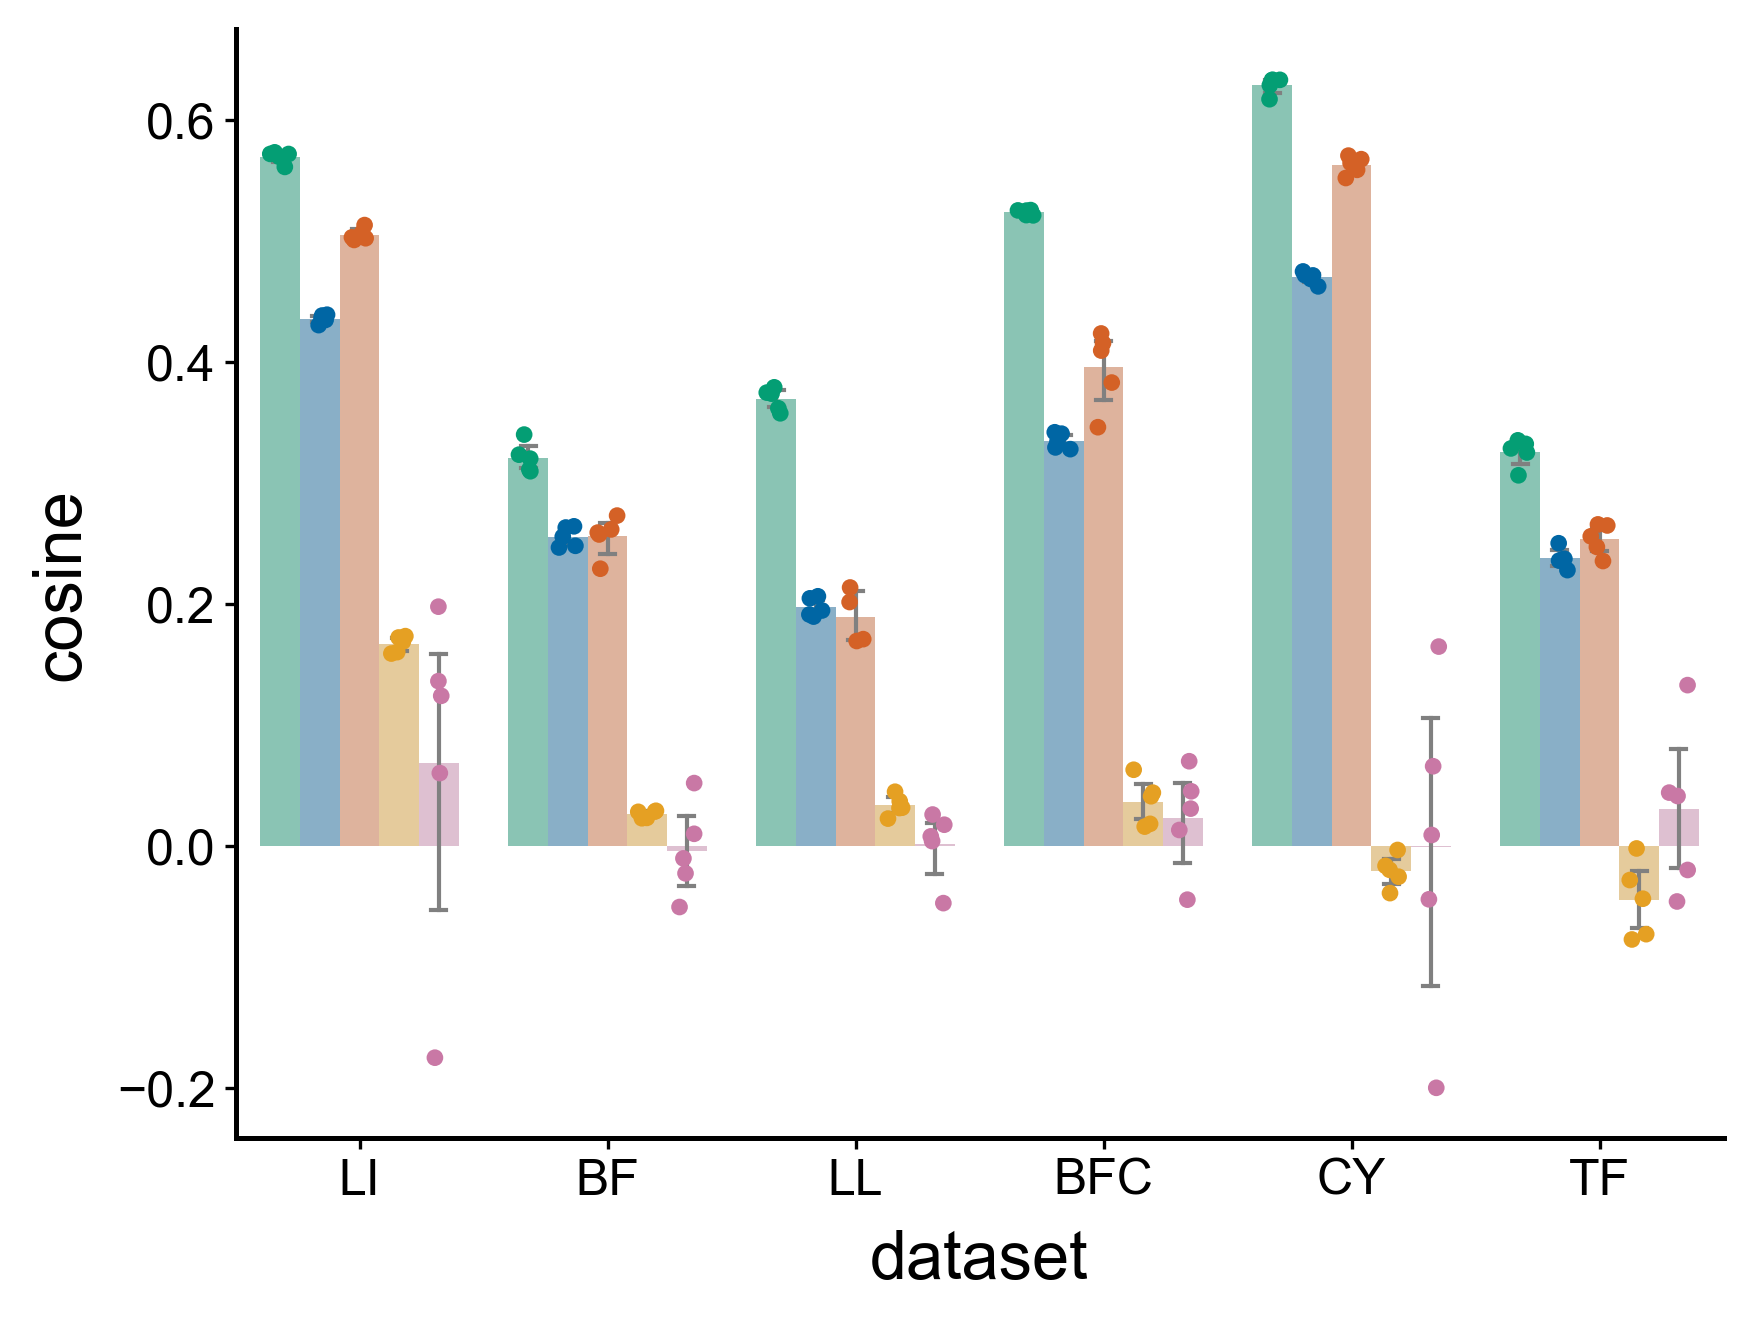

In [9]:

plt.figure(figsize=(6.4, 4.8), dpi=300)


palette = {
    'GOT':'#049e74',
    'OT-CFM':'#0066a4',
    'MIOFlow': '#d46126',
    'TrajectoryNet':'#e5a023',
    'TIGON': '#c978a5',     
}
# 先画条形图
ax = sns.barplot(
    data=plot_df2,
    x='dataset', 
    y='cosine',
    hue='method',
    legend=False, 
    capsize=.3,
    err_kws={"linewidth": 1., 'color':'grey'},
    palette=palette,
    
    hue_order=['GOT', 'OT-CFM', 'MIOFlow', 'TrajectoryNet', 'TIGON'],
    order=['LI', 'BF', 'LL', 'BFC', 'CY', 'TF'],
    alpha=0.5,
    
)

# 再叠加抖动点图
sns.stripplot(
    data=plot_df2,
    x='dataset', 
    y='cosine',
    hue='method',
    
    dodge=True,  # 分开展示不同方法
    jitter=0.2,  # 控制抖动幅度
    
    palette=palette, 
    alpha=1.,
    legend=False,
    #ax=ax,
    size=4,
    
    hue_order=['GOT', 'OT-CFM', 'MIOFlow', 'TrajectoryNet', 'TIGON'],
    order=['LI', 'BF', 'LL', 'BFC', 'CY', 'TF']
)


In [133]:
#plot_df.to_csv('./results/01.1_velocity/synthetic_result.csv')

### Visualization

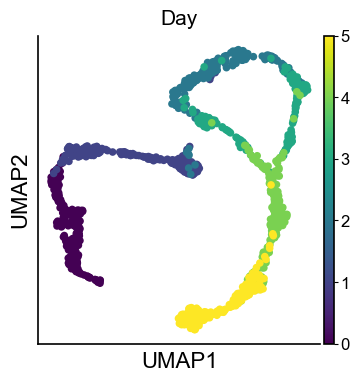

In [10]:
i = 3
adata, ref_network, pool = experiment('../pygot_data/01_velocity/simulation/inputs/Synthetic/dyn-' + datasets[i] + '_velo' , split_k=days[i])
velo = pd.read_csv('../pygot_data/01_velocity/simulation/inputs/Synthetic/dyn-'+ datasets[i] + '_velo/VelocityData.csv', index_col=0)
true_v = velo.to_numpy().T

sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='Day')

In [11]:
import TrajectoryNet

Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
Use ad

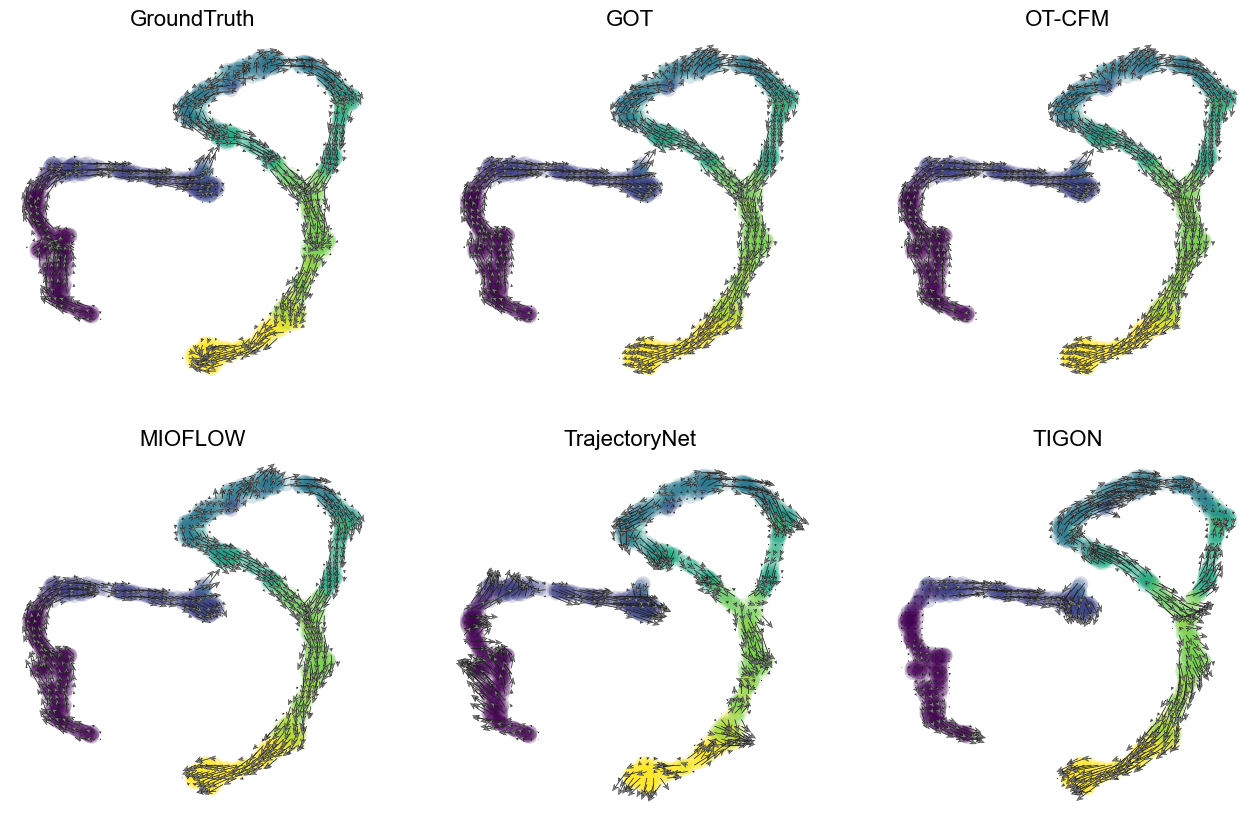

In [12]:
embedding_key = 'X_origin'
velocity_key = 'velocity_origin'
from pygot.external import TIGONwrapper


vis_key = 'umap'
from pygot.tools.traj.model_training import ODEwrapper, ODEwrapperNoTime, MLP
from MIOFlow.models import make_model
fig, axes = plt.subplots(2,3, figsize=(16,10))
adata.obsm[embedding_key] = adata.X 
adata.obsm[velocity_key] = true_v
adata.layers['velocity'] = true_v
pygot.tl.traj.velocity_graph(adata, embedding_key=embedding_key, velocity_key=velocity_key)
adata.obs[time_key] = adata.obs[time_key].astype(int)

scv.pl.velocity_embedding_grid(adata, show=False, 
                                   arrow_size=3, arrow_length=5, title='GroundTruth', ax=axes[0][0],basis=vis_key,
                                 color=time_key, palette='viridis')
del adata.obsm['velocity_'+vis_key]
#TIGON
j=0
embedding_key = 'X_origin'
tigon = TIGONwrapper(torch.load('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'tigon.pkl', map_location='cpu'))
tigon.time_varying = True
pred_v = pygot.tl.traj.latent_velocity(adata, tigon, embedding_key='X_origin', time_key=time_key)
adata.obsm[velocity_key] = pred_v
adata.layers['velocity'] = pred_v
pygot.tl.traj.velocity_graph(adata, embedding_key=embedding_key, velocity_key=velocity_key)
scv.pl.velocity_embedding_grid(adata, show=False, 
                                   arrow_size=3, arrow_length=5, title='TIGON',ax=axes[1][2],basis=vis_key,
                                 color=time_key)
del adata.obsm['velocity_'+vis_key]

#TrajectoryNet
tj_model = torch.load('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'trajectorynet.pkl', map_location='cpu')
tj_model.func.time_varying = False
#tj_model = ODEwrapperNoTime(torch.load('./results/01.1_velocity/unified/'+datasets[i]+'/TrajectoryNet_{}/model.pkl'.format(j)))
#tj_model.func.time_varying = False
pred_v = pygot.tl.traj.latent_velocity(adata, tj_model, embedding_key='X_origin')
adata.obsm[velocity_key] = pred_v
adata.layers['velocity'] = pred_v
pygot.tl.traj.velocity_graph(adata, embedding_key=embedding_key, velocity_key=velocity_key)
scv.pl.velocity_embedding_grid(adata,  show=False, 
                                   arrow_size=3, arrow_length=5,title='TrajectoryNet',ax=axes[1][1],basis=vis_key,
                                 color=time_key)
del adata.obsm['velocity_'+vis_key]

        
#GOT
model = ODEwrapper(MLP(dim=len(adata.var.index), time_varying=True))
model.load_state_dict(torch.load('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'got.pth', map_location='cpu'))

pred_v = pygot.tl.traj.latent_velocity(adata, model, embedding_key='X_origin', time_key=time_key)
adata.obsm[velocity_key] = pred_v
adata.layers['velocity'] = pred_v
pygot.tl.traj.velocity_graph(adata, embedding_key=embedding_key, velocity_key=velocity_key)
scv.pl.velocity_embedding_grid(adata, show=False, 
                                   arrow_size=3, arrow_length=5,title='GOT',ax=axes[0][1],basis=vis_key, 
                                 color=time_key)
del adata.obsm['velocity_'+vis_key]

#OT-CFM
cfm_model = ODEwrapper(MLP(dim=len(adata.var.index), time_varying=True))
        
cfm_model.load_state_dict(torch.load('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'cfm.pth', map_location='cpu'))


pred_v = pygot.tl.traj.latent_velocity(adata, cfm_model, embedding_key='X_origin', time_key=time_key)
adata.obsm[velocity_key] = pred_v
adata.layers['velocity'] = pred_v
scv.pl.velocity_embedding_grid(adata,show=False, 
                                   arrow_size=3, arrow_length=5,title='OT-CFM',ax=axes[0][2],basis=vis_key,
                                 color=time_key)
del adata.obsm['velocity_'+vis_key]
 
#MIOFlow
mioflow_model = make_model(
            len(adata.var.index), [16,32,16], 
            activation='CELU', scales=None, use_cuda=use_cuda,
            n_aug=0
        )
mioflow_model.load_state_dict(torch.load('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'mioflow.pth', map_location='cpu'))
mioflow_model.func.seq.time_varying = True
pred_v = pygot.tl.traj.latent_velocity(adata, mioflow_model.func.seq, embedding_key='X_origin', time_key=time_key)
adata.obsm[velocity_key] = pred_v
adata.layers['velocity'] = pred_v
pygot.tl.traj.velocity_graph(adata, embedding_key=embedding_key, velocity_key=velocity_key)
scv.pl.velocity_embedding_grid(adata, show=False, 
                                   arrow_size=3, arrow_length=5,title='MIOFLOW',ax=axes[1][0], basis=vis_key,
                                 color=time_key)
del adata.obsm['velocity_'+vis_key]



[]

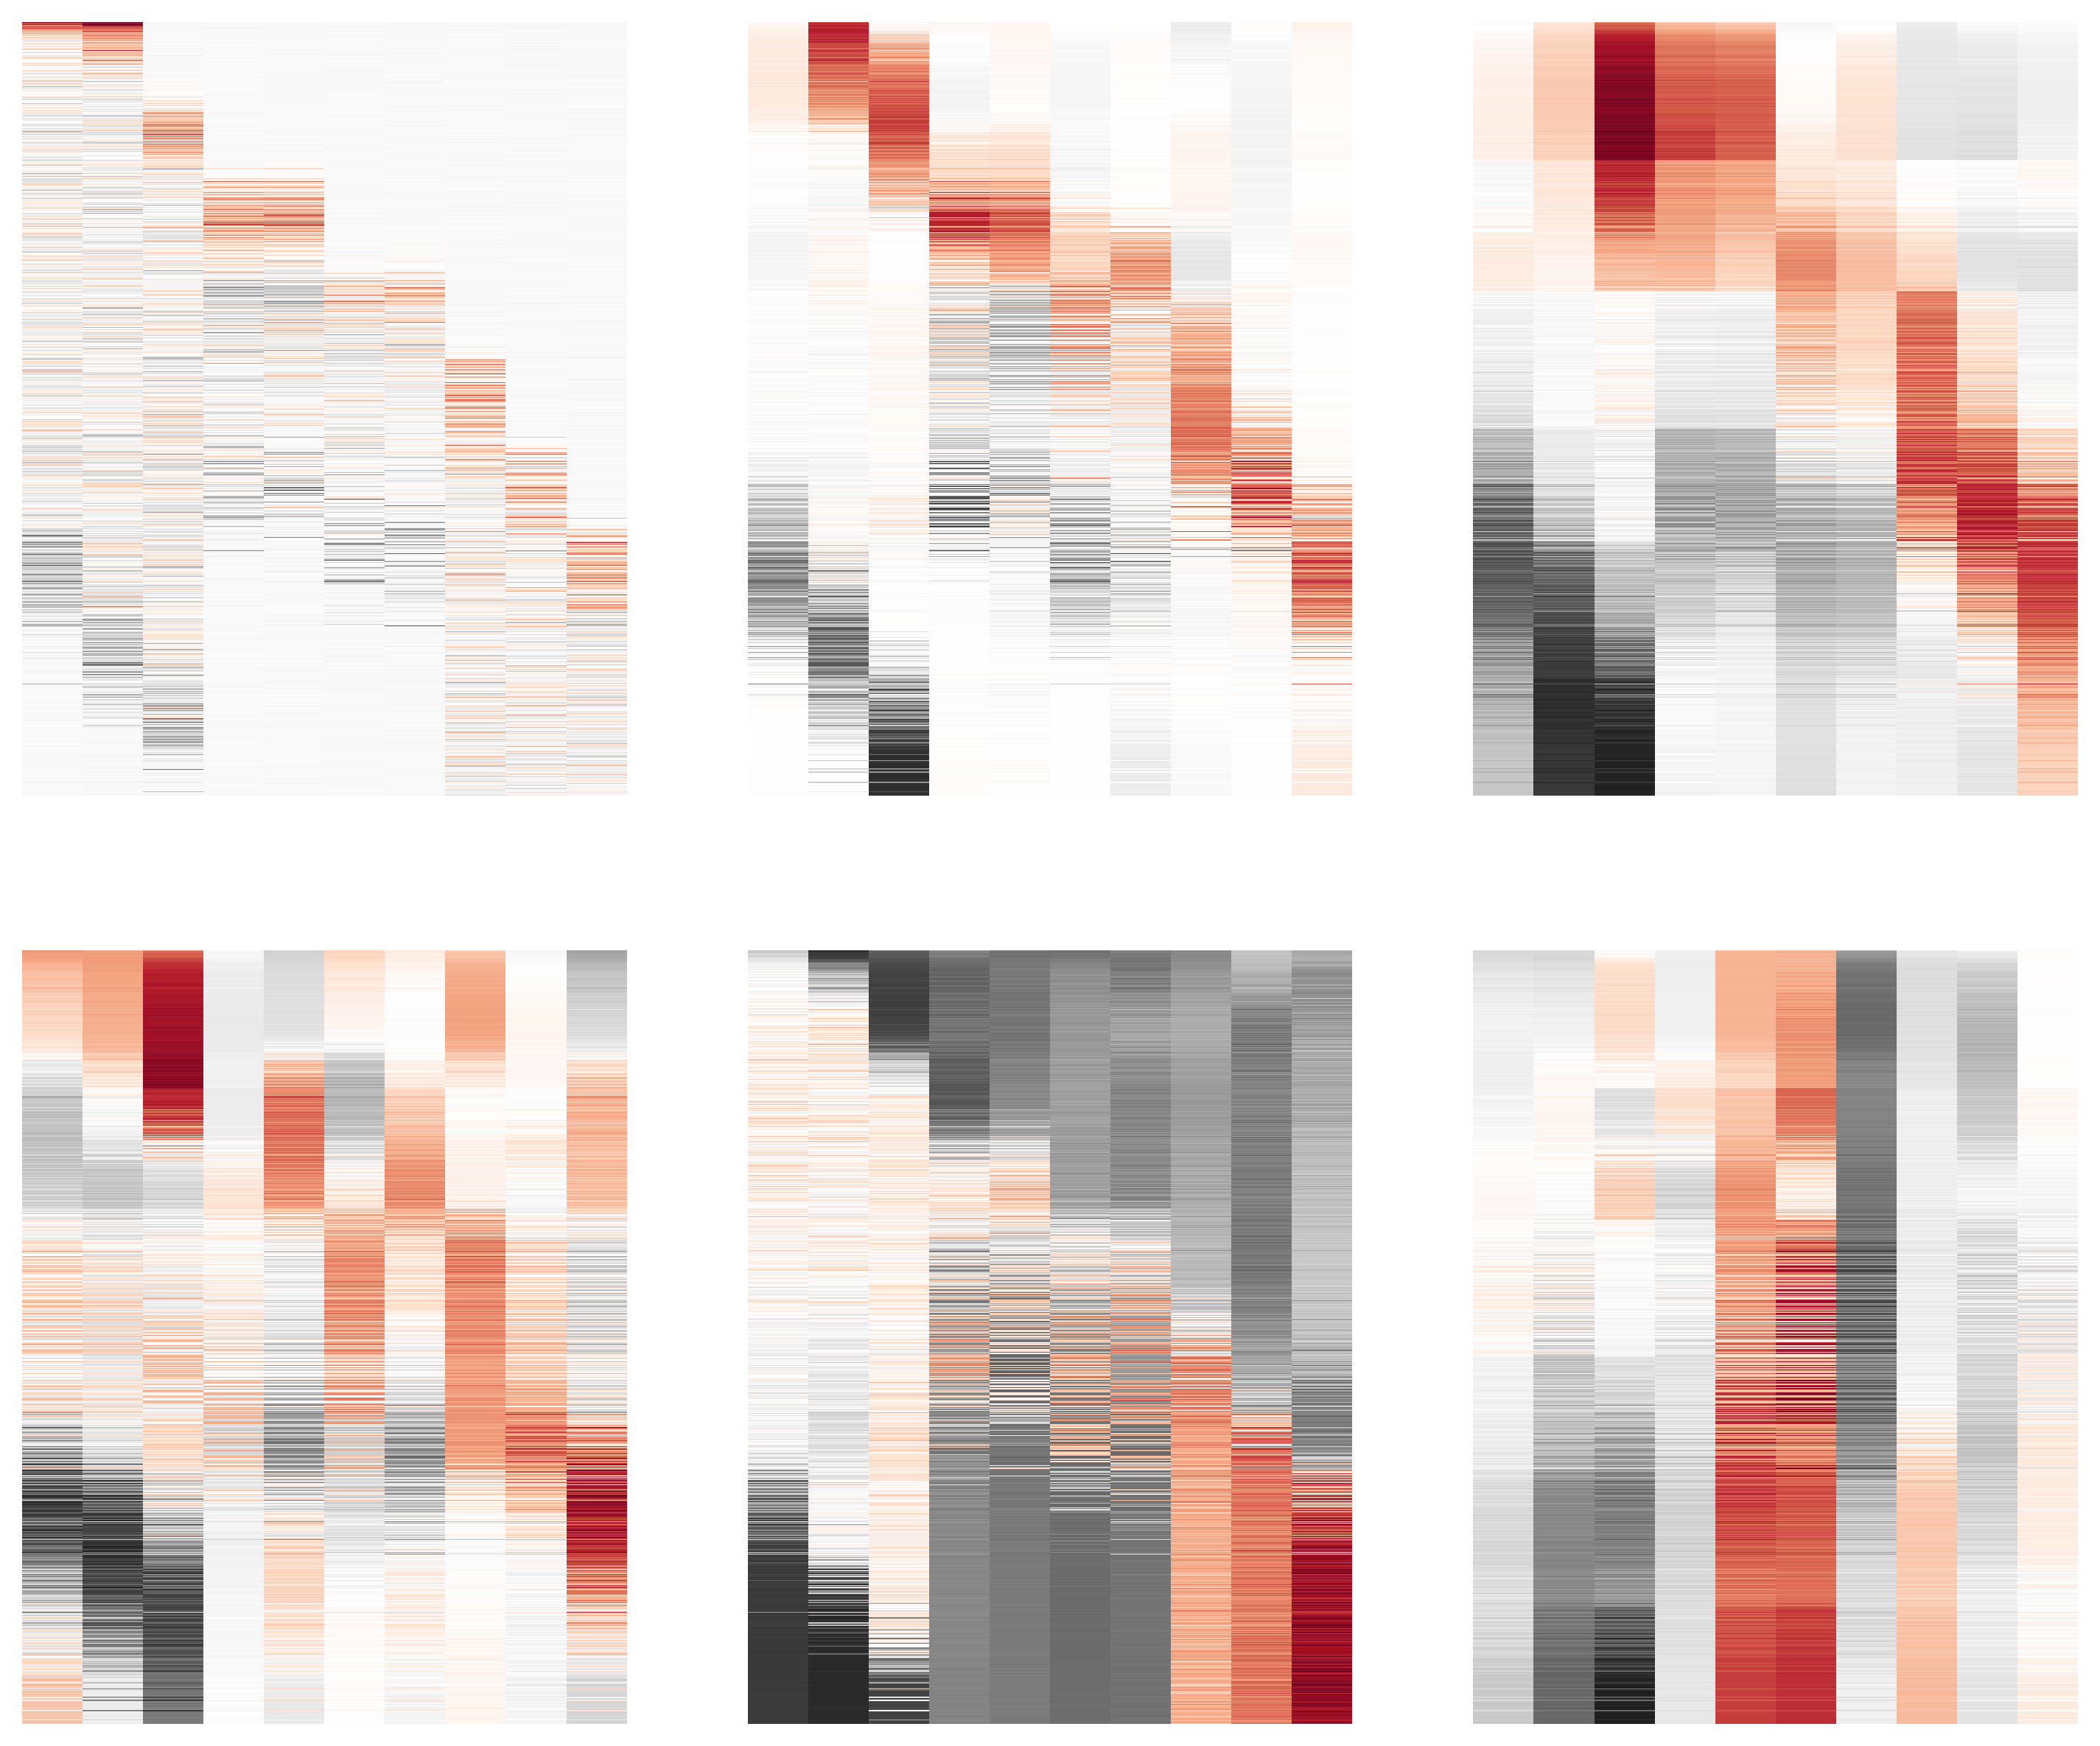

In [13]:

from pygot.tools.traj.model_training import ODEwrapper, ODEwrapperNoTime, MLP
from MIOFlow.models import make_model
from pygot.tools.traj.model_training import ODEwrapperNoTime
from pygot.external import TIGONwrapper
import torch
import pygot
%matplotlib inline
gene_order = [0, 2,3,4,5,6,7,8,9,1]
use_cuda = False
cmap = 'RdGy_r'
adata.obsm['true_velocity'] = true_v
velocity_key = 'velocity_origin'


fig, axes = plt.subplots(2,3, figsize=(12,10), dpi=300) 
adata.obsm[embedding_key] = adata.X 
adata.obsm[velocity_key] = true_v
adata.layers['velocity'] = true_v

sns.heatmap(adata[adata.obs.sort_values('Time').index].obsm['true_velocity'][:,gene_order], ax=axes[0][0], cbar=False, cmap=cmap)
axes[0][0].set_title('')
#TIGON
j=0
embedding_key = 'X_origin'
tigon = TIGONwrapper(torch.load('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'tigon.pkl', map_location='cpu'))
tigon.time_varying = True
pred_v = pygot.tl.traj.latent_velocity(adata, tigon, embedding_key='X_origin', time_key=time_key)
adata.obsm[velocity_key] = pred_v
adata.layers['velocity'] = pred_v

sns.heatmap(adata[adata.obs.sort_values('Time').index].obsm[velocity_key][:,gene_order], ax=axes[1][2], cbar=False, cmap=cmap)


axes[1][2].set_title('')
#TrajectoryNet
tj_model = torch.load('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'trajectorynet.pkl', map_location='cpu')
tj_model.func.time_varying = False
#tj_model = ODEwrapperNoTime(torch.load('./results/01.1_velocity/'+datasets[i]+'/TrajectoryNet_{}/model.pkl'.format(j)))
#tj_model.func.time_varying = False
pred_v = pygot.tl.traj.latent_velocity(adata, tj_model, embedding_key='X_origin')
adata.obsm[velocity_key] = pred_v
adata.layers['velocity'] = pred_v


sns.heatmap(adata[adata.obs.sort_values('Time').index].obsm[velocity_key][:,gene_order], ax=axes[1][1], cbar=False, cmap=cmap)      
axes[1][1].set_title('')
#GOT
model = ODEwrapper(MLP(dim=len(adata.var.index), time_varying=True))
model.load_state_dict(torch.load('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'got.pth', map_location='cpu'))

pred_v = pygot.tl.traj.latent_velocity(adata, model, embedding_key='X_origin', time_key=time_key)
adata.obsm[velocity_key] = pred_v
adata.layers['velocity'] = pred_v

sns.heatmap(adata[adata.obs.sort_values('Time').index].obsm[velocity_key][:,gene_order], ax=axes[0][1], cbar=False, cmap=cmap)
axes[0][1].set_title('')
#OT-CFM
cfm_model = ODEwrapper(MLP(dim=len(adata.var.index), time_varying=True))
cfm_model.load_state_dict(torch.load('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'cfm.pth', map_location='cpu'))

pred_v = pygot.tl.traj.latent_velocity(adata, cfm_model, embedding_key='X_origin', time_key=time_key)
adata.obsm[velocity_key] = pred_v
adata.layers['velocity'] = pred_v

sns.heatmap(adata[adata.obs.sort_values('Time').index].obsm[velocity_key][:,gene_order], ax=axes[0][2], cbar=False, cmap=cmap)
axes[0][2].set_title('')
#MIOFlow
mioflow_model = make_model(
            len(adata.var.index), [16,32,16], 
            activation='CELU', scales=None, use_cuda=use_cuda,
            n_aug=0
        )
mioflow_model.load_state_dict(torch.load('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'mioflow.pth', map_location='cpu'))
mioflow_model.func.seq.time_varying = True
pred_v = pygot.tl.traj.latent_velocity(adata, mioflow_model.func.seq, embedding_key='X_origin', time_key=time_key)
adata.obsm[velocity_key] = pred_v
adata.layers['velocity'] = pred_v
sns.heatmap(adata[adata.obs.sort_values('Time').index].obsm[velocity_key][:,gene_order], ax=axes[1][0], cbar=False, cmap=cmap)
axes[1][0].set_title('')




axes[0][0].set_xticks([])
axes[0][0].set_yticks([])


axes[0][1].set_xticks([])
axes[0][1].set_yticks([])

axes[0][2].set_xticks([])
axes[0][2].set_yticks([])

axes[1][0].set_xticks([])
axes[1][0].set_yticks([])

axes[1][1].set_xticks([])
axes[1][1].set_yticks([])

axes[1][2].set_xticks([])
axes[1][2].set_yticks([])




# Curated

In [14]:

from experimental import *

datasets = ['HSC', 'mCAD', 'GSD', 'VSC']
days = [6,6,6,6]
embedding_key = 'X_origin'
time_key = 'Day'
experiment_rep = 5

In [ ]:
from pygot.tools.traj.model_training import ODEwrapperNoTime
from pygot.external import TIGONwrapper
for i in range(len(datasets)):
    adata, ref_network, pool = experiment('../pygot_data/01_velocity/simulation/inputs/Curated/' + datasets[i] + '_velo' , split_k=days[i])
    velo = pd.read_csv('../pygot_data/01_velocity/simulation/inputs/Curated/'+ datasets[i] + '_velo/VelocityData.csv', index_col=0)
    true_v = velo.to_numpy().T
    print(datasets[i])
    os.makedirs('./results/01.1_velocity/unified/'+datasets[i], exist_ok=True)
    for j in range(experiment_rep):
        #GOT         
        model, history = pygot.tl.traj.fit_velocity_model(
            adata, time_key, embedding_key, 
            v_centric_iter_n=500, x_centric_iter_n=1000,
        )
        
        torch.save(model.state_dict(), './results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'got.pth')
        
        #TrajectoryNet
        ts = np.sort(np.unique(adata.obs[time_key]))
        ts_map = dict(zip(ts, range(len(ts))))
        
        adata.obs["sample_labels"] = adata.obs[time_key].replace(ts_map)
        sc.write('./results/01.1_velocity/unified/'+datasets[i]+'/adata_trajectorynet.h5ad', adata)
        
        tj_model = ODEwrapperNoTime(TrajectoryNet_interface('./results/01.1_velocity/unified/'+datasets[i]+'/adata_trajectorynet.h5ad', 
                                                                         './results/01.1_velocity/unified/'+datasets[i]+'/TrajectoryNet_{}/'.format(j),
                                                                         embedding_key='origin', dim=adata.obsm['X_origin'].shape[1],
                                                                         n_iter=1500))
        torch.save(tj_model, './results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'trajectorynet.pkl')
        
        #TIGON
        tigon = pygot.external.TIGON_interface(adata, time_key, embedding_key, device,
                    niters=1500, lr=3e-3, num_samples=100, hidden_dim=16,
                    n_hiddens=2, activation='Tanh', max_patience=10)
        
        torch.save(tigon, './results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'tigon.pkl')
    
        
        
        #OT-CFM
        cfm_model, _ = pygot.external.OTCFM_interface(adata, time_key, embedding_key, device, iter_n=1500)
        torch.save(cfm_model.state_dict(), './results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'cfm.pth')

        
        #MIOFlow
        mioflow_model, traj = pygot.external.MIOFlow_interface(
            adata, embedding_key, time_key, exp_dir='/mnt/d/tmp', 
             hold_out=0, hold_one_out=False, use_density_loss=True)
    
        torch.save(mioflow_model.state_dict(), './results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'mioflow.pth')


HSC
loading saved shortest path profile
[Errno 2] No such file or directory: '/_0to1.pkl'
Error in loading shortest path file
calcu shortest path between 0 to 1


100%|██████████████████████████████████████████████████████████████████████████████| 169/169 [00:00<00:00, 853.89it/s]


calcu shortest path between 1 to 2


100%|█████████████████████████████████████████████████████████████████████████████| 181/181 [00:00<00:00, 3147.81it/s]


calcu shortest path between 2 to 3


100%|█████████████████████████████████████████████████████████████████████████████| 183/183 [00:00<00:00, 4109.64it/s]


calcu shortest path between 3 to 4


100%|█████████████████████████████████████████████████████████████████████████████| 162/162 [00:00<00:00, 4237.75it/s]


calcu shortest path between 4 to 5


loss :5.6743  best :5.5615: 100%|█████████████████████████████████████████████████| 1000/1000 [01:04<00:00, 15.41it/s]
/disk/xuruihong/miniconda3/envs/got/lib/python3.10/site-packages/TrajectoryNet/main.py
""" main.py

Learns ODE from scrna data

"""
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn.functional as F
import torch.optim as optim

from TrajectoryNet.lib.growth_net import GrowthNet
from TrajectoryNet.lib import utils
from TrajectoryNet.lib.visualize_flow import visualize_transform
from TrajectoryNet.lib.viz_scrna import (
    save_trajectory,
    trajectory_to_video,
    save_vectors,
)
from TrajectoryNet.lib.viz_scrna import save_trajectory_density


# from train_misc import standard_normal_logprob
from TrajectoryNet.train_misc import (
    set_cnf_options,
    count_nfe,
    count_parameters,
    count_total_time,
    add_spectral_norm,
    spectral_norm_power_iteration,
    create_regularization_fns,


True
Could not find entry in `obsm` for 'velocity_origin'.
Available keys are: ['X_origin'].
Assuming no velocity data.
Density Loss 0.2850326895713806
Density Loss 0.2882852256298065
Density Loss 0.2784111499786377
Density Loss 0.2754718065261841
Density Loss 0.2688944339752197
Density Loss 0.2718258202075958
Density Loss 0.2635224461555481
Density Loss 0.26347798109054565
Density Loss 0.25713470578193665
Density Loss 0.2606506049633026
Density Loss 0.2596704065799713
Density Loss 0.25169023871421814
Density Loss 0.2541561722755432
Density Loss 0.24834272265434265
Density Loss 0.24956835806369781
Density Loss 0.2458668351173401
Density Loss 0.2426898330450058
Density Loss 0.2411385178565979
Density Loss 0.24123144149780273
Density Loss 0.23247919976711273
Density Loss 0.23607780039310455
Density Loss 0.2344181388616562
Density Loss 0.2333521842956543
Density Loss 0.2264917641878128
Density Loss 0.22158153355121613
Density Loss 0.22178681194782257
Density Loss 0.22533583641052246
Densi

Iter 0249 | Time 1.0086(1.0383) | Loss 12.748652(12.840598) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0250 | Time 0.9872(1.0347) | Loss 12.758108(12.834824) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0251 | Time 1.0210(1.0337) | Loss 12.735931(12.827901) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0252 | Time 0.9311(1.0265) | Loss 12.703629(12.819202) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0253 | Time 0.8989(1.0176) | Loss 12.698846(12.810777) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0254 | Time 0.9624(1.0137) | Loss 12.662506(12.800398) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0255 | Time 0.8586(1.0029) | Loss 12.677230(12.791776) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0256 | Time 0.9157(0.9968) | Loss 12.656830(12.782330) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0257 | Time 0.9375(0.9926) | Loss 12.697500(12.776392) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0258 | Time 0.9717(0.9912) | Loss 12.692390(12.770

0.5394726395606995
Density Loss 0.5378941893577576
Density Loss 0.5384950041770935
Density Loss 0.5395922660827637
Density Loss 0.5361475348472595
Density Loss 0.5339807868003845
Density Loss 0.5321447849273682
Density Loss 0.5339242815971375
Density Loss 0.5258890390396118
Density Loss 0.5289850234985352
Density Loss 0.5288156270980835
Density Loss 0.5303207635879517
Density Loss 0.5255922675132751
Density Loss 0.5256488919258118
Density Loss 0.5226135849952698
Density Loss 0.5189043879508972
Density Loss 0.5208894610404968
Density Loss 0.517594039440155
Density Loss 0.5107095837593079
Density Loss 0.5251321196556091
Density Loss 0.5163594484329224
Density Loss 0.5132154822349548
Density Loss 0.515087902545929
Density Loss 0.5084060430526733
Density Loss 0.5109634399414062
Density Loss 0.5042813420295715
Density Loss 0.5070725679397583
Density Loss 0.5096176862716675
Density Loss 0.5005753040313721
Density Loss 0.5001515746116638
Density Loss 0.5008670687675476
Density Loss 0.49964863

Iter 0500 | Time 0.8588(0.9138) | Loss 6.828094(7.081764) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
[TEST] Iter 0500 | Test Loss 6.622646 | NFE 4
Skipping vis as data dimension is >2
Iter 0501 | Time 0.9191(0.9142) | Loss 6.610490(7.048775) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0502 | Time 0.8066(0.9066) | Loss 6.531508(7.012566) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0503 | Time 0.8431(0.9022) | Loss 6.553653(6.980442) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0504 | Time 0.8882(0.9012) | Loss 6.578486(6.952305) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0505 | Time 0.8706(0.8991) | Loss 6.785330(6.940617) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0506 | Time 0.8392(0.8949) | Loss 6.771298(6.928764) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0507 | Time 0.8877(0.8944) | Loss 6.448173(6.895123) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0508 | Time 0.9139(0.8957) | Loss 6.559015(6.871596) | NFE Forward 4(4.0) | NFE Backward

0.49403074383735657
Density Loss 0.4939262568950653
Density Loss 0.4920908212661743
Density Loss 0.4963580369949341
Density Loss 0.49549540877342224
Density Loss 0.48807477951049805
Density Loss 0.4965512156486511
Density Loss 0.49824661016464233
Density Loss 0.4969388544559479
Density Loss 0.50648033618927
Density Loss 0.5071220397949219
Density Loss 0.4992356300354004
Density Loss 0.5000824928283691
Density Loss 0.5006412863731384
Density Loss 0.4989701509475708
Density Loss 0.5004314184188843
Density Loss 0.500109851360321
Density Loss 0.5084831118583679
Density Loss 0.5095717906951904
Density Loss 0.5042479634284973
Density Loss 0.5014061331748962
Density Loss 0.4983889162540436
Density Loss 0.5219823122024536
Density Loss 0.5007717609405518
Density Loss 0.5067163705825806
Density Loss 0.5084248185157776
Density Loss 0.5080708861351013
Density Loss 0.5150416493415833
Density Loss 0.506129264831543
Density Loss 0.5080391764640808
Density Loss 0.5160963535308838
Density Loss 0.516962

Iter 0754 | Time 1.0026(0.9249) | Loss 4.388001(4.441117) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0755 | Time 0.9238(0.9248) | Loss 4.737450(4.461860) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0756 | Time 0.8632(0.9205) | Loss 4.182342(4.442294) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0757 | Time 1.0627(0.9304) | Loss 4.565271(4.450902) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0758 | Time 0.9619(0.9326) | Loss 4.509264(4.454988) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0759 | Time 0.9326(0.9326) | Loss 4.258306(4.441220) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0760 | Time 0.9973(0.9372) | Loss 4.431209(4.440519) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0761 | Time 0.9405(0.9374) | Loss 4.388022(4.436844) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0762 | Time 0.8758(0.9331) | Loss 4.212032(4.421107) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0763 | Time 0.8912(0.9302) | Loss 4.558090(4.430696) | NFE Forward 4

Density Loss 0.5750959515571594
Density Loss 0.5762172341346741
Density Loss 0.5760957598686218
Density Loss 0.5811650156974792
Density Loss 0.5740451812744141
Density Loss 0.5798890590667725
Density Loss 0.5843002796173096
Density Loss 0.5764877200126648
Density Loss 0.5675203204154968
Density Loss 0.5682328939437866
Density Loss 0.5684393644332886
Density Loss 0.5714498162269592
Density Loss 0.5683262348175049
Density Loss 0.5702131986618042
Density Loss 0.5635932087898254
Density Loss 0.5640711784362793
Density Loss 0.5772072076797485
Density Loss 0.5770170092582703
Density Loss 0.5679401159286499
Density Loss 0.5709307193756104
Density Loss 0.5750983953475952
Density Loss 0.5735553503036499
Density Loss 0.56827312707901
Density Loss 0.5680993795394897
Density Loss 0.5673080086708069
Density Loss 0.5713264346122742
Density Loss 0.5635479092597961
Density Loss 0.5817684531211853
Density Loss 0.5611985325813293
Density Loss 0.5693827867507935
Density Loss 0.5714261531829834
Density Lo

Iter 1007 | Time 0.8877(1.0762) | Loss 3.317181(3.200302) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1008 | Time 0.9094(1.0646) | Loss 2.903318(3.179513) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1009 | Time 1.0189(1.0614) | Loss 3.370786(3.192903) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1010 | Time 0.9098(1.0507) | Loss 2.886909(3.171483) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1011 | Time 0.9354(1.0427) | Loss 3.465353(3.192054) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1012 | Time 0.8837(1.0315) | Loss 3.014874(3.179651) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1013 | Time 0.8861(1.0214) | Loss 3.352707(3.191765) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1014 | Time 1.1501(1.0304) | Loss 3.333338(3.201675) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1015 | Time 1.2746(1.0475) | Loss 2.898326(3.180441) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1016 | Time 1.0186(1.0455) | Loss 3.273662(3.186966) | NFE Forward 4

0.6095918416976929
Density Loss 0.6195411682128906
Density Loss 0.6112374067306519
Density Loss 0.6242960691452026
Density Loss 0.6076056361198425
Density Loss 0.6110243201255798
Density Loss 0.6254429817199707
Density Loss 0.6266568899154663
Density Loss 0.6258370876312256
Density Loss 0.6126179099082947
Density Loss 0.6175231337547302
Density Loss 0.6248339414596558
Density Loss 0.6111329197883606
Density Loss 0.609475314617157
Density Loss 0.6096519231796265
Density Loss 0.6253214478492737
Density Loss 0.6178134083747864
Density Loss 0.6054760813713074
Density Loss 0.6226955652236938
Density Loss 0.6151456832885742
Density Loss 0.6163991093635559
Density Loss 0.6155160069465637
Density Loss 0.6228035092353821
Density Loss 0.6099357008934021
Density Loss 0.6155163049697876
Density Loss 0.6218246221542358
Density Loss 0.6304763555526733
Density Loss 0.6280750632286072
Density Loss 0.6317057609558105
Density Loss 0.6219371557235718
Density Loss 0.6277028918266296
Density Loss 0.6253759

Iter 1262 | Time 0.9027(0.9153) | Loss 2.453698(2.587552) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1263 | Time 0.9038(0.9145) | Loss 2.686582(2.594484) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1264 | Time 0.8897(0.9127) | Loss 2.417169(2.582072) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1265 | Time 0.8827(0.9106) | Loss 3.098206(2.618201) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1266 | Time 0.9058(0.9103) | Loss 2.935179(2.640390) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1267 | Time 0.8639(0.9070) | Loss 2.628762(2.639576) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1268 | Time 0.9797(0.9121) | Loss 2.576359(2.635151) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1269 | Time 0.8887(0.9105) | Loss 2.688251(2.638868) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1270 | Time 0.9298(0.9118) | Loss 2.828801(2.652163) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1271 | Time 0.9972(0.9178) | Loss 2.437181(2.637114) | NFE Forward 4

Density Loss 0.6854408383369446
Density Loss 0.6839688420295715
Density Loss 0.6952693462371826
Density Loss 0.692296028137207
Density Loss 0.6782978177070618
Density Loss 0.6947360038757324
Density Loss 0.6856708526611328
Density Loss 0.6928921937942505
Density Loss 0.6999232172966003
Density Loss 0.7097854614257812
Density Loss 0.7007723450660706
Density Loss 0.7048823833465576
Density Loss 0.6825785040855408
Density Loss 0.6843578219413757
Density Loss 0.6926774978637695
Density Loss 0.691585898399353
Density Loss 0.6952409148216248
Density Loss 0.7064163088798523
Density Loss 0.6998514533042908
Density Loss 0.7057308554649353
Density Loss 0.6999265551567078
Density Loss 0.6957082748413086
Density Loss 0.7040526270866394
Density Loss 0.7022462487220764
Density Loss 0.699724018573761
Density Loss 0.7024588584899902
Density Loss 0.7085695862770081
Density Loss 0.7109277844429016
Density Loss 0.6951088905334473
Density Loss 0.6929658055305481
Density Loss 0.6926393508911133
Density Los

loss :0.1449 best :0.1438: 100%|██████████████████████████████████████████████████| 1500/1500 [01:36<00:00, 15.58it/s]


Pretraining Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.51156


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.03768


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.46897


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.80052


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.46419


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.79256


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.17379


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.49083


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.07832


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.55964


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.17931


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.30356


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.02528


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.33883


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 3.90954


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.13391


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 3.88062


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.07788


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 3.81842


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 3.99125


Epoch:   0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 15.01946


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 15.94519


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.7516


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 15.73726


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.72347


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 15.223


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.47604


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 15.01359


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.80798


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.62909


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.30432


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.64323


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.9747


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.48273


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.61416


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.03553


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.41617


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.6136


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.23402


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.41178


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.43802


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.68225


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.47989


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.56818


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.52591


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.38871


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.62819


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.46007


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.21666


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.33742


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.20481


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.2719


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.95734


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.90377


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.79132


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.34986


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.243


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.51918


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.2918


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.99749


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.2009


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.29897


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.05107


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.75607


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.98299


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.04461


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.48711


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.08149


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.78631


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.08111


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.75908


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.56257


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.26686


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.57144


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.4075


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.03633


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.89404


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.99191


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.80959


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.68305


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.54651


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.48412


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.35784


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.06589


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.35417


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.24692


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.86141


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.86151


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.70858


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.59565


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.82389


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.28844


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.72946


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.12433


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.87268


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.41047


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.2847


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.20173


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.2562


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.9885


Posttraining Epoch: 0it [00:00, ?it/s]

loading saved shortest path profile
[Errno 2] No such file or directory: '/_0to1.pkl'
Error in loading shortest path file
calcu shortest path between 0 to 1


100%|█████████████████████████████████████████████████████████████████████████████| 169/169 [00:00<00:00, 2139.57it/s]


calcu shortest path between 1 to 2


100%|█████████████████████████████████████████████████████████████████████████████| 181/181 [00:00<00:00, 2178.82it/s]


calcu shortest path between 2 to 3


100%|█████████████████████████████████████████████████████████████████████████████| 183/183 [00:00<00:00, 2802.96it/s]


calcu shortest path between 3 to 4


100%|█████████████████████████████████████████████████████████████████████████████| 162/162 [00:00<00:00, 2918.23it/s]


calcu shortest path between 4 to 5


loss :5.1095  best :5.0895: 100%|█████████████████████████████████████████████████| 1000/1000 [01:04<00:00, 15.57it/s]
/disk/xuruihong/miniconda3/envs/got/lib/python3.10/site-packages/TrajectoryNet/main.py
""" main.py

Learns ODE from scrna data

"""
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn.functional as F
import torch.optim as optim

from TrajectoryNet.lib.growth_net import GrowthNet
from TrajectoryNet.lib import utils
from TrajectoryNet.lib.visualize_flow import visualize_transform
from TrajectoryNet.lib.viz_scrna import (
    save_trajectory,
    trajectory_to_video,
    save_vectors,
)
from TrajectoryNet.lib.viz_scrna import save_trajectory_density


# from train_misc import standard_normal_logprob
from TrajectoryNet.train_misc import (
    set_cnf_options,
    count_nfe,
    count_parameters,
    count_total_time,
    add_spectral_norm,
    spectral_norm_power_iteration,
    create_regularization_fns,


True
Could not find entry in `obsm` for 'velocity_origin'.
Available keys are: ['X_origin'].
Assuming no velocity data.
Density Loss 0.2747825086116791
Density Loss 0.2752418518066406
Density Loss 0.2656100392341614
Density Loss 0.26382705569267273
Density Loss 0.2626054883003235
Density Loss 0.2616589069366455
Density Loss 0.2532498836517334
Density Loss 0.25196415185928345
Density Loss 0.2479899376630783
Density Loss 0.25001299381256104
Density Loss 0.25975605845451355
Density Loss 0.24862900376319885
Density Loss 0.23881658911705017
Density Loss 0.2456752061843872
Density Loss 0.24490641057491302
Density Loss 0.23732252418994904
Density Loss 0.2365012913942337
Density Loss 0.23680302500724792
Density Loss 0.23170487582683563
Density Loss 0.23153924942016602
Density Loss 0.2319338023662567
Density Loss 0.22721552848815918
Density Loss 0.2268969714641571
Density Loss 0.21757210791110992
Density Loss 0.2206406146287918
Density Loss 0.2246556133031845
Density Loss 0.2236233353614807
Den

Iter 0247 | Time 0.9006(0.9510) | Loss 11.998616(12.183027) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0248 | Time 0.8979(0.9473) | Loss 12.007010(12.170706) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0249 | Time 0.9591(0.9481) | Loss 12.003004(12.158966) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0250 | Time 0.8999(0.9448) | Loss 11.979771(12.146423) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0251 | Time 0.8945(0.9412) | Loss 11.916531(12.130330) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0252 | Time 0.8419(0.9343) | Loss 11.921735(12.115729) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0253 | Time 1.0137(0.9398) | Loss 11.902301(12.100789) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0254 | Time 0.9178(0.9383) | Loss 11.889460(12.085996) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0255 | Time 0.9023(0.9358) | Loss 11.859233(12.070122) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0256 | Time 0.9335(0.9356) | Loss 11.829206(12.053

0.3221818208694458
Density Loss 0.317767471075058
Density Loss 0.3180244266986847
Density Loss 0.31773456931114197
Density Loss 0.3137628734111786
Density Loss 0.31391701102256775
Density Loss 0.32290178537368774
Density Loss 0.31389617919921875
Density Loss 0.3107959032058716
Density Loss 0.31391921639442444
Density Loss 0.3112110495567322
Density Loss 0.31219416856765747
Density Loss 0.30857908725738525
Density Loss 0.31365880370140076
Density Loss 0.3039288818836212
Density Loss 0.3058873116970062
Density Loss 0.3166153132915497
Density Loss 0.30372557044029236
Density Loss 0.30921655893325806
Density Loss 0.3037715256214142
Density Loss 0.31855130195617676
Density Loss 0.3189779222011566
Density Loss 0.30928513407707214
Density Loss 0.3028635084629059
Density Loss 0.30631157755851746
Density Loss 0.30930373072624207
Density Loss 0.3169204890727997
Density Loss 0.3164929747581482
Density Loss 0.31602951884269714
Density Loss 0.31579580903053284
Density Loss 0.33675605058670044
Densi

Iter 0498 | Time 0.8375(0.9166) | Loss 4.366605(4.598403) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0499 | Time 1.0513(0.9260) | Loss 4.285723(4.576516) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0500 | Time 0.9203(0.9256) | Loss 4.324665(4.558886) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
[TEST] Iter 0500 | Test Loss 4.226781 | NFE 4
Skipping vis as data dimension is >2
Iter 0501 | Time 1.0365(0.9334) | Loss 4.319164(4.542106) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0502 | Time 0.8913(0.9304) | Loss 4.454582(4.535979) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0503 | Time 0.8939(0.9279) | Loss 4.265519(4.517047) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0504 | Time 0.8777(0.9243) | Loss 4.351620(4.505467) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0505 | Time 0.8795(0.9212) | Loss 4.115157(4.478145) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0506 | Time 0.9282(0.9217) | Loss 4.608312(4.487257) | NFE Forward 4(4.0) | NFE Backward

Density Loss 0.5033302307128906
Density Loss 0.516384482383728
Density Loss 0.49533089995384216
Density Loss 0.5140973329544067
Density Loss 0.5124697685241699
Density Loss 0.5006556510925293
Density Loss 0.5116936564445496
Density Loss 0.5033543109893799
Density Loss 0.49974775314331055
Density Loss 0.506801962852478
Density Loss 0.5087858438491821
Density Loss 0.5011968612670898
Density Loss 0.48859691619873047
Density Loss 0.49566107988357544
Density Loss 0.5011478662490845
Density Loss 0.49547600746154785
Density Loss 0.5093973278999329
Density Loss 0.5229306221008301
Density Loss 0.5024250149726868
Density Loss 0.49575838446617126
Density Loss 0.5086026191711426
Density Loss 0.5093881487846375
Density Loss 0.5115775465965271
Density Loss 0.5235453844070435
Density Loss 0.5129801630973816
Density Loss 0.5296525955200195
Density Loss 0.515895426273346
Density Loss 0.5244938135147095
Density Loss 0.5007870197296143
Density Loss 0.49368923902511597
Density Loss 0.5110774636268616
Dens

Iter 0751 | Time 1.0295(0.9217) | Loss 2.669012(2.824490) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0752 | Time 0.9457(0.9234) | Loss 3.006186(2.837208) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0753 | Time 0.9930(0.9282) | Loss 2.732862(2.829904) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0754 | Time 0.9117(0.9271) | Loss 2.970018(2.839712) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0755 | Time 0.8737(0.9233) | Loss 3.036727(2.853503) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0756 | Time 0.9243(0.9234) | Loss 3.013367(2.864694) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0757 | Time 0.9816(0.9275) | Loss 3.063500(2.878610) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0758 | Time 0.9065(0.9260) | Loss 2.899729(2.880088) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0759 | Time 0.9319(0.9264) | Loss 2.791373(2.873878) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0760 | Time 0.9629(0.9290) | Loss 3.050613(2.886250) | NFE Forward 4

0.5512628555297852
Density Loss 0.5537376403808594
Density Loss 0.5672312378883362
Density Loss 0.5535426139831543
Density Loss 0.5530034303665161
Density Loss 0.5636853575706482
Density Loss 0.5767098665237427
Density Loss 0.5505582690238953
Density Loss 0.5505226254463196
Density Loss 0.5518569946289062
Density Loss 0.5532066226005554
Density Loss 0.5636662244796753
Density Loss 0.5648050308227539
Density Loss 0.5575476288795471
Density Loss 0.5688381195068359
Density Loss 0.5702739357948303
Density Loss 0.5401341915130615
Density Loss 0.5620524287223816
Density Loss 0.5650513768196106
Density Loss 0.5722925662994385
Density Loss 0.5649393796920776
Density Loss 0.5609114170074463
Density Loss 0.5815103650093079
Density Loss 0.5558307766914368
Density Loss 0.5565839409828186
Density Loss 0.5650176405906677
Density Loss 0.5616589188575745
Density Loss 0.5612261295318604
Density Loss 0.5685857534408569
Density Loss 0.5751940011978149
Density Loss 0.5576098561286926
Density Loss 0.564211

Iter 1005 | Time 0.9677(0.9239) | Loss 1.627045(1.707325) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1006 | Time 0.9057(0.9226) | Loss 1.599057(1.699746) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1007 | Time 0.8973(0.9209) | Loss 2.045676(1.723962) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1008 | Time 0.9474(0.9227) | Loss 1.476358(1.706629) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1009 | Time 0.9183(0.9224) | Loss 1.897984(1.720024) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1010 | Time 0.9640(0.9253) | Loss 1.474741(1.702854) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1011 | Time 0.9622(0.9279) | Loss 1.430592(1.683796) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1012 | Time 0.9016(0.9261) | Loss 1.574472(1.676143) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1013 | Time 0.9129(0.9251) | Loss 1.563987(1.668292) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1014 | Time 0.9183(0.9247) | Loss 1.573261(1.661640) | NFE Forward 4

0.5942644476890564
Density Loss 0.6113404035568237
Density Loss 0.6145360469818115
Density Loss 0.6153261661529541
Density Loss 0.6082836985588074
Density Loss 0.6151109933853149
Density Loss 0.5883859395980835
Density Loss 0.6136153340339661
Density Loss 0.6069239377975464
Density Loss 0.6157835721969604
Density Loss 0.6251218318939209
Density Loss 0.5948705077171326
Density Loss 0.6084253191947937
Density Loss 0.6215860247612
Density Loss 0.6131957769393921
Density Loss 0.6039016246795654
Density Loss 0.6081419587135315
Density Loss 0.6000773310661316
Density Loss 0.6345372796058655
Density Loss 0.5986727476119995
Density Loss 0.6193183660507202
Density Loss 0.608612060546875
Density Loss 0.6084921956062317
Density Loss 0.5966724753379822
Density Loss 0.6186890602111816
Density Loss 0.6216001510620117
Density Loss 0.6123749613761902
Density Loss 0.6184013485908508
Density Loss 0.6061823964118958
Density Loss 0.5975565314292908
Density Loss 0.5989479422569275
Density Loss 0.6356045007

Iter 1260 | Time 0.9431(0.9266) | Loss 0.999482(0.942406) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1261 | Time 0.9400(0.9275) | Loss 0.535174(0.913900) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1262 | Time 0.9450(0.9288) | Loss 0.946365(0.916173) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1263 | Time 0.9490(0.9302) | Loss 0.621969(0.895578) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1264 | Time 0.9520(0.9317) | Loss 0.692255(0.881346) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1265 | Time 0.9533(0.9332) | Loss 0.788649(0.874857) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1266 | Time 0.9171(0.9321) | Loss 0.632004(0.857857) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1267 | Time 0.8608(0.9271) | Loss 0.673826(0.844975) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1268 | Time 0.9502(0.9287) | Loss 0.478652(0.819333) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1269 | Time 0.9716(0.9317) | Loss 0.886307(0.824021) | NFE Forward 4

0.6607255339622498
Density Loss 0.6493015885353088
Density Loss 0.6315805912017822
Density Loss 0.645794689655304
Density Loss 0.6422671675682068
Density Loss 0.6402014493942261
Density Loss 0.626396656036377
Density Loss 0.6371787190437317
Density Loss 0.6372409462928772
Density Loss 0.6474671959877014
Density Loss 0.6393924355506897
Density Loss 0.6493510603904724
Density Loss 0.639325737953186
Density Loss 0.6294508576393127
Density Loss 0.6519340872764587
Density Loss 0.646345853805542
Density Loss 0.6541759967803955
Density Loss 0.6394867300987244
Density Loss 0.6378658413887024
Density Loss 0.6516933441162109
Density Loss 0.6406857371330261
Density Loss 0.6453263759613037
Density Loss 0.6435502767562866
Density Loss 0.648587167263031
Density Loss 0.6553618311882019
Density Loss 0.6412984132766724
Density Loss 0.6536784768104553
Density Loss 0.6606777310371399
Density Loss 0.6461122632026672
Density Loss 0.6594724655151367
Density Loss 0.6551050543785095
Density Loss 0.64046895503

loss :0.1428 best :0.1419: 100%|██████████████████████████████████████████████████| 1500/1500 [01:34<00:00, 15.90it/s]


Pretraining Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.7181


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.89477


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.2738


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.79365


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.2558


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.45147


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.22805


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.26363


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.08275


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.38996


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.00537


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.13182


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 3.85416


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.0531


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 3.82682


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 3.87242


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 3.83458


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.07256


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 3.69346


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.16814


Epoch:   0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.43033


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 15.57229


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.82463


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.06477


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.99436


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 14.12964


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.61781


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.74458


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.88629


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.54822


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.93543


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.18033


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.14459


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 13.28931


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.45543


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.78284


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.64841


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.47661


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.03954


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.07612


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.96843


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.71436


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.66396


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 12.60882


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.612


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.77818


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.30383


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.55067


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.57199


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.58534


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.51016


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.99528


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.42183


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.00165


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.92424


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.30685


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.57367


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.31354


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.45977


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.1331


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.27981


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.82473


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.25921


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.47983


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.72689


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.10288


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.57602


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.85195


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.61966


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.0587


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.78876


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.47351


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.87389


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.26122


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.60223


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.04745


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.98726


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.61531


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.54104


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.05216


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.64827


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.01808


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.25126


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.61146


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.72666


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.25112


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.80551


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.74362


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.33204


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.114


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.67046


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.73841


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.48628


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.93634


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.16945


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.35615


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.04769


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 10.75059


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.5413


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 11.04974


Posttraining Epoch: 0it [00:00, ?it/s]

loading saved shortest path profile
[Errno 2] No such file or directory: '/_0to1.pkl'
Error in loading shortest path file
calcu shortest path between 0 to 1


100%|█████████████████████████████████████████████████████████████████████████████| 169/169 [00:00<00:00, 2621.26it/s]


calcu shortest path between 1 to 2


100%|█████████████████████████████████████████████████████████████████████████████| 181/181 [00:00<00:00, 2519.22it/s]


calcu shortest path between 2 to 3


100%|█████████████████████████████████████████████████████████████████████████████| 183/183 [00:00<00:00, 4090.30it/s]


calcu shortest path between 3 to 4


100%|█████████████████████████████████████████████████████████████████████████████| 162/162 [00:00<00:00, 4250.85it/s]


calcu shortest path between 4 to 5


loss :5.2924  best :5.2006: 100%|█████████████████████████████████████████████████| 1000/1000 [00:59<00:00, 16.69it/s]
/disk/xuruihong/miniconda3/envs/got/lib/python3.10/site-packages/TrajectoryNet/main.py
""" main.py

Learns ODE from scrna data

"""
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn.functional as F
import torch.optim as optim

from TrajectoryNet.lib.growth_net import GrowthNet
from TrajectoryNet.lib import utils
from TrajectoryNet.lib.visualize_flow import visualize_transform
from TrajectoryNet.lib.viz_scrna import (
    save_trajectory,
    trajectory_to_video,
    save_vectors,
)
from TrajectoryNet.lib.viz_scrna import save_trajectory_density


# from train_misc import standard_normal_logprob
from TrajectoryNet.train_misc import (
    set_cnf_options,
    count_nfe,
    count_parameters,
    count_total_time,
    add_spectral_norm,
    spectral_norm_power_iteration,
    create_regularization_fns,


True
Could not find entry in `obsm` for 'velocity_origin'.
Available keys are: ['X_origin'].
Assuming no velocity data.
Density Loss 0.3820841312408447
Density Loss 0.374900221824646
Density Loss 0.37966930866241455
Density Loss 0.3629274070262909
Density Loss 0.36679720878601074
Density Loss 0.3619947135448456
Density Loss 0.3577132821083069
Density Loss 0.34843870997428894
Density Loss 0.35133349895477295
Density Loss 0.34344610571861267
Density Loss 0.3448696732521057
Density Loss 0.3347729444503784
Density Loss 0.32982292771339417
Density Loss 0.332449734210968
Density Loss 0.3281307518482208
Density Loss 0.3325723111629486
Density Loss 0.3235602378845215
Density Loss 0.326200932264328
Density Loss 0.3169168531894684
Density Loss 0.30971577763557434
Density Loss 0.30976033210754395
Density Loss 0.3074057996273041
Density Loss 0.30283188819885254
Density Loss 0.29759839177131653
Density Loss 0.3000897765159607
Density Loss 0.2941032946109772
Density Loss 0.29295283555984497
Density 

Iter 0247 | Time 0.8262(0.8085) | Loss 12.332500(12.512563) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0248 | Time 0.8251(0.8097) | Loss 12.346396(12.500931) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0249 | Time 0.8128(0.8099) | Loss 12.292223(12.486321) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0250 | Time 0.8106(0.8100) | Loss 12.306247(12.473716) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0251 | Time 0.8376(0.8119) | Loss 12.230248(12.456673) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0252 | Time 0.9076(0.8186) | Loss 12.249528(12.442173) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0253 | Time 0.8298(0.8194) | Loss 12.236581(12.427782) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0254 | Time 0.8515(0.8216) | Loss 12.239142(12.414577) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0255 | Time 0.8712(0.8251) | Loss 12.205780(12.399961) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0256 | Time 0.8107(0.8241) | Loss 12.205008(12.386

0.3837180435657501
Density Loss 0.37692368030548096
Density Loss 0.3857046067714691
Density Loss 0.385866641998291
Density Loss 0.38465720415115356
Density Loss 0.38340726494789124
Density Loss 0.3857888877391815
Density Loss 0.38315603137016296
Density Loss 0.3914497196674347
Density Loss 0.3784913122653961
Density Loss 0.38413476943969727
Density Loss 0.3869570195674896
Density Loss 0.3780894875526428
Density Loss 0.3937910795211792
Density Loss 0.39568981528282166
Density Loss 0.3894024193286896
Density Loss 0.39582669734954834
Density Loss 0.3877938687801361
Density Loss 0.39021730422973633
Density Loss 0.3922748863697052
Density Loss 0.39425164461135864
Density Loss 0.39417359232902527
Density Loss 0.3972693085670471
Density Loss 0.39904919266700745
Density Loss 0.3969406187534332
Density Loss 0.40264007449150085
Density Loss 0.40369608998298645
Density Loss 0.3990882635116577
Density Loss 0.39522358775138855
Density Loss 0.39571672677993774
Density Loss 0.40330570936203003
Densit

[TEST] Iter 0500 | Test Loss 4.272855 | NFE 4
Skipping vis as data dimension is >2
Iter 0501 | Time 0.8277(0.8498) | Loss 4.230948(4.563401) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0502 | Time 0.8176(0.8475) | Loss 4.315866(4.546074) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0503 | Time 0.8557(0.8481) | Loss 4.336757(4.531421) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0504 | Time 0.8316(0.8469) | Loss 4.345436(4.518402) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0505 | Time 0.8298(0.8457) | Loss 4.218061(4.497379) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0506 | Time 0.8542(0.8463) | Loss 4.252950(4.480269) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0507 | Time 0.8367(0.8456) | Loss 4.188137(4.459819) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0508 | Time 0.8533(0.8462) | Loss 4.240963(4.444499) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0509 | Time 0.8371(0.8455) | Loss 4.091795(4.419810) | NFE Forward 4(4.0) | NFE Backward

Density Loss 0.802243173122406
Density Loss 0.7937976717948914
Density Loss 0.8015625476837158
Density Loss 0.7968223690986633
Density Loss 0.7957072257995605
Density Loss 0.7906062006950378
Density Loss 0.7982845306396484
Density Loss 0.7915655970573425
Density Loss 0.8058199882507324
Density Loss 0.7920047640800476
Density Loss 0.7929100394248962
Density Loss 0.7895705699920654
Density Loss 0.8033438324928284
Density Loss 0.7945337891578674
Density Loss 0.7894690036773682
Density Loss 0.7908565998077393
Density Loss 0.7920138835906982
Density Loss 0.7991522550582886
Density Loss 0.7952597737312317
Density Loss 0.7985500693321228
Density Loss 0.8135648965835571
Density Loss 0.8034069538116455
Density Loss 0.8133292198181152
Density Loss 0.805174708366394
Density Loss 0.7951884269714355
Density Loss 0.7987787127494812
Density Loss 0.7839272022247314
Density Loss 0.8020263314247131
Density Loss 0.7957745790481567
Density Loss 0.8062108159065247
Density Loss 0.8006177544593811
Density Lo

Iter 0754 | Time 0.8360(0.8218) | Loss 1.242109(1.575647) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0755 | Time 0.8072(0.8208) | Loss 1.399649(1.563327) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0756 | Time 0.8189(0.8206) | Loss 1.512704(1.559783) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0757 | Time 0.8413(0.8221) | Loss 1.157686(1.531636) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0758 | Time 0.8226(0.8221) | Loss 1.430092(1.524528) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0759 | Time 0.7997(0.8205) | Loss 1.624031(1.531494) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0760 | Time 0.7759(0.8174) | Loss 1.204826(1.508627) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0761 | Time 0.7986(0.8161) | Loss 1.748897(1.525446) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0762 | Time 0.8118(0.8158) | Loss 1.189114(1.501902) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 0763 | Time 0.8901(0.8210) | Loss 1.304104(1.488057) | NFE Forward 4

0.8359720706939697
Density Loss 0.8293865919113159
Density Loss 0.8370025157928467
Density Loss 0.8207448720932007
Density Loss 0.8162184357643127
Density Loss 0.8217530846595764
Density Loss 0.824133574962616
Density Loss 0.8316518068313599
Density Loss 0.8083934187889099
Density Loss 0.829841673374176
Density Loss 0.8337270021438599
Density Loss 0.8321760296821594
Density Loss 0.8206785917282104
Density Loss 0.8119629621505737
Density Loss 0.8185557126998901
Density Loss 0.8231667876243591
Density Loss 0.8175790309906006
Density Loss 0.8267149925231934
Density Loss 0.8215616941452026
Density Loss 0.8335563540458679
Density Loss 0.8197318315505981
Density Loss 0.8317369222640991
Density Loss 0.8159763813018799
Density Loss 0.8160927295684814
Density Loss 0.8264648914337158
Density Loss 0.8232249617576599
Density Loss 0.8181716799736023
Density Loss 0.8127975463867188
Density Loss 0.8141649961471558
Density Loss 0.8195833563804626
Density Loss 0.8074599504470825
Density Loss 0.81378692

Iter 1008 | Time 0.8085(0.8271) | Loss -0.161992(-0.206122) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1009 | Time 0.8254(0.8270) | Loss -0.404274(-0.219993) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1010 | Time 0.8391(0.8278) | Loss -0.281677(-0.224311) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1011 | Time 0.8204(0.8273) | Loss -0.245206(-0.225773) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1012 | Time 0.8398(0.8282) | Loss -0.395543(-0.237657) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1013 | Time 0.8486(0.8296) | Loss -0.407935(-0.249577) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1014 | Time 0.8098(0.8282) | Loss -0.309976(-0.253805) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1015 | Time 0.8219(0.8278) | Loss -0.515791(-0.272144) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1016 | Time 0.8154(0.8269) | Loss -0.418761(-0.282407) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1017 | Time 0.8083(0.8256) | Loss -0.303806(-0.283

0.8834601044654846
Density Loss 0.8769450783729553
Density Loss 0.8619779348373413
Density Loss 0.8763227462768555
Density Loss 0.8653289079666138
Density Loss 0.8841221332550049
Density Loss 0.8705766201019287
Density Loss 0.8768800497055054
Density Loss 0.8742435574531555
Density Loss 0.8651109933853149
Density Loss 0.8776014447212219
Density Loss 0.8650270104408264
Density Loss 0.8631942272186279
Density Loss 0.8759564161300659
Density Loss 0.876020073890686
Density Loss 0.8847113847732544
Density Loss 0.8628134727478027
Density Loss 0.8854354023933411
Density Loss 0.8711330890655518
Density Loss 0.8606968522071838
Density Loss 0.8701720237731934
Density Loss 0.86555016040802
Density Loss 0.882862389087677
Density Loss 0.8569251894950867
Density Loss 0.8805517554283142
Density Loss 0.8724174499511719
Density Loss 0.8662617206573486
Density Loss 0.8591354489326477
Density Loss 0.8835597634315491
Density Loss 0.8721011281013489
Density Loss 0.8720764517784119
Density Loss 0.8824123740

Iter 1263 | Time 0.8393(0.8560) | Loss -1.153041(-1.074996) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1264 | Time 0.8410(0.8550) | Loss -1.174629(-1.081970) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1265 | Time 0.8642(0.8556) | Loss -0.945134(-1.072392) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1266 | Time 0.8740(0.8569) | Loss -1.036327(-1.069867) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1267 | Time 0.8737(0.8581) | Loss -1.301971(-1.086115) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1268 | Time 0.8484(0.8574) | Loss -1.134928(-1.089532) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1269 | Time 0.8246(0.8551) | Loss -1.086141(-1.089294) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1270 | Time 0.8304(0.8534) | Loss -1.236081(-1.099569) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1271 | Time 0.8292(0.8517) | Loss -1.132380(-1.101866) | NFE Forward 4(4.0) | NFE Backward 28(28.0)
Iter 1272 | Time 0.8965(0.8548) | Loss -1.350006(-1.119

Density Loss 0.8883310556411743
Density Loss 0.8963363170623779
Density Loss 0.905333936214447
Density Loss 0.891906201839447
Density Loss 0.8824004530906677
Density Loss 0.8780921697616577
Density Loss 0.8979140520095825
Density Loss 0.8871505856513977
Density Loss 0.8859475255012512
Density Loss 0.889458179473877
Density Loss 0.8829097151756287
Density Loss 0.8693948984146118
Density Loss 0.8892855048179626
Density Loss 0.8844972252845764
Density Loss 0.8820335865020752
Density Loss 0.8847525119781494
Density Loss 0.8952696919441223
Density Loss 0.8636153340339661
Density Loss 0.8814074993133545
Density Loss 0.8969970345497131
Density Loss 0.8930759429931641
Density Loss 0.9011341333389282
Density Loss 0.8734498023986816
Density Loss 0.8960590362548828
Density Loss 0.8967658877372742
Density Loss 0.9077996015548706
Density Loss 0.8801170587539673
Density Loss 0.8913469314575195
Density Loss 0.898645281791687
Density Loss 0.8917589783668518
Density Loss 0.879797637462616
Density Loss 

In [15]:
embedding_key = 'X_origin'
velocity_key = 'velocity_origin'
from pygot.external import TIGONwrapper
from pygot.tools.traj.model_training import ODEwrapperNoTime, ODEwrapper, MLP
from MIOFlow.models import make_model

for i in range(len(datasets)):
    
    adata, ref_network, pool = experiment('../pygot_data/01_velocity/simulation/inputs/Curated/' + datasets[i] + '_velo' , split_k=days[i])
    velo = pd.read_csv('../pygot_data/01_velocity/simulation/inputs/Curated/'+ datasets[i] + '_velo/VelocityData.csv', index_col=0)
    true_v = velo.to_numpy().T

    adata.obsm[embedding_key] = adata.X 
    adata.obsm[velocity_key] = true_v
    adata.layers['velocity'] = true_v
    
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    pygot.tl.traj.velocity_graph(adata,  embedding_key=embedding_key, velocity_key=velocity_key,)
    scv.pl.velocity_embedding_stream(adata, show=False)
    true_low_v = adata.obsm['velocity_umap']
    #os.system('mkdir ./results/01.1_velocity/'+datasets[i]+'/')
    for j in range( experiment_rep):
        #GOT
        model = ODEwrapper(MLP(dim=len(adata.var.index), time_varying=True))
        model.load_state_dict(torch.load( './results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'got.pth'))
        pred_v = pygot.tl.traj.latent_velocity(adata, model, embedding_key='X_origin', time_key=time_key)
        adata.obsm[velocity_key] = pred_v
        cos_similarity = np.sum(pred_v * true_v, axis=1) / (np.linalg.norm(pred_v, axis=1)*np.linalg.norm(true_v, axis=1))
        cos_res = pd.DataFrame([adata.obs.index, cos_similarity]).T
        cos_res.to_csv('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'got_cos.csv', index=False)

        del adata.obsm['velocity_umap']
        pygot.tl.traj.velocity_graph(adata,  embedding_key=embedding_key, velocity_key=velocity_key,)
        scv.tl.velocity_embedding(adata)
        plt.close()
        pred_low_v = adata.obsm['velocity_umap']

        cos_similarity = np.sum(pred_low_v * true_low_v, axis=1) / (np.linalg.norm(pred_low_v, axis=1)*np.linalg.norm(true_low_v, axis=1))
        cos_res = pd.DataFrame([adata.obs.index, cos_similarity]).T
        cos_res.to_csv('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'got_cos_low.csv', index=False)
                               
        #TIGON
        tigon = TIGONwrapper(torch.load('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'tigon.pkl'))
        tigon.time_varying = True
        pred_v = pygot.tl.traj.latent_velocity(adata, tigon, embedding_key='X_origin', time_key=time_key)
        adata.obsm[velocity_key] = pred_v

        cos_similarity = np.sum(pred_v * true_v, axis=1) / (np.linalg.norm(pred_v, axis=1)*np.linalg.norm(true_v, axis=1))
        cos_res = pd.DataFrame([adata.obs.index, cos_similarity]).T
        cos_res.to_csv('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'tigon_cos.csv', index=False)

        del adata.obsm['velocity_umap']
        pygot.tl.traj.velocity_graph(adata,  embedding_key=embedding_key, velocity_key=velocity_key,)
        scv.tl.velocity_embedding(adata)
        plt.close()
        pred_low_v = adata.obsm['velocity_umap']

        cos_similarity = np.sum(pred_low_v * true_low_v, axis=1) / (np.linalg.norm(pred_low_v, axis=1)*np.linalg.norm(true_low_v, axis=1))
        cos_res = pd.DataFrame([adata.obs.index, cos_similarity]).T
        cos_res.to_csv('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'tigon_cos_low.csv', index=False)
        
        #TrajectoryNet
        #tj_model = ODEwrapperNoTime(TrajectoryNet_save_model('./results/01.1_velocity/'+datasets[i]+'/adata_trajectorynet.h5ad', './results/01.1_velocity/'+datasets[i]+'/TrajectoryNet_{}, 'origin'))
        #tj_model.func.time_varying = False
        tj_model = torch.load('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'trajectorynet.pkl')
        tj_model.func.time_varying = False
        pred_v = pygot.tl.traj.latent_velocity(adata, tj_model, embedding_key='X_origin')
        adata.obsm[velocity_key] = pred_v
        cos_similarity = np.sum(pred_v * true_v, axis=1) / (np.linalg.norm(pred_v, axis=1)*np.linalg.norm(true_v, axis=1))
        cos_res = pd.DataFrame([adata.obs.index, cos_similarity]).T
        cos_res.to_csv('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'trajectorynet_cos.csv', index=False)

        del adata.obsm['velocity_umap']
        pygot.tl.traj.velocity_graph(adata,  embedding_key=embedding_key, velocity_key=velocity_key,)
        scv.tl.velocity_embedding(adata)
        plt.close()
        pred_low_v = adata.obsm['velocity_umap']

        cos_similarity = np.sum(pred_low_v * true_low_v, axis=1) / (np.linalg.norm(pred_low_v, axis=1)*np.linalg.norm(true_low_v, axis=1))
        cos_res = pd.DataFrame([adata.obs.index, cos_similarity]).T
        cos_res.to_csv('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'trajectorynet_cos_low.csv', index=False)
        
        #OT-CFM
        cfm_model = ODEwrapper(MLP(dim=len(adata.var.index), time_varying=True))
        cfm_model.load_state_dict(torch.load('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'cfm.pth'))
        pred_v = pygot.tl.traj.latent_velocity(adata, cfm_model, embedding_key='X_origin', time_key=time_key)
        adata.obsm[velocity_key] = pred_v
        
        cos_similarity = np.sum(pred_v * true_v, axis=1) / (np.linalg.norm(pred_v, axis=1)*np.linalg.norm(true_v, axis=1))
        cos_res = pd.DataFrame([adata.obs.index, cos_similarity]).T
        cos_res.to_csv('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'cfm_cos.csv', index=False)

        del adata.obsm['velocity_umap']
        pygot.tl.traj.velocity_graph(adata,  embedding_key=embedding_key, velocity_key=velocity_key,)
        scv.tl.velocity_embedding(adata)
        plt.close()
        pred_low_v = adata.obsm['velocity_umap']

        cos_similarity = np.sum(pred_low_v * true_low_v, axis=1) / (np.linalg.norm(pred_low_v, axis=1)*np.linalg.norm(true_low_v, axis=1))
        cos_res = pd.DataFrame([adata.obs.index, cos_similarity]).T
        cos_res.to_csv('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'cfm_cos_low.csv', index=False)
        
        #MIOFlow
        mioflow_model = make_model(
            len(adata.var.index), [16,32,16], 
            activation='CELU', scales=None, use_cuda=use_cuda,
            n_aug=0
        )
        mioflow_model.load_state_dict(torch.load('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'mioflow.pth'))
        mioflow_model.func.seq.time_varying = True
        pred_v = pygot.tl.traj.latent_velocity(adata, mioflow_model.func.seq, embedding_key='X_origin', time_key=time_key)
        adata.obsm[velocity_key] = pred_v
        
        cos_similarity = np.sum(pred_v * true_v, axis=1) / (np.linalg.norm(pred_v, axis=1)*np.linalg.norm(true_v, axis=1))
        cos_res = pd.DataFrame([adata.obs.index, cos_similarity]).T
        cos_res.to_csv('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'mioflow_cos.csv', index=False)

        del adata.obsm['velocity_umap']
        pygot.tl.traj.velocity_graph(adata,  embedding_key=embedding_key, velocity_key=velocity_key,)
        scv.tl.velocity_embedding(adata)
        plt.close()
        pred_low_v = adata.obsm['velocity_umap']

        cos_similarity = np.sum(pred_low_v * true_low_v, axis=1) / (np.linalg.norm(pred_low_v, axis=1)*np.linalg.norm(true_low_v, axis=1))
        cos_res = pd.DataFrame([adata.obs.index, cos_similarity]).T
        cos_res.to_csv('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'mioflow_cos_low.csv', index=False)


Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing velocity embedding
   

## Plot

In [16]:
plot_df = []
for i in range(len(datasets)):
    for j in range(experiment_rep):
        
        #GOT
        cos_res = pd.read_csv('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'got_cos.csv', names=['cell', 'cosine'], skiprows=1)
        cos_res['method'] = 'GOT'
        cos_res['dataset'] = datasets[i]
        cos_res['rep'] = j
        plot_df.append(cos_res)

        
        #OT-CFM
        cos_res = pd.read_csv('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'cfm_cos.csv', names=['cell', 'cosine'], skiprows=1)
        cos_res['method'] = 'OT-CFM'
        cos_res['dataset'] = datasets[i]
        cos_res['rep'] = j
        plot_df.append(cos_res)


        #MIOFlow
        cos_res = pd.read_csv('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'mioflow_cos.csv', names=['cell', 'cosine'], skiprows=1)
        cos_res['method'] = 'MIOFlow'
        cos_res['dataset'] = datasets[i]
        cos_res['rep'] = j
        plot_df.append(cos_res)

        #TrajectoryNet
        cos_res = pd.read_csv('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'trajectorynet_cos.csv', names=['cell', 'cosine'], skiprows=1)
        cos_res['method'] = 'TrajectoryNet'
        cos_res['dataset'] = datasets[i]
        cos_res['rep'] = j
        plot_df.append(cos_res)

        #TIGON
        cos_res = pd.read_csv('./results/01.1_velocity/unified/'+datasets[i]+'/'+str(j)+'tigon_cos.csv', names=['cell', 'cosine'], skiprows=1)
        cos_res['method'] = 'TIGON'
        cos_res['dataset'] = datasets[i]
        cos_res['rep'] = j
        plot_df.append(cos_res)
        
plot_df = pd.concat(plot_df)

In [17]:
plot_df2 = plot_df.groupby('dataset').apply(lambda x: x.groupby('method').apply(lambda x: x.groupby('rep').apply(lambda x: x['cosine'].mean())))
plot_df2
plot_df2 = pd.DataFrame(plot_df2.stack()).reset_index().rename({0:'cosine'}, axis=1)

<Axes: xlabel='dataset', ylabel='cosine'>

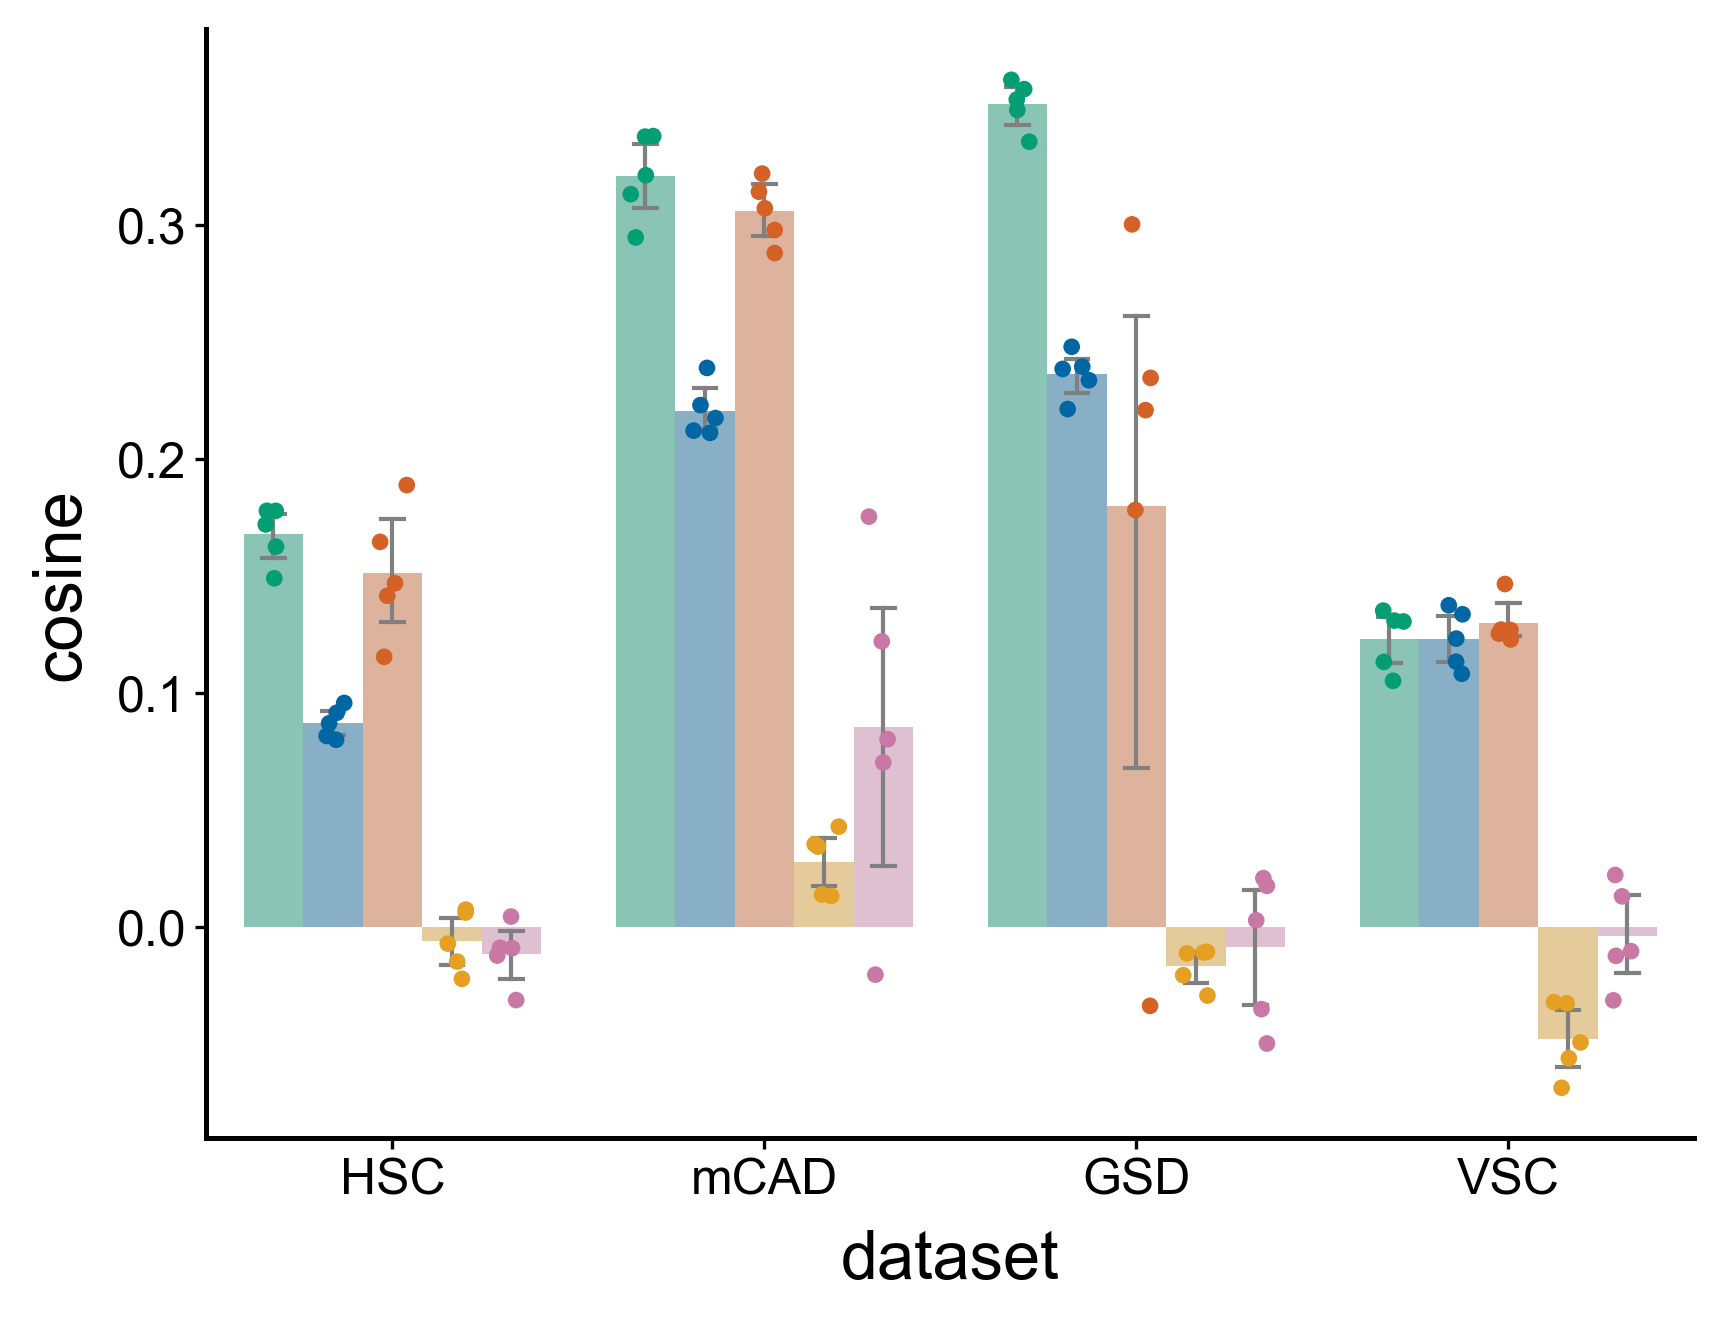

In [18]:

plt.figure(figsize=(6.4, 4.8), dpi=300)


palette = {
    'GOT':'#049e74',
    'OT-CFM':'#0066a4',
    'MIOFlow': '#d46126',
    'TrajectoryNet':'#e5a023',
    'TIGON': '#c978a5',     
}
# 先画条形图
ax = sns.barplot(
    data=plot_df2,
    x='dataset', 
    y='cosine',
    hue='method',
    legend=False, 
    capsize=.3,
    err_kws={"linewidth": 1., 'color':'grey'},
    palette=palette,
    order=datasets,
    hue_order=['GOT', 'OT-CFM', 'MIOFlow', 'TrajectoryNet', 'TIGON'],
    alpha=0.5,
    
)

# 再叠加抖动点图
sns.stripplot(
    data=plot_df2,
    x='dataset', 
    y='cosine',
    hue='method',
    
    dodge=True,  
    jitter=0.2,  
    
    palette=palette, 
    alpha=1.,
    legend=False,
    #ax=ax,
    size=4,
    order=datasets,
    hue_order=['GOT', 'OT-CFM', 'MIOFlow', 'TrajectoryNet', 'TIGON'],
)


In [ ]:
#plot_df.to_csv('./results/01.1_velocity/curated_result.csv')